In [8]:
#use wdtools_env_pip environment

import numpy as np
from math import log10, floor
from bisect import bisect_left
from scipy import stats
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
plt.style.use('Software/stefan.mplstyle')

import pandas as pd
pd.set_option('display.max_columns', None)
# Suppress SettingWithCopyWarnings
pd.options.mode.chained_assignment = None  # default='warn'

#for machine learning
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import load_model


# This notebook trains a machine learning method to reconstruct the correlation length in the simulation with no added noise sources (simulation=0)
- Use a deep learning approach with a convolutional neural network. CNNs are designed to automatically learn hierarchical features from raw data (usually images), so they are well suited to detect the peak/drop-off structure in the Moran's I x Z-Score curve that is useful in identifying the correlation length without me needing to do manual feature extraction. 
    - Use just the 1D Moran's I x Z-Score curve, don't include the distance array since the CNN will learn that scale from the labeled true correlation length
    - Don't cut the peak at small distances since the CNN should learn that feature doesn't necessarily drive the labeled true correlation length

# Import the simulation outputs

In [9]:
def get_output(corr_length,epsilon,sample_size,chance_companion,improvement_factor,effect_strength,noise_effect_array,
                  remove_likely_binaries,sample_type,nonzero_weight_cut=20,plot=True):
    #read back in measurements
    noise_label="".join(noise_effect_array)
    
    #sample_type='training','testing', or 'bootstrap'
    if sample_type=='training':
        #read back in measurements
        npzfile = np.load('csv/nb04_sample_size_'+str(sample_size)+'/'+noise_label+'_'+str(improvement_factor)+'_'+str(effect_strength)+'_'+str(chance_companion)+'_'+str(remove_likely_binaries)+'/training_data/ep_'+str(epsilon)+'_corr_'+str(corr_length)+'.npz')
        med_abs_deviations = npzfile['med_abs_deviations']
        
    if sample_type=='testing':
        #read back in measurements
        npzfile = np.load('csv/nb04_sample_size_'+str(sample_size)+'/'+noise_label+'_'+str(improvement_factor)+'_'+str(effect_strength)+'_'+str(chance_companion)+'_'+str(remove_likely_binaries)+'/testing_data/ep_'+str(epsilon)+'_corr_'+str(corr_length)+'.npz')
        med_abs_deviations = npzfile['med_abs_deviations']

    Ws = npzfile['Ws']
    final_distances = npzfile['distances']
    moransIs = npzfile['moransIs'] 
    expectations = npzfile['expectations']
    variances = npzfile['variances']
    zscores = npzfile['zscores']
    
    mult=[]
    for i in range(len(moransIs)):
        mult.append(moransIs[i]*zscores[i])
        
    #cut to make sure have enough nonzero weights for valid results
    index = bisect_left(Ws, nonzero_weight_cut)
    
    if plot:
        #plot
        fig, ((ax1),(ax2),(ax3)) = plt.subplots(3,1,figsize=(6,15),sharex=True)
        ax1.plot(final_distances,moransIs)
        ax1.axvspan(0,final_distances[index],color='red',alpha=0.5,label='Too Few WDs')
        ax1.axvline(corr_length,color='green',label='True Correlation\nLength')
        ax1.axhline(expectations[0],color='red',label='No Correlation')
        ax1.set_ylabel("Moran's I")
        ax1.legend()

        ax2.plot(final_distances,zscores)
        ax2.axvspan(0,final_distances[index],color='red',alpha=0.5,label='Too Few WDs')
        ax2.axvline(corr_length,color='green')
        ax2.set_ylabel('Z-score')

        ax3.plot(final_distances,mult)
        ax3.axvspan(0,final_distances[index],color='red',alpha=0.5,label='Too Few WDs')
        ax3.axvline(corr_length,color='green')
        ax3.set_xlabel('Distance Cut')
        ax3.set_ylabel(r"(Moran's I)$\times$(Z-score)")

        plt.subplots_adjust(wspace = 0,hspace=0)
        plt.show()
    
    return(final_distances,med_abs_deviations,Ws,moransIs,expectations,variances,zscores,mult,index)


In [10]:
def count_simulations(corr_lengths,epsilons,sample_size,chance_companion,improvement_factor,effect_strength,noise_effect_array,
                  remove_likely_binaries,sample_type):
    
    #turn into combined simulation parameter array
    simulation_params=[]
    for corr_length in corr_lengths:
        for epsilon in epsilons:
            simulation_params.append([corr_length,epsilon])
            
    noise_label="".join(noise_effect_array)
    
    simulation_params_not_run=[]
    simulation_params_run=[]
    
    #check if each training data simulation has been run
    for i in range(len(simulation_params)):
        simulation=simulation_params[i]
        corr_length=simulation[0]
        epsilon=simulation[1]
        try:
            if sample_type=='training':
                #read back in measurements
                npzfile = np.load('csv/nb04_sample_size_'+str(sample_size)+'/'+noise_label+'_'+str(improvement_factor)+'_'+str(effect_strength)+'_'+str(chance_companion)+'_'+str(remove_likely_binaries)+'/training_data/ep_'+str(epsilon)+'_corr_'+str(corr_length)+'.npz')
            if sample_type=='testing':
                #read back in measurements
                npzfile = np.load('csv/nb04_sample_size_'+str(sample_size)+'/'+noise_label+'_'+str(improvement_factor)+'_'+str(effect_strength)+'_'+str(chance_companion)+'_'+str(remove_likely_binaries)+'/testing_data/ep_'+str(epsilon)+'_corr_'+str(corr_length)+'.npz')
            simulation_params_run.append(simulation)
            #print('Simulation exists, ', simulation)
        except:
            simulation_params_not_run.append(simulation)
            #print('No simulation exists, ', simulation)

    return(simulation_params_run,simulation_params_not_run)


In [11]:
#for training data
corr_lengths=np.round(np.append(np.linspace(1,98,30)[1:],np.logspace(2,3,num=100)[1:-1]),2)
def round_sig(x,sig):
    return round(x, sig-int(floor(log10(abs(x))))-1)
epsilons_init=np.append(np.logspace(-10,-1,num=20),np.linspace(0.1,0.5,4)[1:])
epsilons=[]
for e in epsilons_init:
    epsilons.append(round_sig(e,2))

#for testing data
corr_lengths_testing=[10,25,50,75,100,150,200,250,300,400,500,600,700,800,900,1000]
epsilons_testing=[1e-10,1e-7,1e-4,0.001,0.005,0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]

In [12]:
sample_size=10207
noise_effect_array=['0','0','0','0','0']
improvement_factor=1
effect_strength=1
chance_companion=0.01
remove_likely_binaries='0'

#count how many simulations have been run

simulation_params_run,simulation_params_not_run=count_simulations(corr_lengths,epsilons,sample_size,chance_companion,improvement_factor,effect_strength,noise_effect_array,
                  remove_likely_binaries,'training')

print('training')
print(len(simulation_params_run))
print(len(simulation_params_not_run))
print('')

simulation_params_run_testing,simulation_params_not_run_testing=count_simulations(corr_lengths_testing,epsilons_testing,sample_size,chance_companion,improvement_factor,effect_strength,noise_effect_array,
                  remove_likely_binaries,'testing')
print('testing')
print(len(simulation_params_run_testing))
print(len(simulation_params_not_run_testing))

training
2921
0

testing
256
0


657.93 1.8e-06


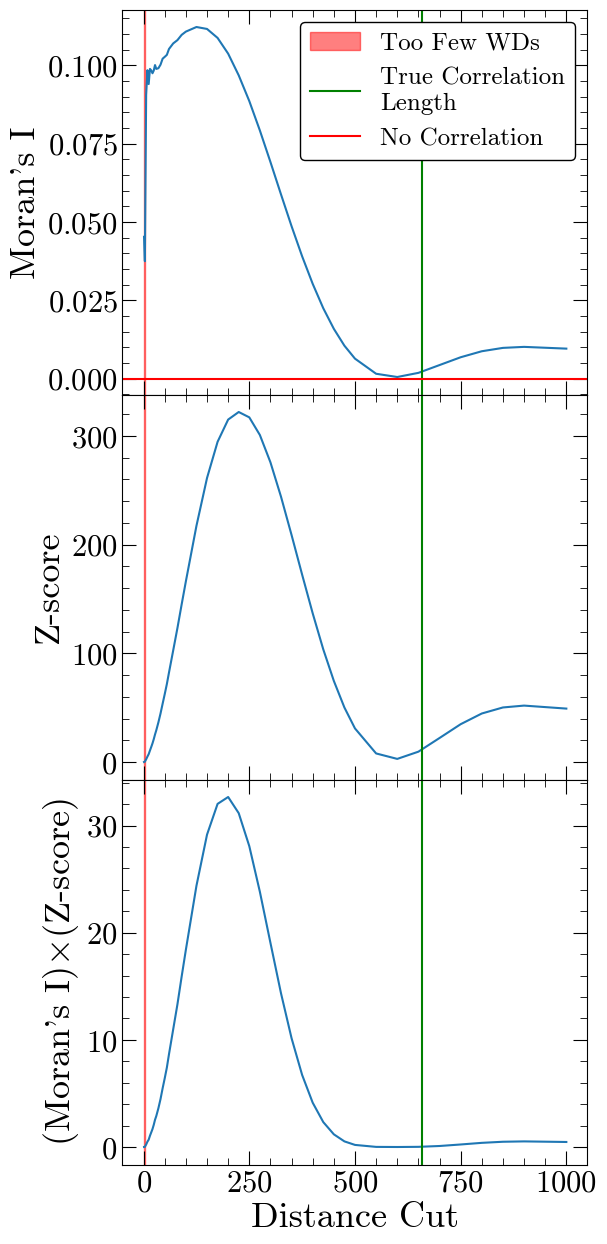

44.48 0.5


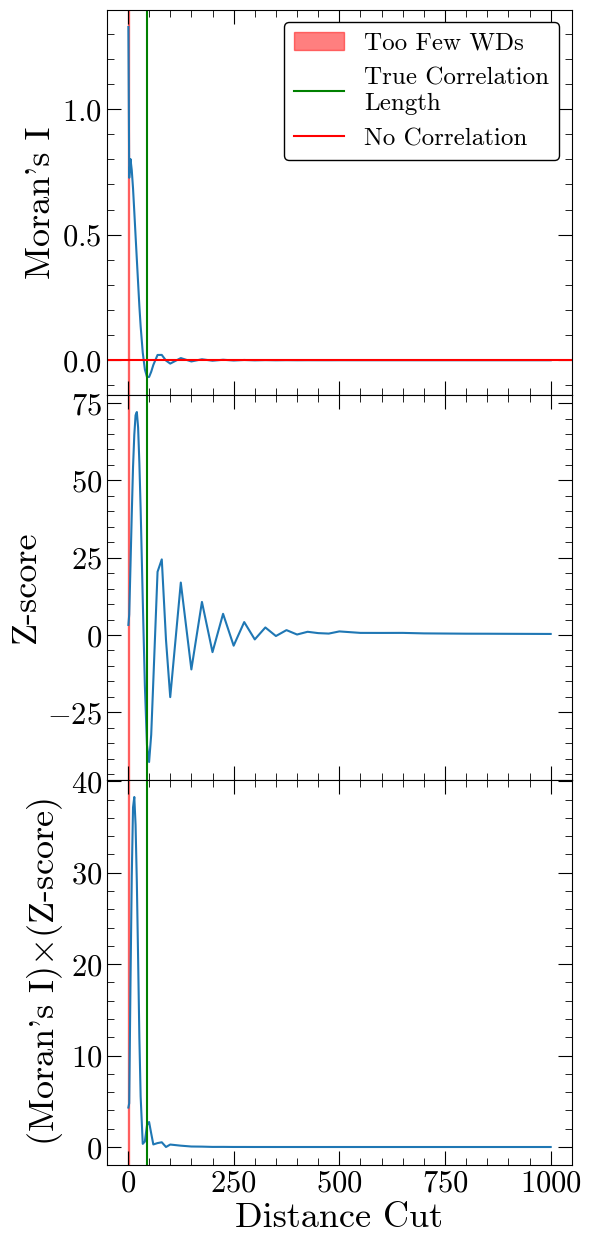

486.26 5.5e-06


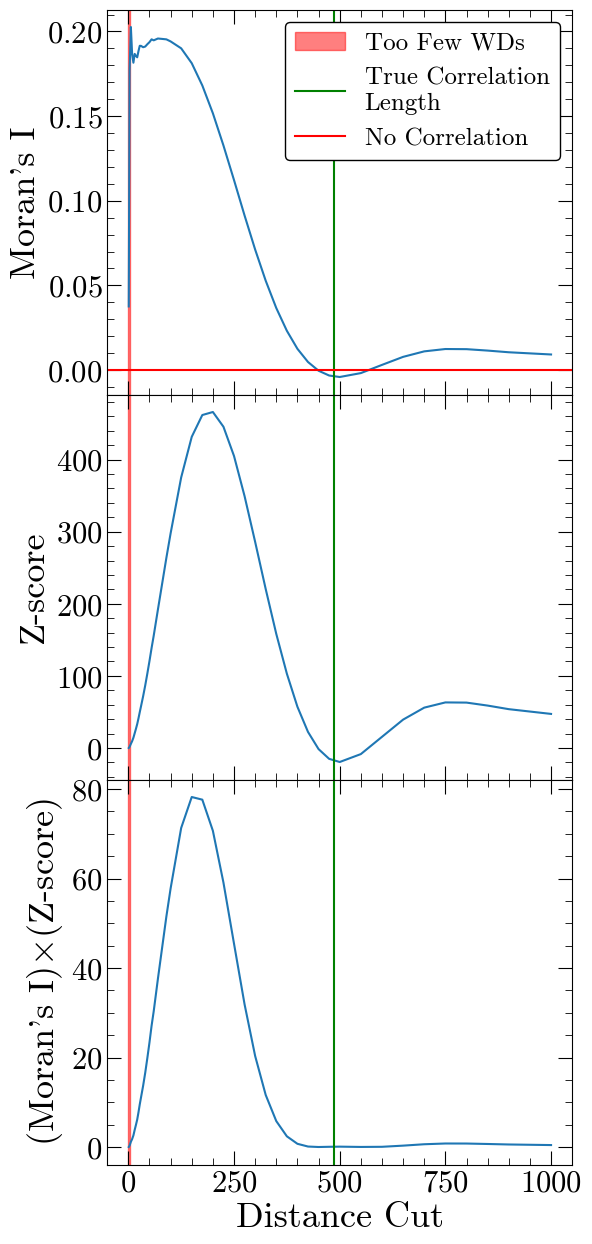

17.72 0.5


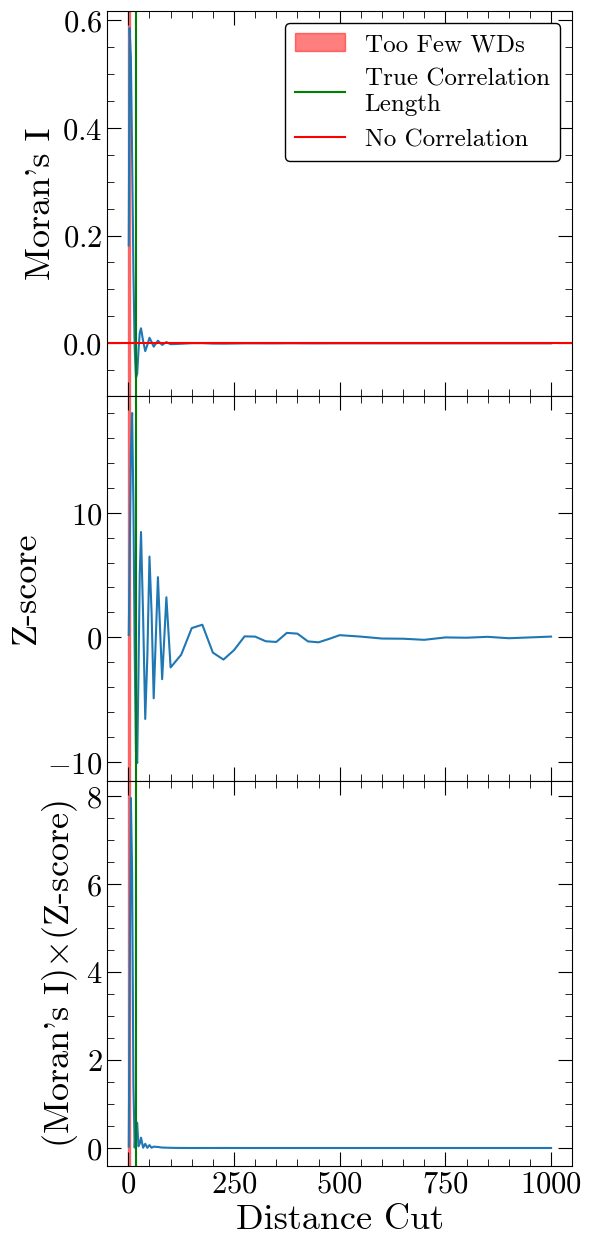

312.57 7e-08


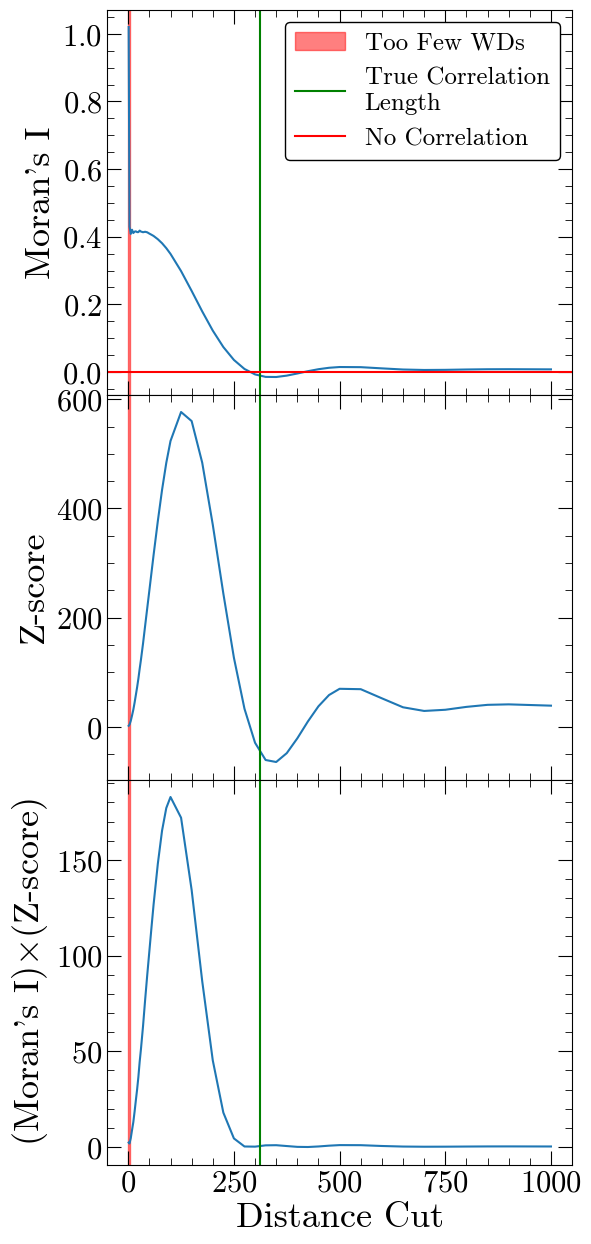

98.0 1.8e-06


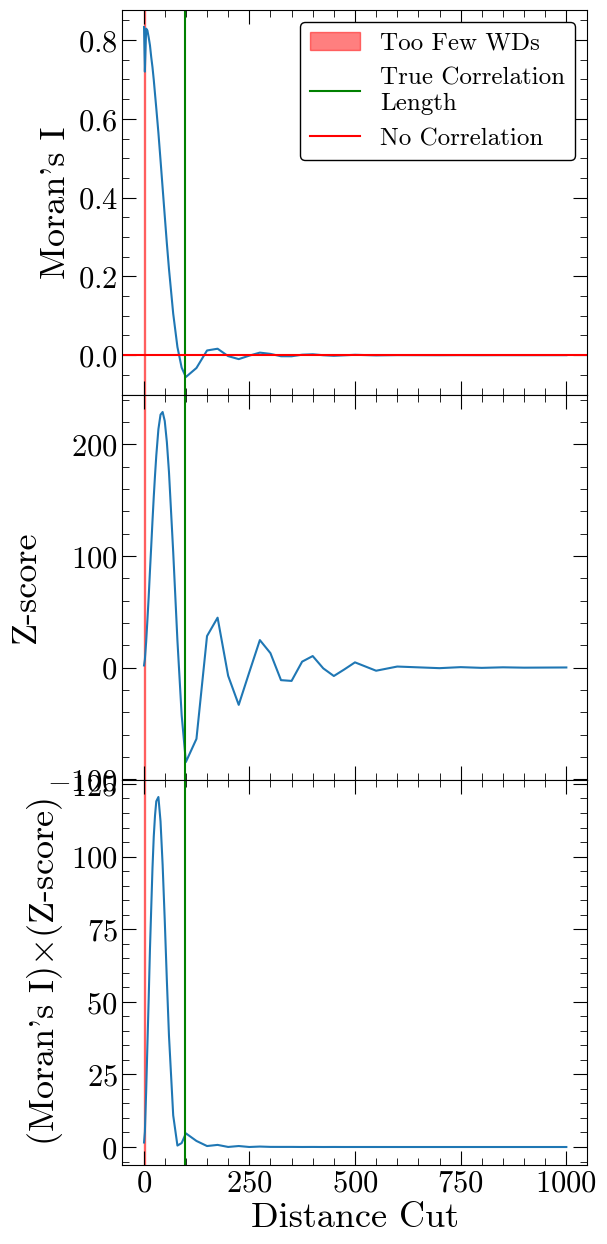

74.59 2.6e-09


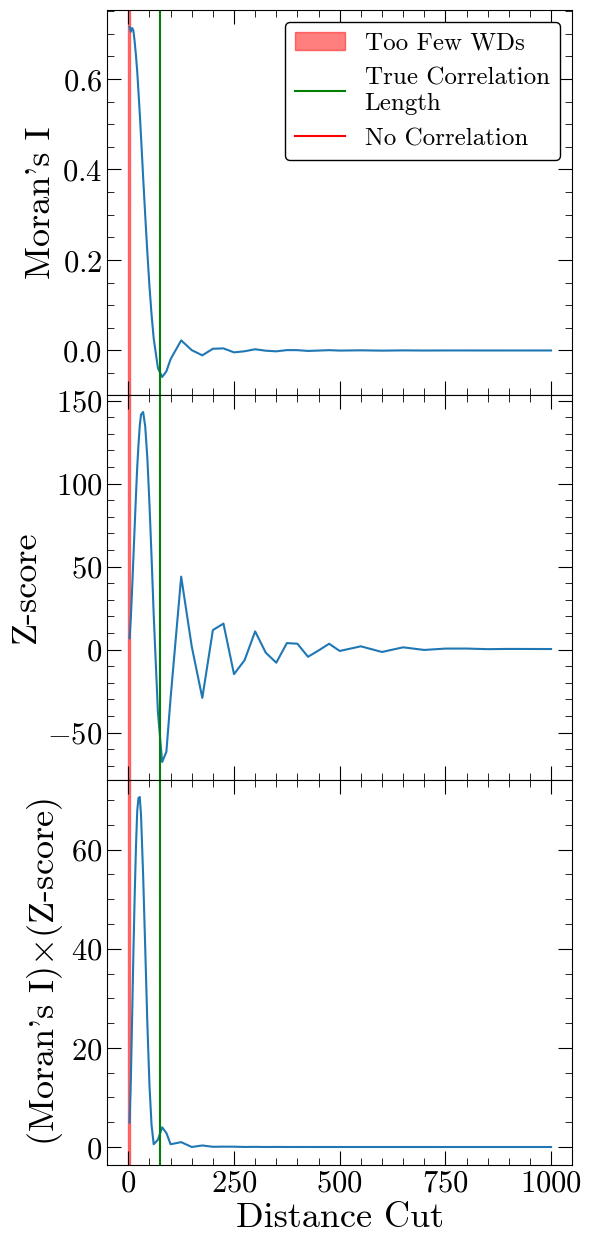

231.01 1.8e-06


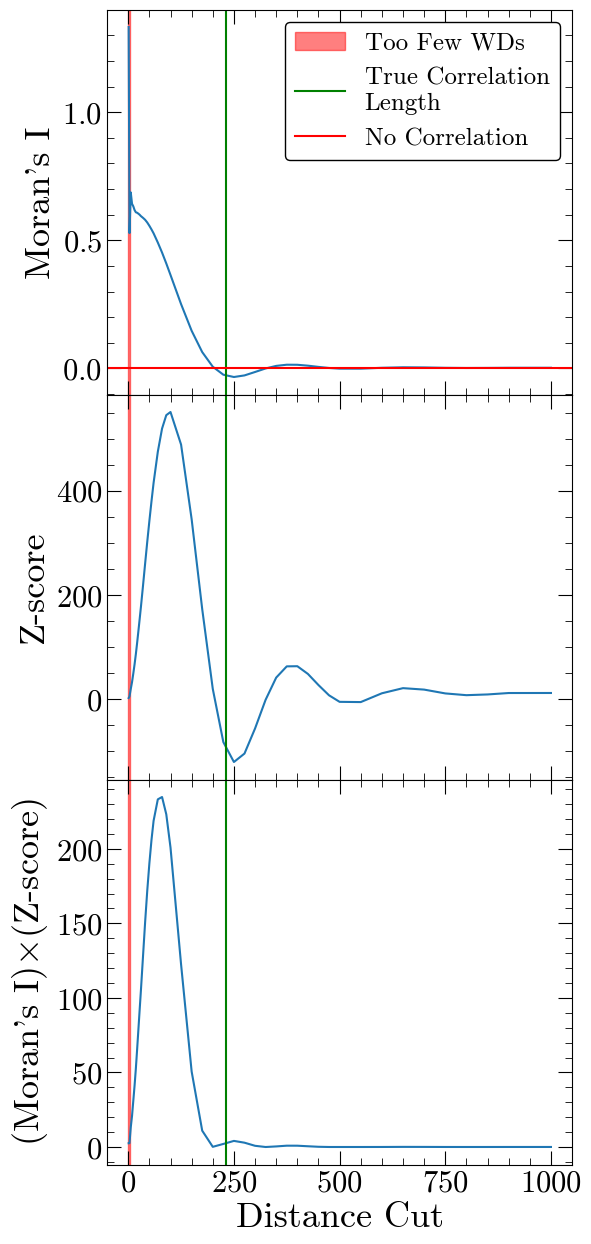

475.08 2.6e-09


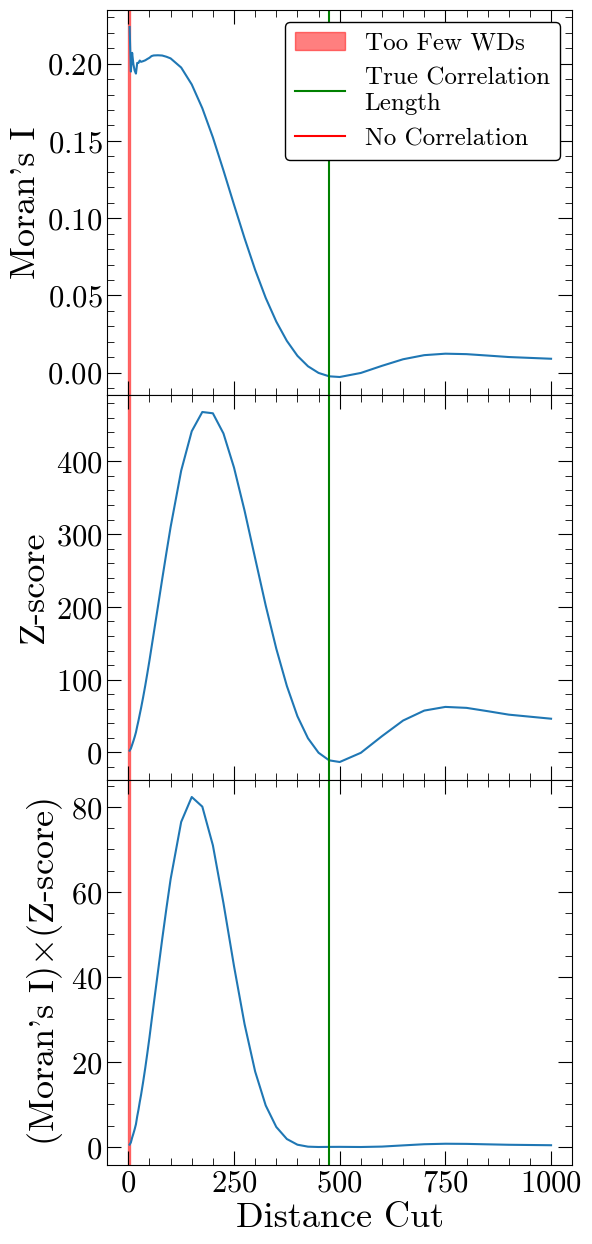

109.75 8.9e-10


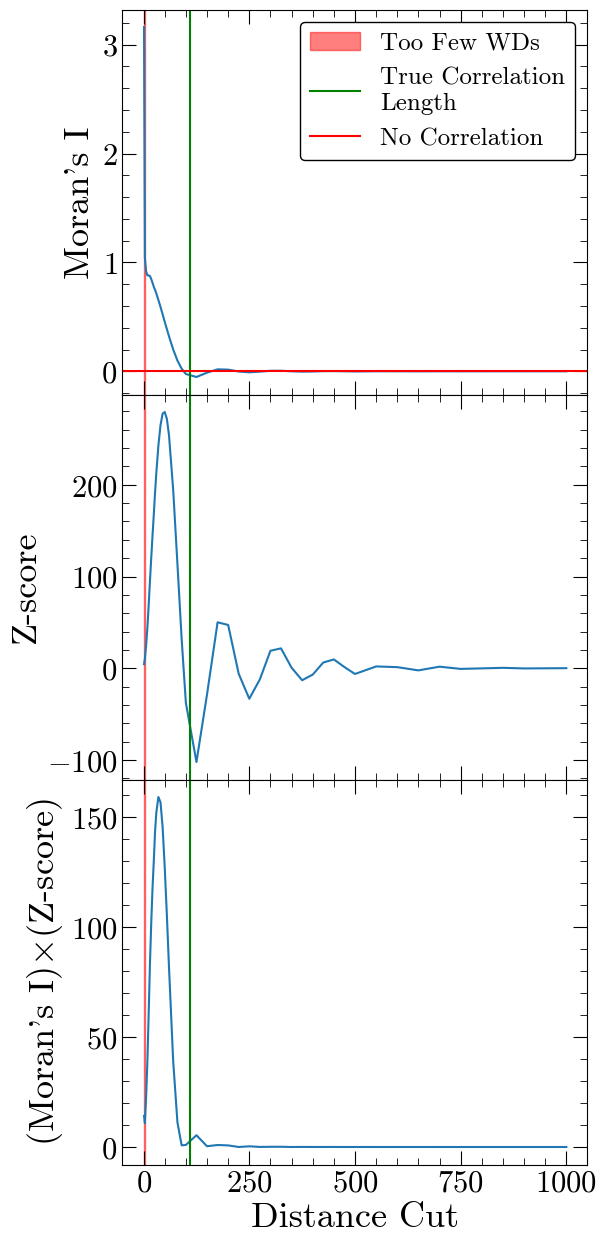

In [13]:
#display a few curves from the training data set
indices=np.random.randint(len(simulation_params_run), size=10)
for index in indices:
    corr_length=simulation_params_run[index][0]
    epsilon=simulation_params_run[index][1]
    print(corr_length,epsilon)
    sample_size=10207
    output=get_output(corr_length,epsilon,sample_size,chance_companion,improvement_factor,effect_strength,noise_effect_array,
                  remove_likely_binaries,'training')

# Make a representative plot of various epsilons and correlation lengths

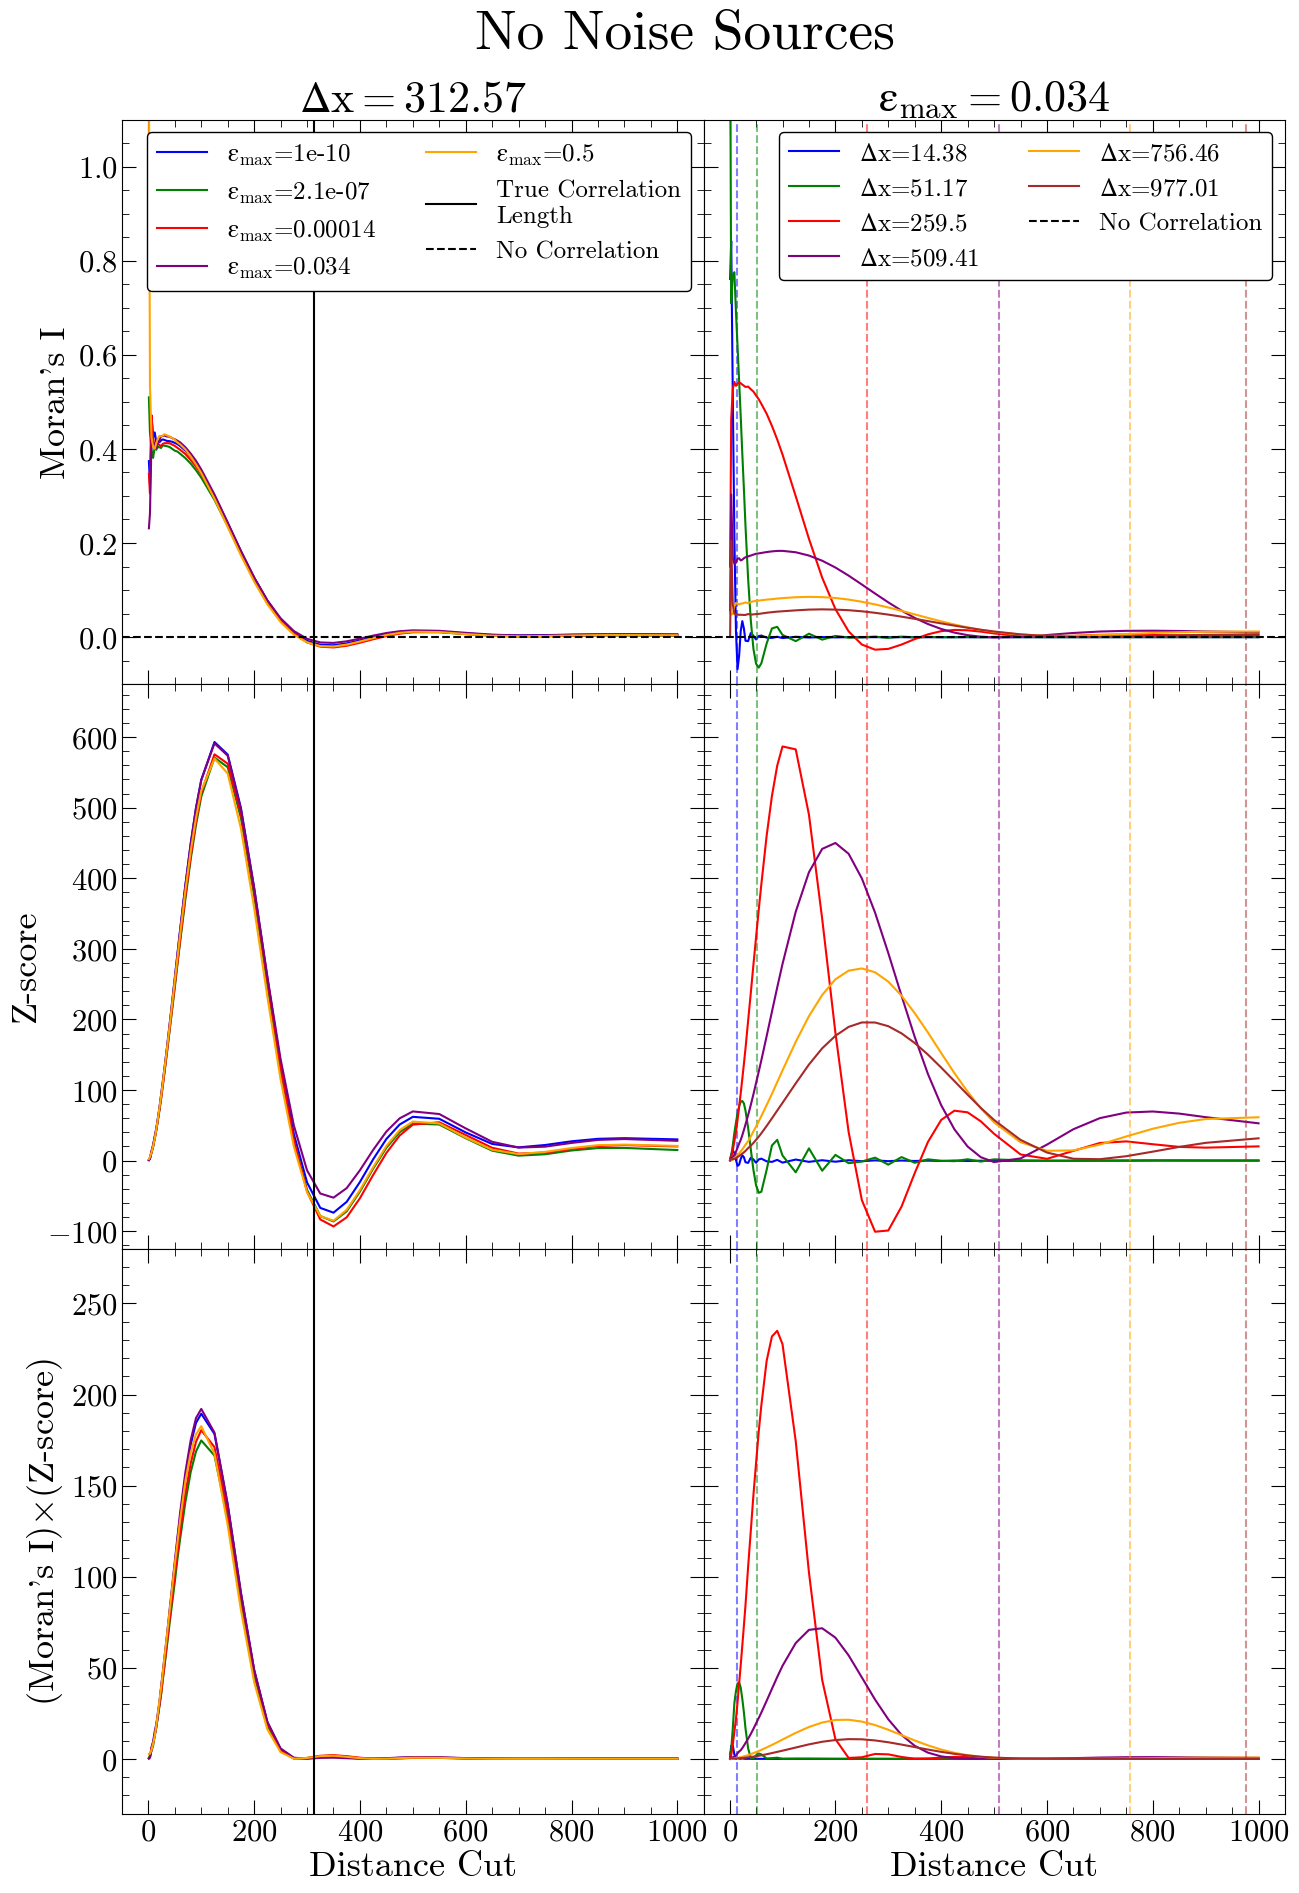

In [14]:
fig, ((ax1,ax4),(ax2,ax5),(ax3,ax6)) = plt.subplots(3,2,figsize=(15,22),sharex=True)

colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']

#One correlation length, various epsilons
corr_length=312.57
epsilons_subset=[1e-10,2.1e-07,0.00014,0.034,0.5]
for i in range(len(epsilons_subset)):
    epsilon=epsilons_subset[i]
    color=colors[i]
    final_distances,med_abs_deviations,Ws,moransIs,expectations,variances,zscores,mult,index=get_output(corr_length,epsilon,sample_size,chance_companion,improvement_factor,effect_strength,noise_effect_array,
                                                                                                          remove_likely_binaries,'training',plot=False)
    ax1.plot(final_distances,moransIs,color=color,label='$\epsilon_{max}$='+str(epsilon))
    ax2.plot(final_distances,zscores,color=color)
    ax3.plot(final_distances,mult,color=color)  
ax1.axvline(corr_length,color='black',label='True Correlation\nLength')
ax1.axhline(expectations[0],color='black',linestyle='--',label='No Correlation')
ax1.set_ylabel("Moran's I")
ax1.legend(ncol=2,loc='upper right')

ax2.axvline(corr_length,color='black',label='True Correlation\nLength')
ax2.set_ylabel('Z-score')

ax3.axvline(corr_length,color='black',label='True Correlation\nLength')
ax3.set_xlabel('Distance Cut')
ax3.set_ylabel(r"(Moran's I)$\times$(Z-score)")

ax1.set_title('$\Delta x=$'+str(corr_length))
    
#One epsilon length, various correlation lengths
epsilon=0.034
corr_lengths_subset=[14.38, 51.17, 259.5, 509.41, 756.46, 977.01]
for i in range(len(corr_lengths_subset)):
    corr_length=corr_lengths_subset[i]
    color=colors[i]
    final_distances,med_abs_deviations,Ws,moransIs,expectations,variances,zscores,mult,index=get_output(corr_length,epsilon,sample_size,chance_companion,improvement_factor,effect_strength,noise_effect_array,
                                                                                                          remove_likely_binaries,'training',plot=False)
    ax4.plot(final_distances,moransIs,color=color,label='$\Delta x$='+str(corr_length))
    ax4.axvline(corr_length,color=color,linestyle='--',alpha=0.5)
    ax5.plot(final_distances,zscores,color=color)
    ax5.axvline(corr_length,color=color,linestyle='--',alpha=0.5)
    ax6.plot(final_distances,mult,color=color)  
    ax6.axvline(corr_length,color=color,linestyle='--',alpha=0.5)

ax4.axhline(expectations[0],color='black',linestyle='--',label='No Correlation')
ax4.legend(ncol=2,loc='upper right')

ax6.set_xlabel('Distance Cut')

ax4.set_title('$\epsilon_{max}=$'+str(epsilon))

#clean up the plot
ax1.set_ylim(-0.1,1.1)
ax4.set_ylim(-0.1,1.1)

ax2.set_ylim(-125,675)
ax5.set_ylim(-125,675)

ax3.set_ylim(-30,280)
ax6.set_ylim(-30,280)

ax4.set_yticklabels([]) 
ax5.set_yticklabels([]) 
ax6.set_yticklabels([]) 

fig.suptitle('No Noise Sources', fontsize=40, x=0.5, y=0.93)
plt.subplots_adjust(wspace = 0,hspace=0)

plt.savefig('curves_no_noise.pdf', dpi=300)#, pad_inches=0.3)

# Set up the training and testing data for the CNN

In [17]:
sample_size=10207

x_train=[]
y_train=[]
ep_train=[]
for simulation in simulation_params_run:
    corr_length=simulation[0]
    epsilon=simulation[1]
    final_distances,med_abs_deviations,Ws,moransIs,expectations,variances,zscores,mult,index=get_output(corr_length,epsilon,sample_size,chance_companion,improvement_factor,effect_strength,noise_effect_array,
                                                                                                          remove_likely_binaries,'training',plot=False)
    #Normalize then save Moran's I x Z-Score curve as 1D training data
    normalized=mult/np.nanmax(np.abs(mult))
    x_train.append(normalized)
    #save correlation length as true label
    y_train.append(corr_length)
    #also save epsilon
    ep_train.append(epsilon)
    
x_train=np.array(x_train)
y_train=np.array(y_train)
ep_train=np.array(ep_train)

#there are NaNs in the data set from the d = 1pc cut having no WDs at that separation, set these NaNs to 0
x_train=np.nan_to_num(x_train)

#check for NaNs and Infs
print(np.isnan(x_train).any())
print(np.isinf(x_train).any())

training_data=pd.DataFrame()
training_data['y_true']=y_train
training_data['epsilon']=ep_train

training_data.head()

False
False


y_true       epsilon
0    4.34  1.000000e-10
1    4.34  3.000000e-10
2    4.34  8.900000e-10
3    4.34  2.600000e-09
4    4.34  7.800000e-09

In [18]:
x_test=[]
y_test=[]
ep_test=[]
for simulation in simulation_params_run_testing:
    corr_length=simulation[0]
    epsilon=simulation[1]
    final_distances,med_abs_deviations,Ws,moransIs,expectations,variances,zscores,mult,index=get_output(corr_length,epsilon,sample_size,chance_companion,improvement_factor,effect_strength,noise_effect_array,
                                                                                                          remove_likely_binaries,'testing',plot=False)
    #Normalize then save Moran's I x Z-Score curve as 1D training data
    normalized=mult/np.nanmax(np.abs(mult))
    x_test.append(normalized)
    #save correlation length as true label
    y_test.append(corr_length)
    #also save epsilon
    ep_test.append(epsilon)
    
x_test=np.array(x_test)
y_test=np.array(y_test)
ep_test=np.array(ep_test)

#there are NaNs in the data set from the d = 1pc cut having no WDs at that separation, set these NaNs to 0
x_test=np.nan_to_num(x_test)

#check for NaNs and Infs
print(np.isnan(x_test).any())
print(np.isinf(x_test).any())

testing_data=pd.DataFrame()
testing_data['y_true']=y_test
testing_data['epsilon']=ep_test

testing_data.head()

False
False


y_true       epsilon
0      10  1.000000e-10
1      10  1.000000e-07
2      10  1.000000e-04
3      10  1.000000e-03
4      10  5.000000e-03

### Train and Test different CNN configurations

In [19]:
def comparison_stats(data,verbose,success_fit=False,success_fit_threshold=0.1):
    if success_fit:
        init_len=len(data)
        data['abs_frac_err']=np.abs((data['y_true']-data['y_pred'])/data['y_true'])
        data=data.query('abs_frac_err<@success_fit_threshold')
        num_success=len(data)
        #reset the indices
        indices=np.arange(0,len(data))
        data.set_index(indices,inplace=True)
        y_true=data['y_true']
        y_pred=data['y_pred']
        frac_success=num_success/init_len
    else:
        y_true=data['y_true']
        y_pred=data['y_pred']
        frac_success=None
    
    error=y_true-y_pred
    frac_err=error/y_true
    
    #calculate the rmse
    rmse = 0
    for i in range(len(y_true)):
        rmse += (error[i])**2
    rmse = np.sqrt(rmse / len(y_true))
    
    #calculate the median absolute error between the datasets
    mae=np.median(np.abs(error))

    #calculate the bias between the datasets
    bias=np.median(error)
    
    #calculate the median absolute fractional error
    med_frac=np.median(np.abs(frac_err))
    
    if verbose:
        if success_fit:
            print(r'Frac Success Fit: {:2.3f} '.format(frac_success))
        print(r'RMSE: {:2.3f} '.format(rmse)+'pc')
        print(r'MAE: {:2.3f} '.format(mae)+'pc')
        print(r'BIAS: {:2.3f} '.format(bias)+'pc')
        print(r'MED FRAC ERR: {:2.3f} '.format(med_frac))
        
    return(rmse,mae,bias,med_frac,error,frac_err,frac_success)

In [52]:
def comparison_plots(training_data,testing_data,success_fit_threshold=0.1,statx=10,staty=700,statdy=50,lim='default', siegel=True,verbose=True):
    #drop the failed fits
    testing_data=testing_data.dropna()
    #reset the indices
    indices=np.arange(0,len(testing_data))
    testing_data.set_index(indices,inplace=True)
    
    y_true_training=training_data['y_true']
    y_pred_training=training_data['y_pred']
    y_true_testing=testing_data['y_true']
    y_pred_testing=testing_data['y_pred']
    
    unit='pc'
    
    #calculate stats
    if verbose:
        print('Training Stats')
    rmse_training,mae_training,bias_training,med_frac_training,error_training,frac_err_training,frac_success=comparison_stats(training_data,verbose)
    if verbose:
        print('')
        print('Training Stats, Successful Fits')
    rmse_training_success,mae_training_success,bias_training_success,med_frac_training_success,error_training_success,frac_err_training_success,frac_success_training=comparison_stats(training_data,verbose,True,success_fit_threshold)
    if verbose:
        print('')
        print('Testing Stats')
    rmse_testing,mae_testing,bias_testing,med_frac_testing,error_testing,frac_err_testing,frac_success=comparison_stats(testing_data,verbose)
    if verbose:
        print('')
        print('Testing Stats, Successful Fits')
    rmse_testing_success,mae_testing_success,bias_testing_success,med_frac_testing_success,error_testing_success,frac_err_testing_success,frac_success_testing=comparison_stats(testing_data,verbose,True,success_fit_threshold)
    
    stats_df=pd.DataFrame()
    stats_df['mae_training']=[mae_training]
    stats_df['frac_success_training']=[frac_success_training]
    stats_df['mae_testing']=[mae_testing]
    stats_df['frac_success_testing']=[frac_success_testing]
    
    #plot the agreement with stats
    fig, (ax1,ax2) =plt.subplots(1,2,figsize=(16,8))
    ax1.scatter(y_true_training,y_pred_training,c='k',alpha=0.1,label='Training Data')
    ax1.scatter(y_true_testing,y_pred_testing,c='r',label='Testing Data')
    #ax1.errorbar(y_true_testing,y_pred_testing,yerr=e_y_pred_testing,fmt='o',color='red',ecolor = 'red',label='Testing Data')
    ax1.text(statx, staty, 'Frac Success: {:2.3f} '.format(frac_success_testing))
    ax1.text(statx, staty-1*statdy, 'RMSE = {:.3f} '.format(rmse_testing_success)+unit)
    ax1.text(statx, staty-2*statdy, 'MAE = {:.3f} '.format(mae_testing_success)+unit)
    ax1.text(statx, staty-3*statdy, 'Bias = {:.3f} '.format(bias_testing_success)+unit)
    ax1.set_xlabel(r'True Correlation Length (pc)')
    ax1.set_ylabel(r'Measured Correlation Length (pc)')
    maxval=max(max(y_true_training),max(y_pred_training))
    minval=min(min(y_true_training),min(y_pred_training))
    #plot 1 to 1 trendline
    ax1.plot([minval,maxval], [minval,maxval], color = 'black',label="1 to 1")
    ax1.legend()
    if lim!='default':
        ax1.set_xlim((lim[0],lim[1]))
        ax1.set_ylim((lim[0],lim[1]))
        
    ax2.scatter(y_true_training,y_pred_training,c='k',alpha=0.1,label='Training Data')
    ax2.scatter(y_true_testing,y_pred_testing,c='r',label='Testing Data')
    #ax2.errorbar(y_true_testing,y_pred_testing,yerr=e_y_pred_testing,fmt='o',color='red',ecolor = 'red',label='Testing Data')
    ax2.set_xlabel(r'True Correlation Length (pc)')
    ax2.set_ylabel(r'Measured Correlation Length (pc)')
    maxval=max(max(y_true_training),max(y_pred_training))
    minval=min(min(y_true_training),min(y_pred_training))
    #plot 1 to 1 trendline
    ax2.plot([minval,maxval], [minval,maxval], color = 'black',label="1 to 1")
    ax2.legend()
    if lim!='default':
        ax2.set_xlim((lim[0],lim[1]))
        ax2.set_ylim((lim[0],lim[1]))
    ax2.set_yscale('log')
    ax2.set_xscale('log')
    plt.show()
    
    #plot the agreement with trendlines
    fig, ax1 =plt.subplots(1,1,figsize=(8,8))
    ax1.scatter(y_true_training,y_pred_training,c='k',alpha=0.1,label='Training Data')
    ax1.scatter(y_true_testing,y_pred_testing,c='r',label='Testing Data')
    #ax1.errorbar(y_true_testing,y_pred_testing,yerr=e_y_pred_testing,fmt='o',color='red',ecolor = 'red',label='Testing Data')
    ax1.set_xlabel(r'True Correlation Length (pc)')
    ax1.set_ylabel(r'Measured Correlation Length (pc)')
    #plot 1 to 1 trendline
    ax1.plot([minval,maxval], [minval,maxval], color = 'black',label="1 to 1")
    #add a linear trendlines
    if siegel==True:
        coef = stats.siegelslopes(y_pred_testing, y_true_testing)
        poly1d_fn = np.poly1d(coef) 
        ax1.plot([minval,maxval], poly1d_fn([minval,maxval]), label="Trendline\n"+str(np.round(coef[0],2))+"*x+"+str(np.round(coef[1],2)))
    else:
        coef= np.polyfit(y_true_testing,y_pred_testing,1)
        poly1d_fn= np.poly1d(coef) 
        ax1.plot([minval,maxval], poly1d_fn([minval,maxval]), label="Trendline\n"+str(np.round(coef[0],2))+"*x+"+str(np.round(coef[1],2)))
    ax1.legend()
    if lim!='default':
        ax1.set_xlim((lim[0],lim[1]))
        ax1.set_ylim((lim[0],lim[1]))
    plt.show()

    # plot the fractional error between the datasets
    fig, ax1 =plt.subplots(1,1,figsize=(8,8))
    ax1.scatter(y_true_training, frac_err_training,c='k',alpha=0.3,label='Training Data')
    ax1.scatter(y_true_testing, frac_err_testing,c='r',label='Testing Data')
    ax1.axhline(med_frac_testing,color='green',label='MED ABS FRAC ERR = {:.3f}'.format(med_frac_testing_success))
    ax1.axhline(-med_frac_testing,color='green')
    ax1.axhline(success_fit_threshold,color='blue',label='Successful Threshold = {:.3f}'.format(success_fit_threshold))
    ax1.axhline(-success_fit_threshold,color='blue')
    ax1.set_xlabel(r'True Correlation Length (pc)')
    ax1.set_ylabel(r'(True-Pred)/True')
    ax1.legend()
    plt.show()
    
    # plot the fractional error between the datasets
    # again but zoomed in
    fig, ax1 =plt.subplots(1,1,figsize=(8,8))
    ax1.scatter(y_true_training, frac_err_training,c='k',alpha=0.3,label='Training Data')
    ax1.scatter(y_true_testing, frac_err_testing,c='r',label='Testing Data')
    ax1.axhline(med_frac_testing,color='green',label='MED ABS FRAC ERR = {:.3f}'.format(med_frac_testing_success))
    ax1.axhline(-med_frac_testing,color='green')
    ax1.axhline(success_fit_threshold,color='blue',label='Successful Threshold = {:.3f}'.format(success_fit_threshold))
    ax1.axhline(-success_fit_threshold,color='blue')
    ax1.set_xlabel(r'True Correlation Length (pc)')
    ax1.set_ylabel(r'(True-Pred)/True')
    ax1.set_ylim((-1,1))
    ax1.legend()
    plt.show()
    
    return(stats_df)
    

In [21]:
#define a function to create the heatmap
def heatmap(data, row_labels, col_labels, ax=None):
    if not ax:
        ax = plt.gca()
        
    # Define color map with custom gradients
    cmap = plt.cm.viridis  # Default, replace with any colormap of your choice
    # Define boundaries for the color ranges
    boundaries = [0, 2, 4, 6, 8, 10, 1000]
    # Define colors corresponding to each range (make sure this matches the number of ranges)
    colors_for_ranges = [
    '#228B22',  # Forest Green
    '#32CD32',  # Lime Green
    '#FFD700',  # Gold (Yellow)
    '#FFA500',  # Orange
    '#FF4500',  # Orange Red
    '#DC143C',  # Crimson
    'black']
    # Create a ListedColormap and BoundaryNorm
    cmap = pltcolors.ListedColormap(colors_for_ranges)
    norm = pltcolors.BoundaryNorm(boundaries, cmap.N)
    
    # Plot the heatmap
    im = ax.imshow(data, cmap=cmap, norm=norm)
    
    #label rows/columns
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_xticklabels(col_labels)#, fontsize=10)
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_yticklabels(row_labels)
    
    #draw grid lines
    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="k", linestyle='-', linewidth=0.5,alpha=0.3)
    ax.tick_params(which="minor", bottom=False, left=False,top=False, right=False)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    return im

def heatmap_testing_data(testing_data,figtitle=None,savefig=False,figname=None):
    data=[]
    failed_fit_region_count=0
    for corr_len in corr_lengths_testing:
        tmp=[]
        for epsilon in epsilons_testing:
            val=testing_data.query('y_true==@corr_len & epsilon==@epsilon')['abs_frac_err'].to_list()[0]*100
            tmp.append(val)
            if val>10:
                failed_fit_region_count+=1
        data.append(tmp)
    data=np.array(data)
    
    fig,ax0=plt.subplots(1, 1, figsize=(10, 10))
    ylabels=[str(i) for i in corr_lengths_testing]
    xlabels=[str(i) for i in epsilons_testing]
    hm=heatmap(data, ylabels, xlabels, ax=ax0)
    ax0.set_xlabel('$\epsilon$')
    ax0.set_ylabel('$\Delta x_{true}$')
    
    ax0.set_title(figtitle)
    
    #plot colorbar
    cbar_ax = fig.add_axes([0.94, 0.15, 0.02, 0.7])
    fig.colorbar(hm, cbar_ax)
    cbar_ax.set_ylabel("Absolute Percent Error")#,fontsize=16)
    
    if savefig:
        plt.savefig(figname+'.pdf', dpi=300)
        
    plt.show()
    print('Number of squares with abs percent err>10%, ', failed_fit_region_count)
    
    return(failed_fit_region_count)

In [98]:
def test_model(model,stats=True,plot=True):
    sample_size=10207
    
    # use the model to predict the training data
    y_pred_train = model.predict(x_train, verbose=0)
    training_data['y_pred']=y_pred_train
    
    # use the model to predict the testing data
    y_pred_test = model.predict(x_test, verbose=0)
    testing_data['y_pred']=y_pred_test
    
    rmse_testing_success,mae_testing_success,bias_testing_success,med_frac_testing_success,error_testing_success,frac_err_testing_success,frac_success_testing=comparison_stats(testing_data,False,True,success_fit_threshold=0.1)
    
    if plot:
        #some runs return NaNs, show those fits
        nan_corr_lengths=testing_data[testing_data['y_pred'].isna()]
        print('')
        print('Showing the '+str(len(nan_corr_lengths))+' curves that returned NaNs')
        display(nan_corr_lengths)
        for i in range(len(nan_corr_lengths)):
            corr_length=nan_corr_lengths['y_true'].to_list()[i]
            epsilon=nan_corr_lengths['epsilon'].to_list()[i]
            output=get_output(corr_length,epsilon,sample_size,'testing',plot=True)

        #show comparison stats and plots
        stats_df=comparison_plots(training_data,testing_data)
        
        #show testing data absolute percent error heatmap
        failed_fit_region_count=heatmap_testing_data(testing_data) 
    else:
        stats_df=None
        nan_corr_lengths='Not saved!'
        failed_fit_region_count=0
        for corr_len in corr_lengths_testing:
            for epsilon in epsilons_testing:
                val=testing_data.query('y_true==@corr_len & epsilon==@epsilon')['abs_frac_err'].to_list()[0]*100
                if val>10:
                    failed_fit_region_count+=1
    
    if stats:
        return(stats_df)
    else:
        return(failed_fit_region_count,mae_testing_success,training_data,testing_data,nan_corr_lengths)

# Pick models and tune the model hyperparameters

1. **Number of Filters in Convolutional Layers**
   The number of filters (also known as the number of output channels) determines the depth of the feature maps after each convolutional layer.
   **What to try:**
   - You can experiment with **increasing** the number of filters in each layer.
   - Alternatively, **decrease** the number of filters to make the model simpler and see if performance improves.
   
   Keep in mind that increasing the number of filters typically increases the model’s capacity, which can improve performance on more complex tasks but may also lead to overfitting if not properly regularized.

2. **Kernel Size**
   The kernel size defines the window of the convolution. 
   **What to try:**
   - **Larger kernel sizes** (e.g., 5 or 7) might capture broader patterns, which can be useful if the input data has long-range dependencies.
   - **Smaller kernel sizes** (e.g., 1 or 2) might be beneficial if you want to capture very fine-grained features.

3. **Number of Layers**
   The depth of the network can have a significant impact on its performance.
   **What to try:**
   - Adding more **convolutional layers** (e.g., 4 or 5 layers instead of 3) could help the model learn more complex patterns.
   - Alternatively, you can **reduce the number of layers** and see if performance improves, especially if overfitting is a concern.

4. **Pooling Layers**
   Pooling layers help reduce spatial dimensions and retain important features. You're using `MaxPooling1D(2)` after each convolution layer, which is a good starting point.
   **What to try:**
   - **Change the pooling size** (e.g., use `MaxPooling1D(3)` or `MaxPooling1D(4)`).
   - Experiment with different **types of pooling** (e.g., **AveragePooling1D**) to see if it affects performance.

5. **Dense Layer Units**
   In your current model, the final dense layer has 128 units with ReLU activation. The number of units in this layer controls the representational capacity of the fully connected portion of the network.
   **What to try:**
   - You can experiment with **increasing** or **decreasing** the number of units (e.g., try 64 or 256 units).
   - You can also **add another dense layer** between the existing dense layer and the output to increase the model's capacity.

6. **Optimizer and Learning Rate**
   You're using the **Adam optimizer** with its default settings, which is a good default choice for most tasks. However, adjusting the learning rate can have a significant impact on performance.
   **What to try:**
   - **Adjust the learning rate** (e.g., `learning_rate=0.001`, `learning_rate=0.0005`, `learning_rate=0.0001`).
   - You could also experiment with **different optimizers** (e.g., **SGD**, **RMSprop**) to see if they improve convergence speed or final accuracy.

7. **Batch Size**
   The batch size you’re currently using is 32, which is a standard choice.
   **What to try:**
   - Experiment with **larger batch sizes** (e.g., 64 or 128) to speed up training, or **smaller batch sizes** (e.g., 16 or 8) if you believe that could help the model generalize better.
   - Smaller batch sizes can help avoid local minima, while larger batch sizes usually converge faster.

8. **Regularization (Dropout or L2 Regularization)**
   You’re not using any regularization at the moment, which may cause overfitting, especially with a deep model.
   **What to try:**
   - **Dropout**: Add `Dropout` layers after the convolutional or dense layers to help prevent overfitting. Try dropout rates between 0.2 and 0.5.
   - **L2 Regularization**: Add L2 regularization to your layers, which helps penalize large weights and reduces overfitting. Example: `kernel_regularizer=l2(0.01)`.

9. **Activation Function**
   You're using ReLU as the activation function for all layers, which is quite common.
   **What to try:**
   - Experiment with different **activation functions** for the hidden layers, such as **LeakyReLU**, **ELU**, or **SELU**.
   - For the output layer, if you're predicting a continuous variable (since you're using `mse` loss), you may want to use a **linear activation** (which is the default for `Dense(1)`).


Epoch 1/100
92/92 [==============================] - 0s 2ms/step - loss: 107412.5703
Epoch 2/100
92/92 [==============================] - 0s 2ms/step - loss: 11214.5186
Epoch 3/100
92/92 [==============================] - 0s 2ms/step - loss: 2340.8704
Epoch 4/100
92/92 [==============================] - 0s 2ms/step - loss: 1334.2146
Epoch 5/100
92/92 [==============================] - 0s 2ms/step - loss: 939.7021
Epoch 6/100
92/92 [==============================] - 0s 2ms/step - loss: 772.0490
Epoch 7/100
92/92 [==============================] - 0s 2ms/step - loss: 673.7786
Epoch 8/100
92/92 [==============================] - 0s 2ms/step - loss: 584.2960
Epoch 9/100
92/92 [==============================] - 0s 2ms/step - loss: 509.7517
Epoch 10/100
92/92 [==============================] - 0s 2ms/step - loss: 477.5592
Epoch 11/100
92/92 [==============================] - 0s 2ms/step - loss: 438.3467
Epoch 12/100
92/92 [==============================] - 0s 2ms/step - loss: 395.8304
Epoch 

Empty DataFrame
Columns: [y_true, epsilon, y_pred, abs_frac_err]
Index: []

Training Stats
RMSE: 15.208 pc
MAE: 2.757 pc
BIAS: -1.932 pc
MED FRAC ERR: 0.016 

Training Stats, Successful Fits
Frac Success Fit: 0.971 
RMSE: 11.639 pc
MAE: 2.727 pc
BIAS: -1.873 pc
MED FRAC ERR: 0.015 

Testing Stats
RMSE: 14.574 pc
MAE: 2.740 pc
BIAS: -1.356 pc
MED FRAC ERR: 0.017 

Testing Stats, Successful Fits
Frac Success Fit: 0.938 
RMSE: 15.027 pc
MAE: 2.632 pc
BIAS: -1.101 pc
MED FRAC ERR: 0.015 


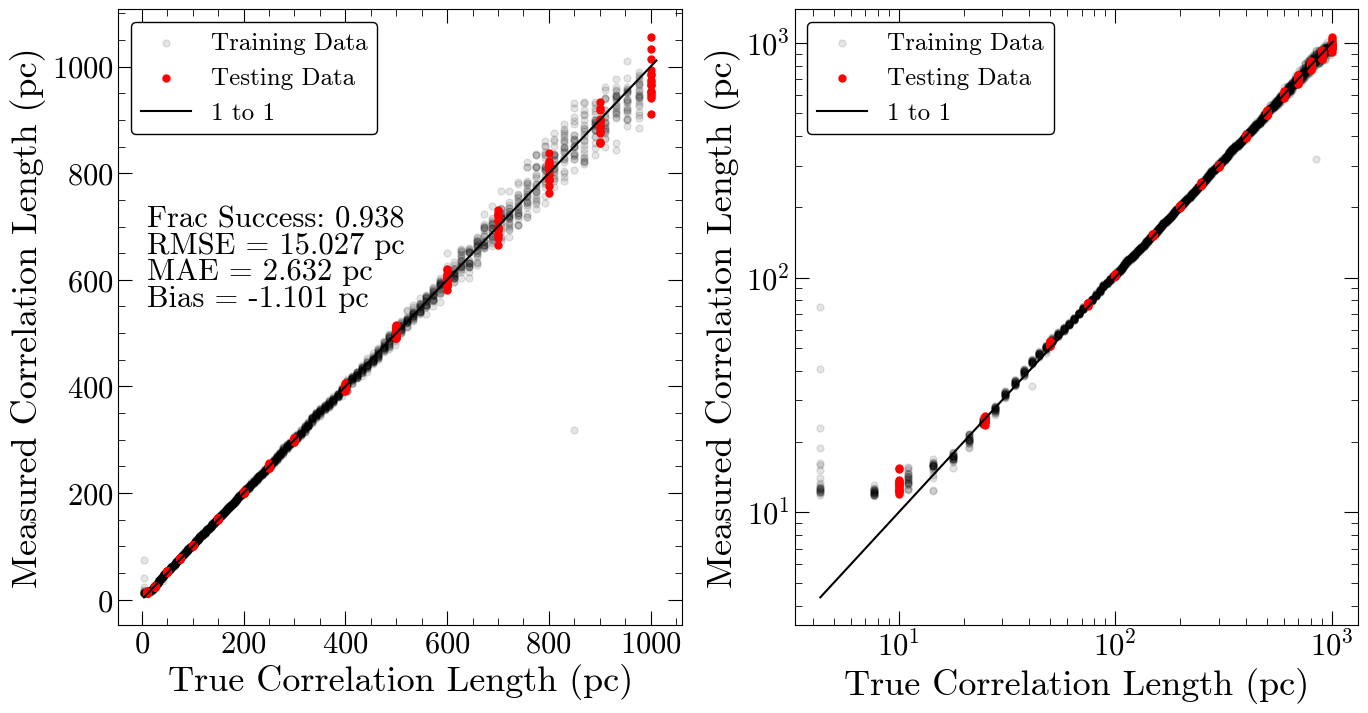

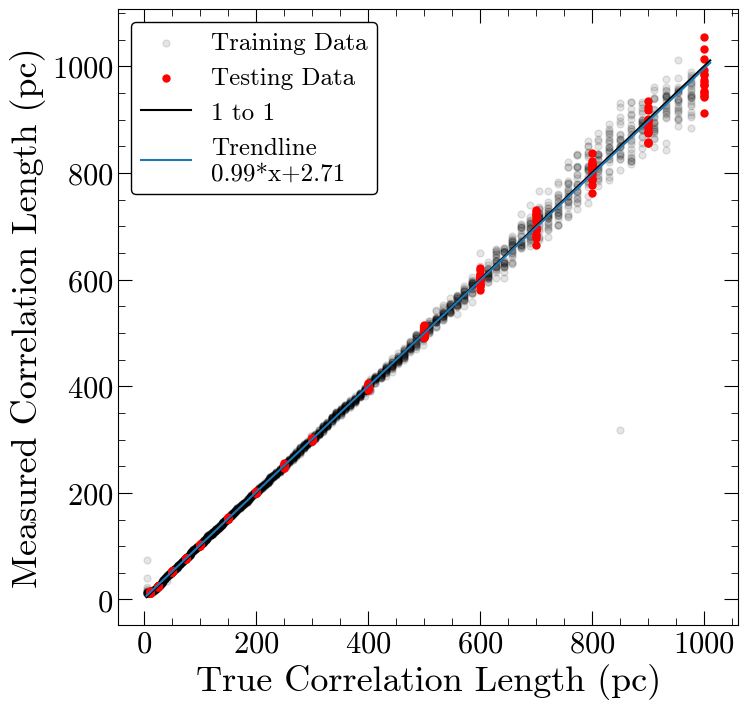

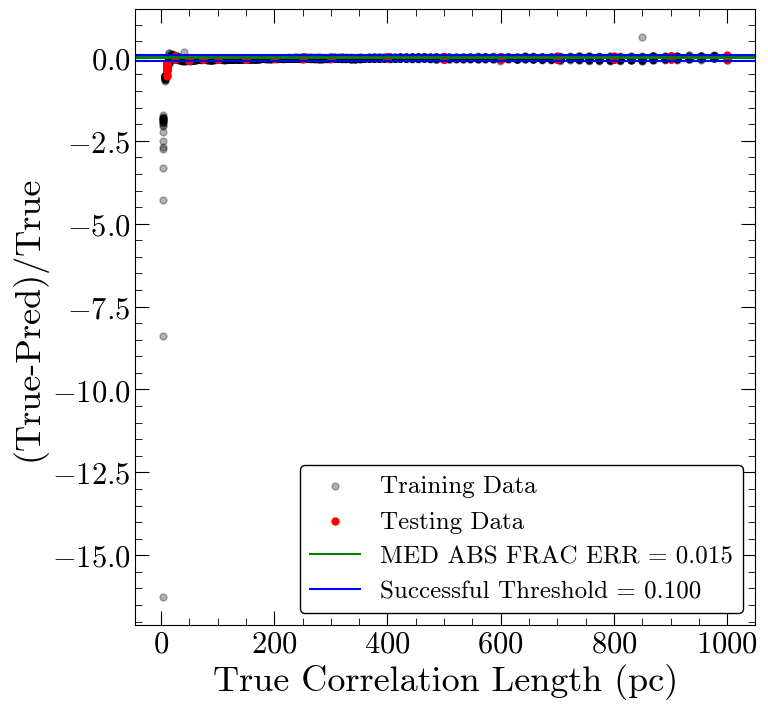

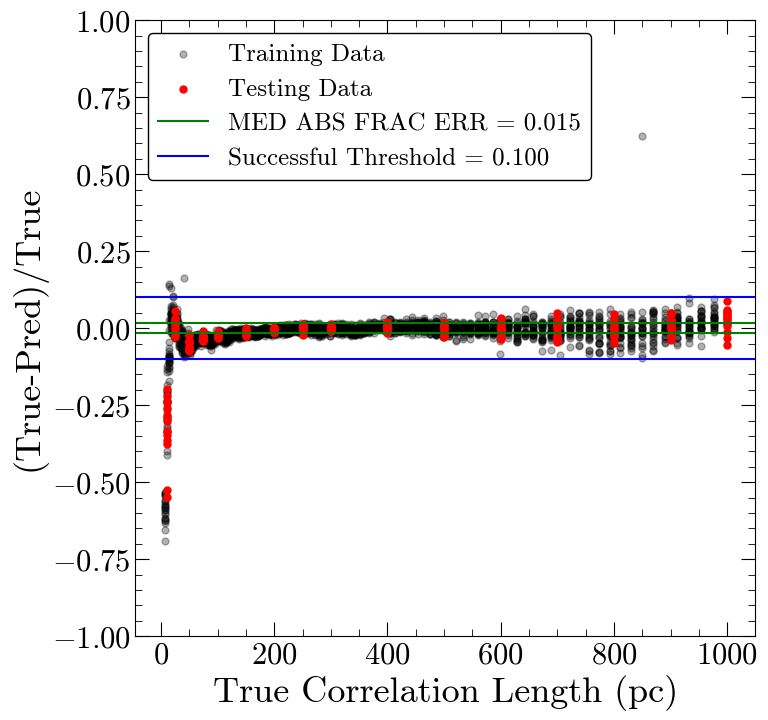

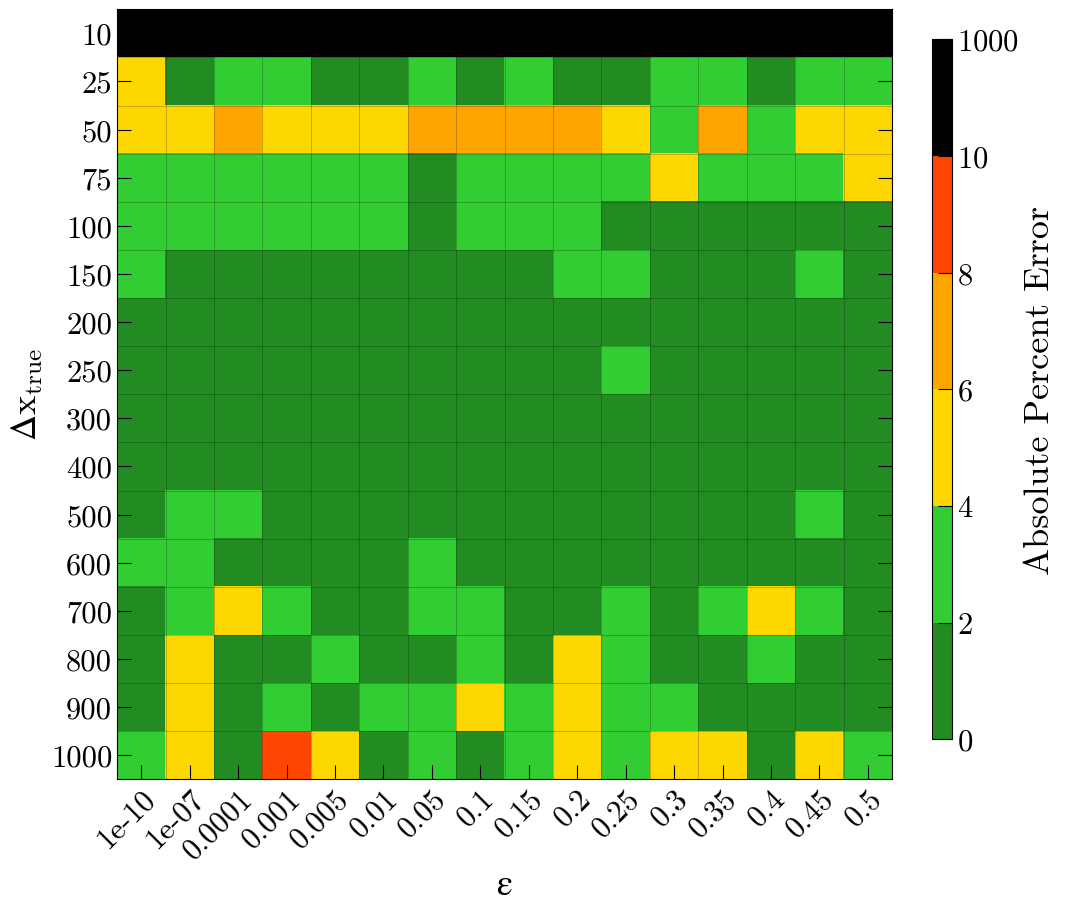

Number of squares with abs percent err>10%,  16


In [60]:
#simple model
model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(x_train.shape[1], 1)),
    MaxPooling1D(2),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(64, activation='relu'), 
    Dense(1) 
])

model.compile(optimizer='adam', loss='mse')

model.fit(x_train, y_train, epochs=100, batch_size=32)

output=test_model(model)

#save the most important stats for all models to compare and find best model
all_model_stats=output

Epoch 1/200
92/92 [==============================] - 0s 2ms/step - loss: 114606.8203
Epoch 2/200
92/92 [==============================] - 0s 2ms/step - loss: 13953.4238
Epoch 3/200
92/92 [==============================] - 0s 2ms/step - loss: 2150.2112
Epoch 4/200
92/92 [==============================] - 0s 2ms/step - loss: 1262.8679
Epoch 5/200
92/92 [==============================] - 0s 2ms/step - loss: 867.6115
Epoch 6/200
92/92 [==============================] - 0s 2ms/step - loss: 656.2624
Epoch 7/200
92/92 [==============================] - 0s 2ms/step - loss: 532.7416
Epoch 8/200
92/92 [==============================] - 0s 2ms/step - loss: 456.3603
Epoch 9/200
92/92 [==============================] - 0s 2ms/step - loss: 423.8196
Epoch 10/200
92/92 [==============================] - 0s 2ms/step - loss: 376.6544
Epoch 11/200
92/92 [==============================] - 0s 2ms/step - loss: 357.2868
Epoch 12/200
92/92 [==============================] - 0s 2ms/step - loss: 343.8816
Epoch 

92/92 [==============================] - 0s 3ms/step - loss: 162.6030
Epoch 197/200
92/92 [==============================] - 0s 2ms/step - loss: 168.5020
Epoch 198/200
92/92 [==============================] - 0s 3ms/step - loss: 146.4436
Epoch 199/200
92/92 [==============================] - 0s 3ms/step - loss: 158.8551
Epoch 200/200
92/92 [==============================] - 0s 2ms/step - loss: 154.4191

Showing the 0 curves that returned NaNs


Empty DataFrame
Columns: [y_true, epsilon, y_pred, abs_frac_err]
Index: []

Training Stats
RMSE: 12.739 pc
MAE: 3.283 pc
BIAS: 2.861 pc
MED FRAC ERR: 0.019 

Training Stats, Successful Fits
Frac Success Fit: 0.945 
RMSE: 12.175 pc
MAE: 3.252 pc
BIAS: 2.783 pc
MED FRAC ERR: 0.018 

Testing Stats
RMSE: 17.197 pc
MAE: 3.882 pc
BIAS: 3.353 pc
MED FRAC ERR: 0.020 

Testing Stats, Successful Fits
Frac Success Fit: 0.898 
RMSE: 18.105 pc
MAE: 4.185 pc
BIAS: 3.353 pc
MED FRAC ERR: 0.017 


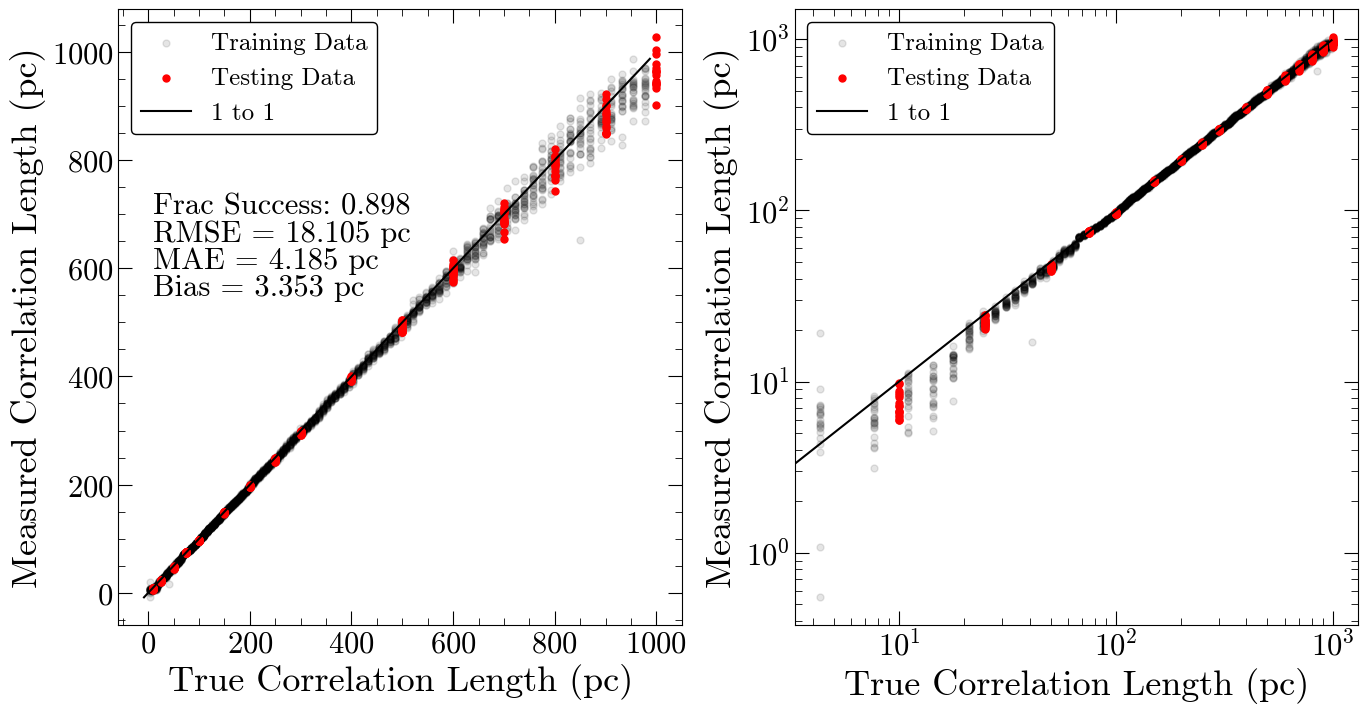

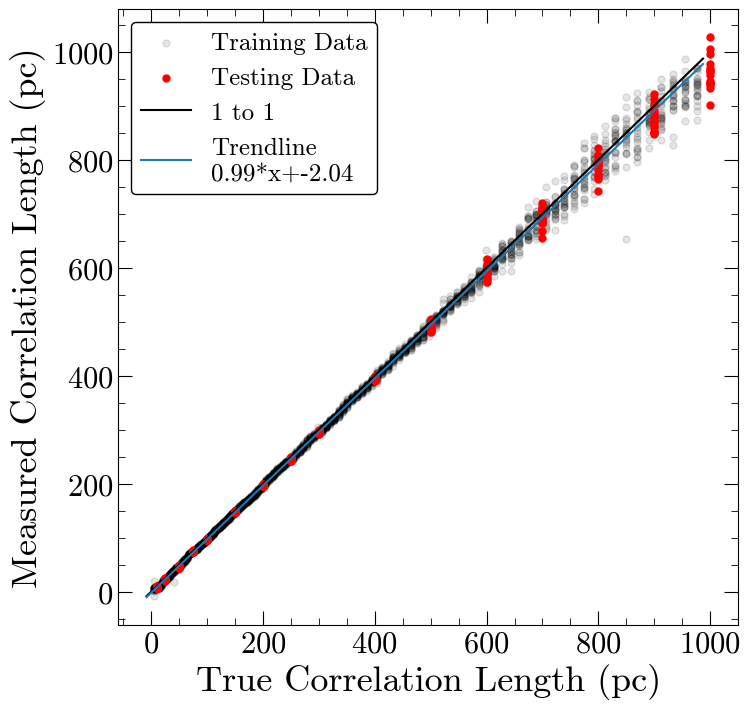

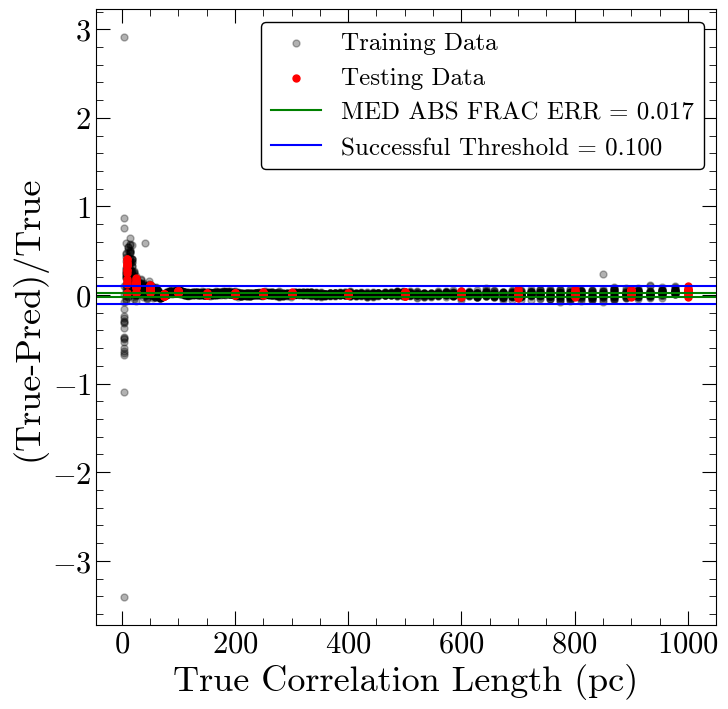

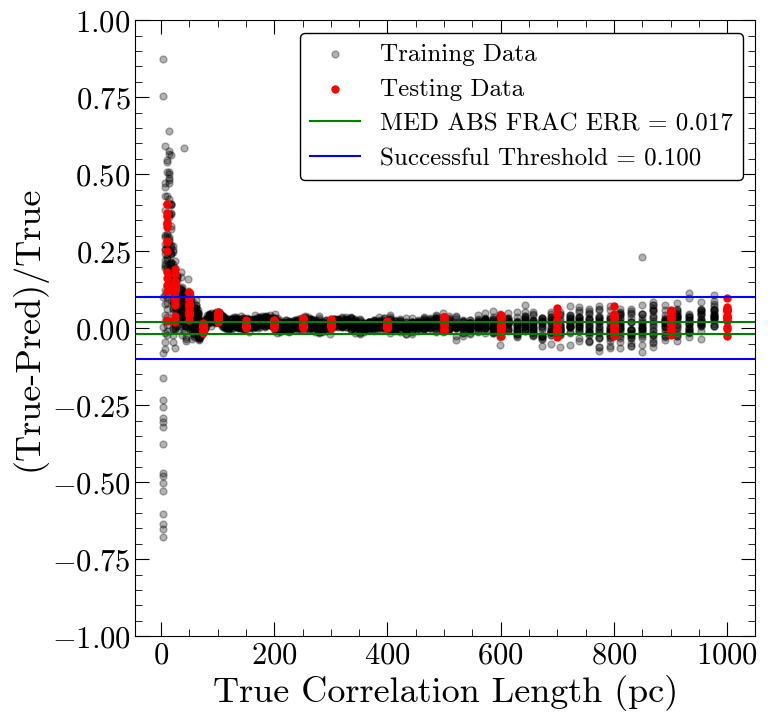

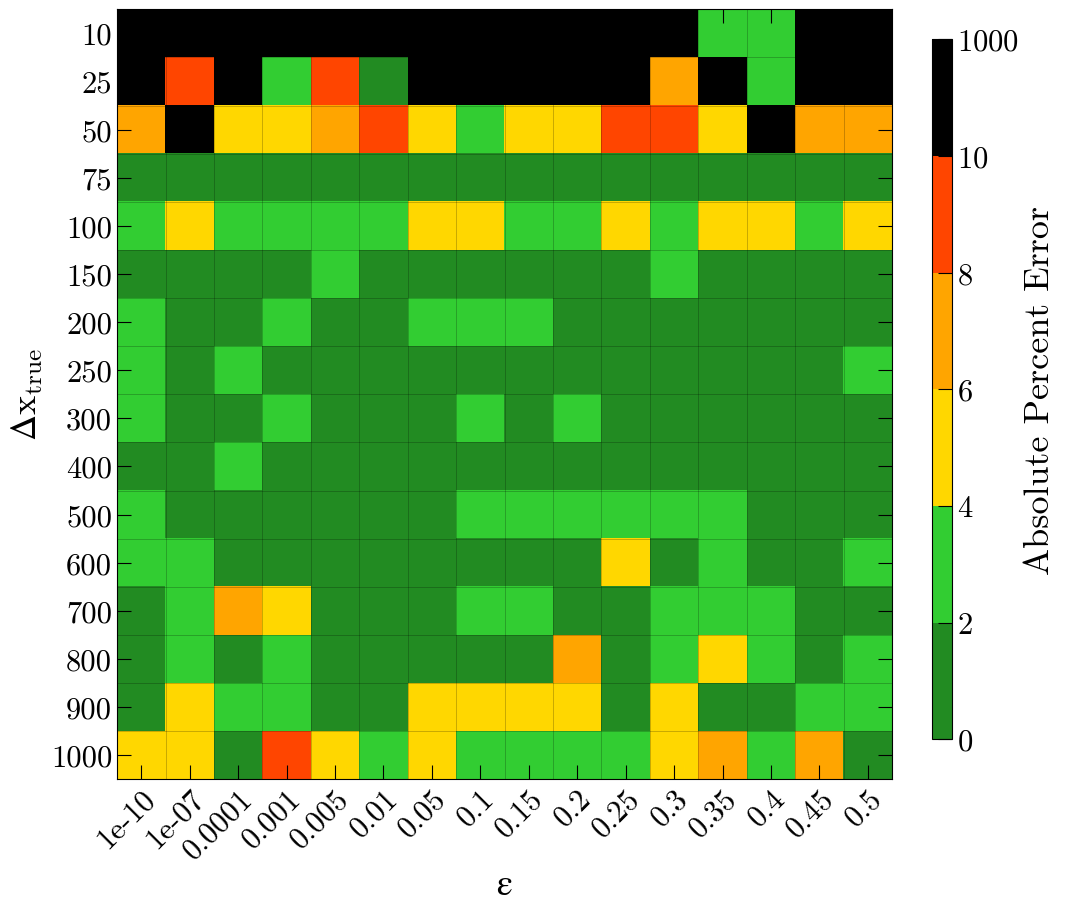

Number of squares with abs percent err>10%,  26


In [61]:
#simple model, run for more epochs
model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(x_train.shape[1], 1)),
    MaxPooling1D(2),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(64, activation='relu'), 
    Dense(1) 
])

model.compile(optimizer='adam', loss='mse')

model.fit(x_train, y_train, epochs=200, batch_size=32)

output=test_model(model)

#save the most important stats
all_model_stats = pd.concat([all_model_stats, output])

Epoch 1/100
92/92 [==============================] - 0s 3ms/step - loss: 80244.2422
Epoch 2/100
92/92 [==============================] - 0s 4ms/step - loss: 3341.1619
Epoch 3/100
92/92 [==============================] - 0s 4ms/step - loss: 1341.4709
Epoch 4/100
92/92 [==============================] - 0s 4ms/step - loss: 854.3517
Epoch 5/100
92/92 [==============================] - 0s 5ms/step - loss: 575.4881
Epoch 6/100
92/92 [==============================] - 0s 4ms/step - loss: 463.0865
Epoch 7/100
92/92 [==============================] - 0s 4ms/step - loss: 375.8960
Epoch 8/100
92/92 [==============================] - 0s 5ms/step - loss: 351.0775
Epoch 9/100
92/92 [==============================] - 0s 4ms/step - loss: 308.3438
Epoch 10/100
92/92 [==============================] - 0s 4ms/step - loss: 302.8955
Epoch 11/100
92/92 [==============================] - 0s 3ms/step - loss: 307.0729
Epoch 12/100
92/92 [==============================] - 0s 3ms/step - loss: 300.0272
Epoch 13/

Empty DataFrame
Columns: [y_true, epsilon, y_pred, abs_frac_err]
Index: []

Training Stats
RMSE: 11.889 pc
MAE: 2.858 pc
BIAS: -1.883 pc
MED FRAC ERR: 0.016 

Training Stats, Successful Fits
Frac Success Fit: 0.980 
RMSE: 11.419 pc
MAE: 2.871 pc
BIAS: -1.909 pc
MED FRAC ERR: 0.016 

Testing Stats
RMSE: 15.855 pc
MAE: 2.719 pc
BIAS: -1.603 pc
MED FRAC ERR: 0.017 

Testing Stats, Successful Fits
Frac Success Fit: 0.965 
RMSE: 16.133 pc
MAE: 2.796 pc
BIAS: -1.656 pc
MED FRAC ERR: 0.017 


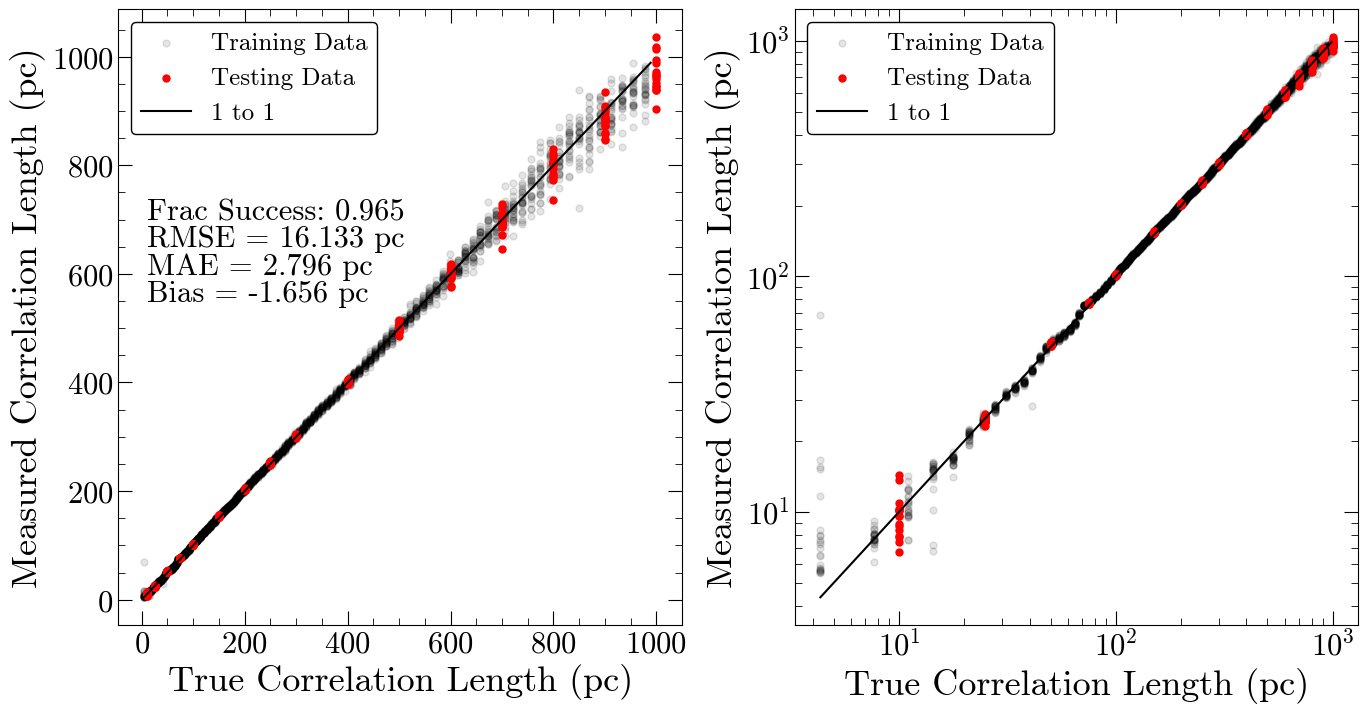

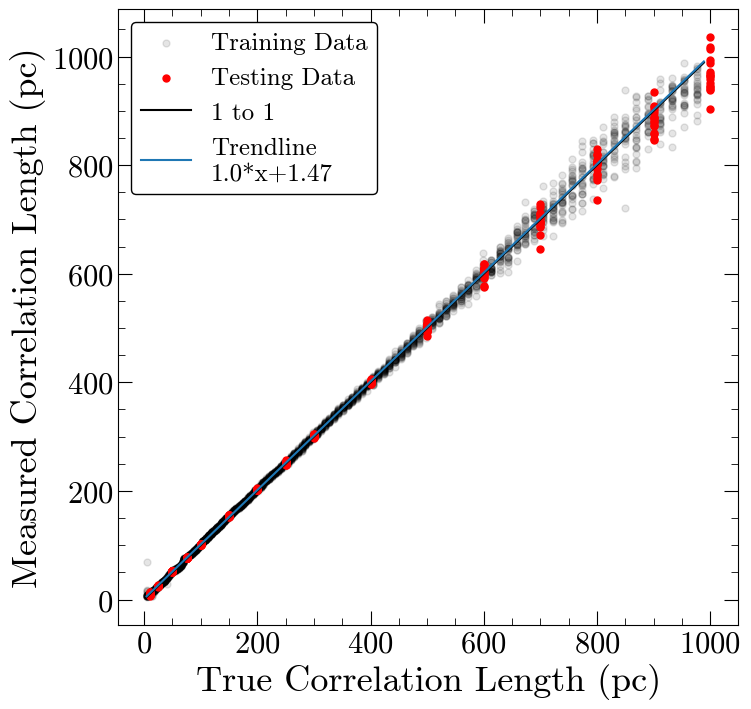

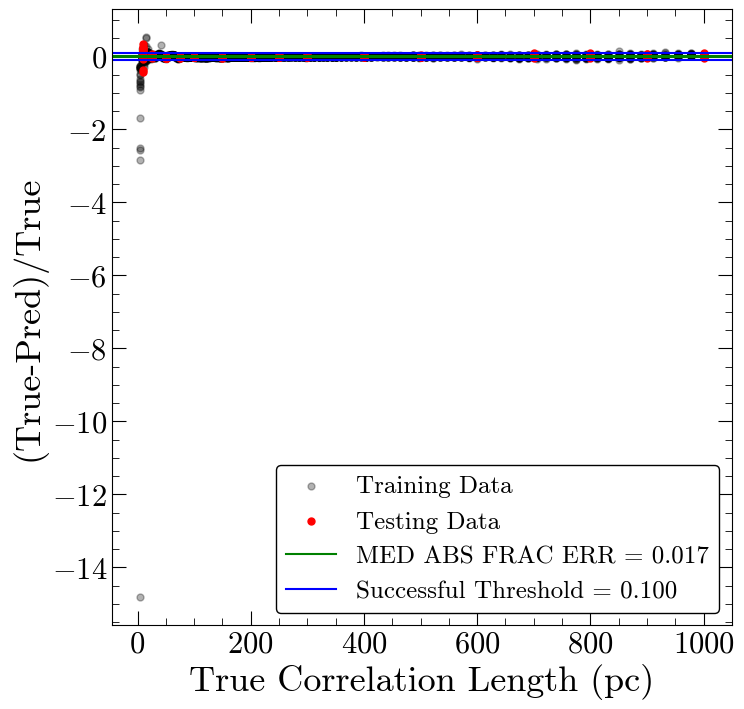

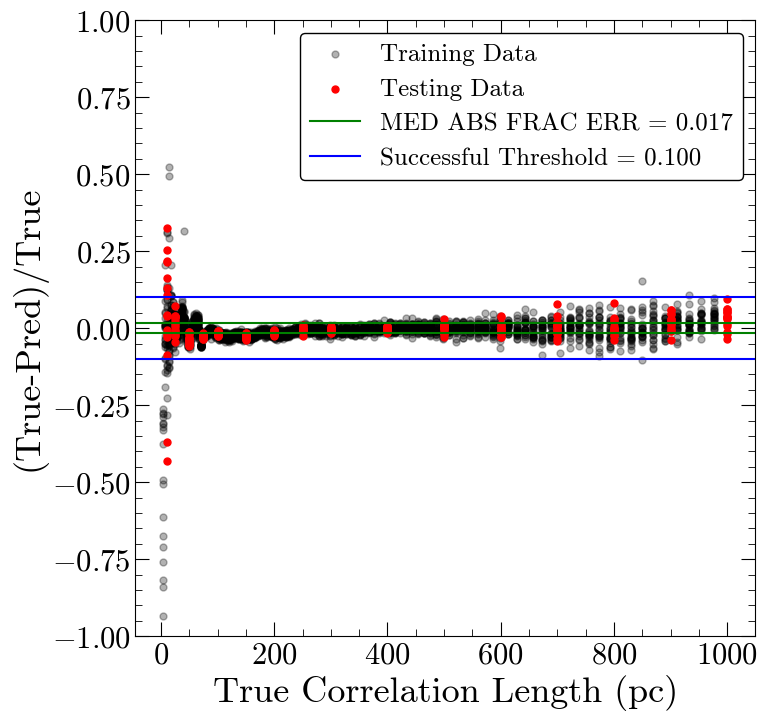

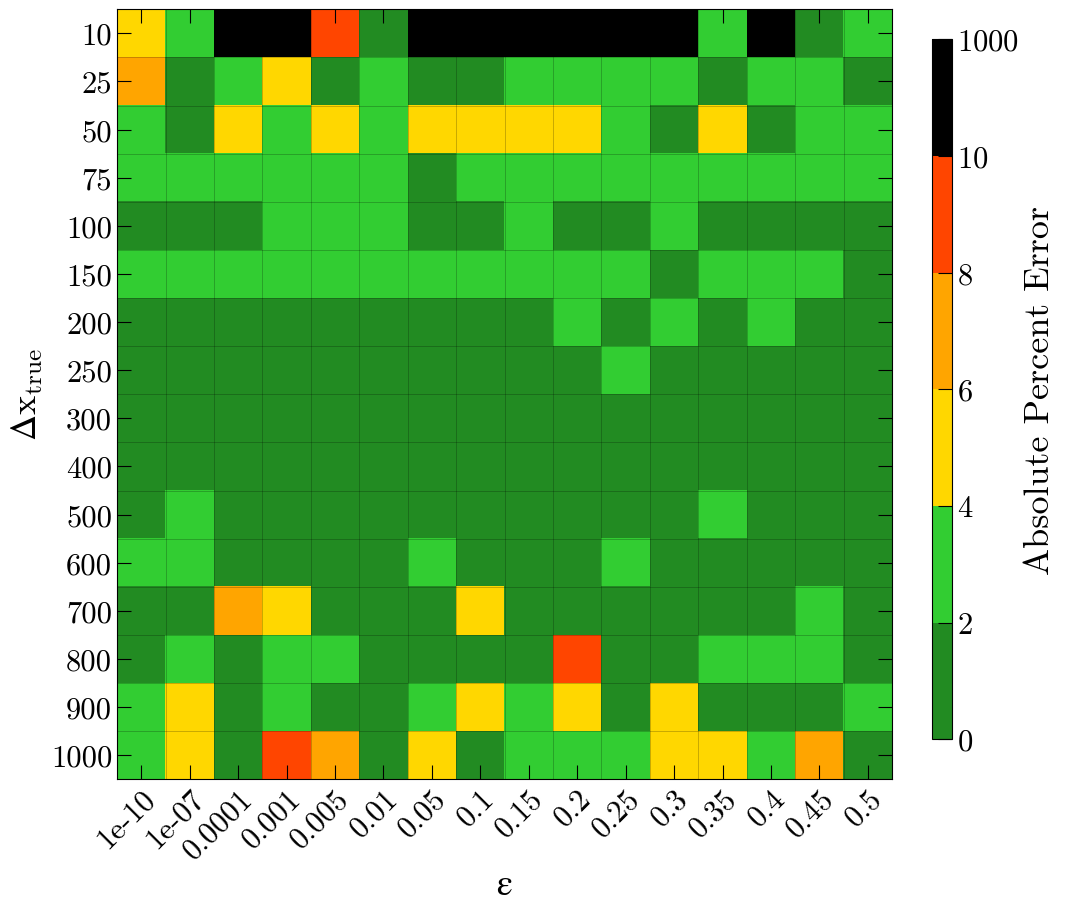

Number of squares with abs percent err>10%,  9


In [62]:
#model with more layers
model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(x_train.shape[1], 1)), 
    MaxPooling1D(2), 
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2), 
    Conv1D(128, 3, activation='relu'), 
    MaxPooling1D(2), 
    Flatten(), 
    Dense(128, activation='relu'),
    Dense(1) 
])

model.compile(optimizer='adam', loss='mse')

model.fit(x_train, y_train, epochs=100, batch_size=32)

output=test_model(model)

#save the most important stats
all_model_stats = pd.concat([all_model_stats, output])

Epoch 1/200
92/92 [==============================] - 1s 4ms/step - loss: 70741.3047
Epoch 2/200
92/92 [==============================] - 0s 4ms/step - loss: 2035.9180
Epoch 3/200
92/92 [==============================] - 0s 4ms/step - loss: 908.3345
Epoch 4/200
92/92 [==============================] - 0s 4ms/step - loss: 556.0197
Epoch 5/200
92/92 [==============================] - 0s 4ms/step - loss: 383.8785
Epoch 6/200
92/92 [==============================] - 0s 3ms/step - loss: 319.7209
Epoch 7/200
92/92 [==============================] - 0s 4ms/step - loss: 348.8553
Epoch 8/200
92/92 [==============================] - 0s 3ms/step - loss: 298.8682
Epoch 9/200
92/92 [==============================] - 0s 4ms/step - loss: 283.3969
Epoch 10/200
92/92 [==============================] - 0s 4ms/step - loss: 276.8362
Epoch 11/200
92/92 [==============================] - 0s 4ms/step - loss: 297.3144
Epoch 12/200
92/92 [==============================] - 0s 5ms/step - loss: 279.6406
Epoch 13/2

92/92 [==============================] - 0s 4ms/step - loss: 190.7041
Epoch 197/200
92/92 [==============================] - 0s 4ms/step - loss: 186.4041
Epoch 198/200
92/92 [==============================] - 0s 4ms/step - loss: 150.1201
Epoch 199/200
92/92 [==============================] - 0s 3ms/step - loss: 169.9308
Epoch 200/200
92/92 [==============================] - 0s 3ms/step - loss: 153.9519

Showing the 0 curves that returned NaNs


Empty DataFrame
Columns: [y_true, epsilon, y_pred, abs_frac_err]
Index: []

Training Stats
RMSE: 12.856 pc
MAE: 1.709 pc
BIAS: -0.630 pc
MED FRAC ERR: 0.011 

Training Stats, Successful Fits
Frac Success Fit: 0.971 
RMSE: 12.630 pc
MAE: 1.649 pc
BIAS: -0.676 pc
MED FRAC ERR: 0.010 

Testing Stats
RMSE: 14.493 pc
MAE: 2.430 pc
BIAS: -0.824 pc
MED FRAC ERR: 0.013 

Testing Stats, Successful Fits
Frac Success Fit: 0.941 
RMSE: 14.915 pc
MAE: 2.407 pc
BIAS: -0.990 pc
MED FRAC ERR: 0.012 


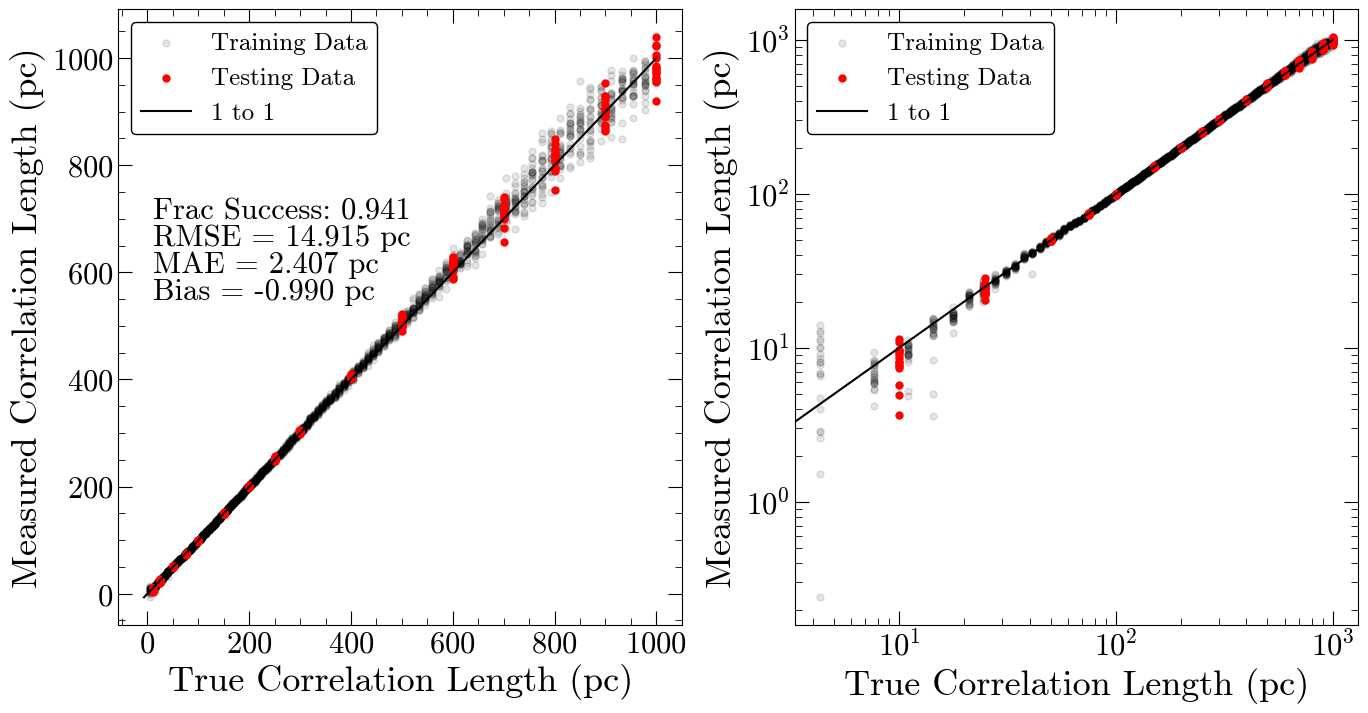

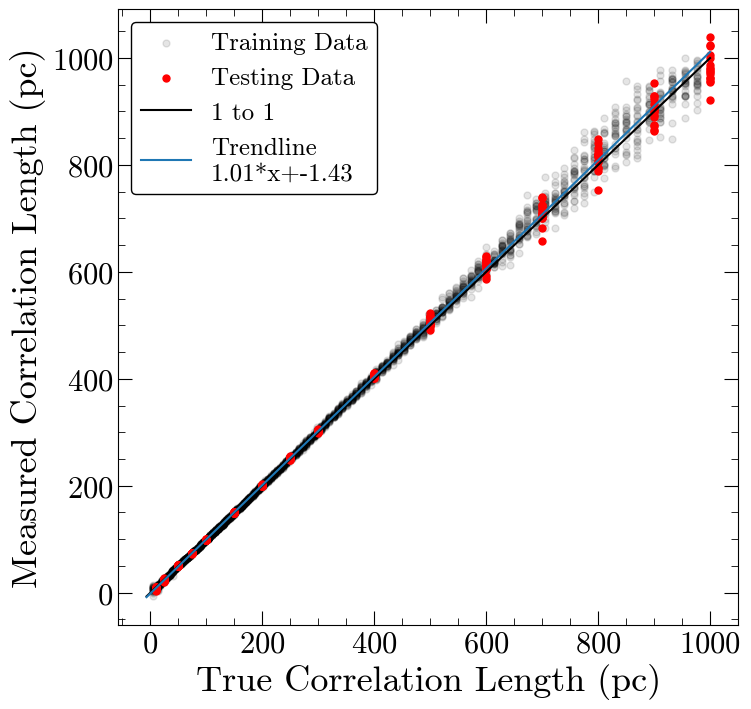

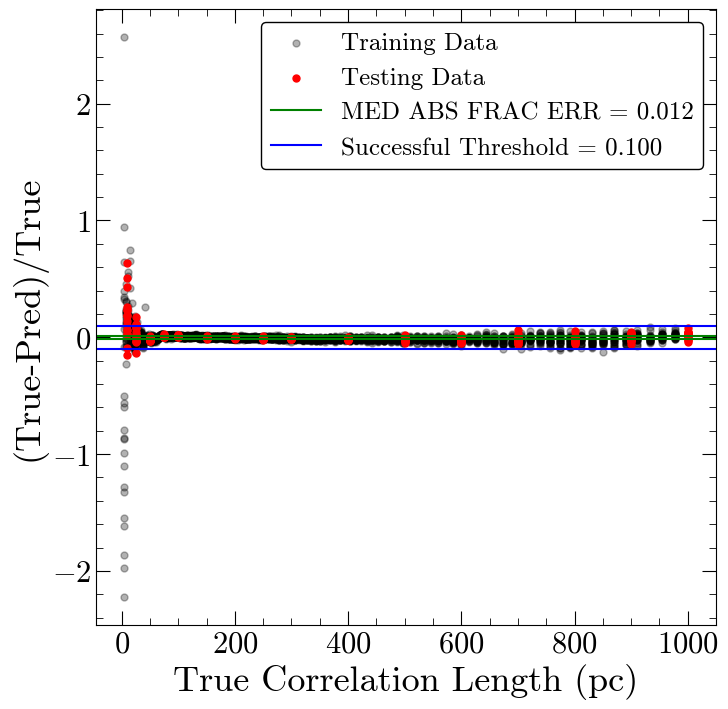

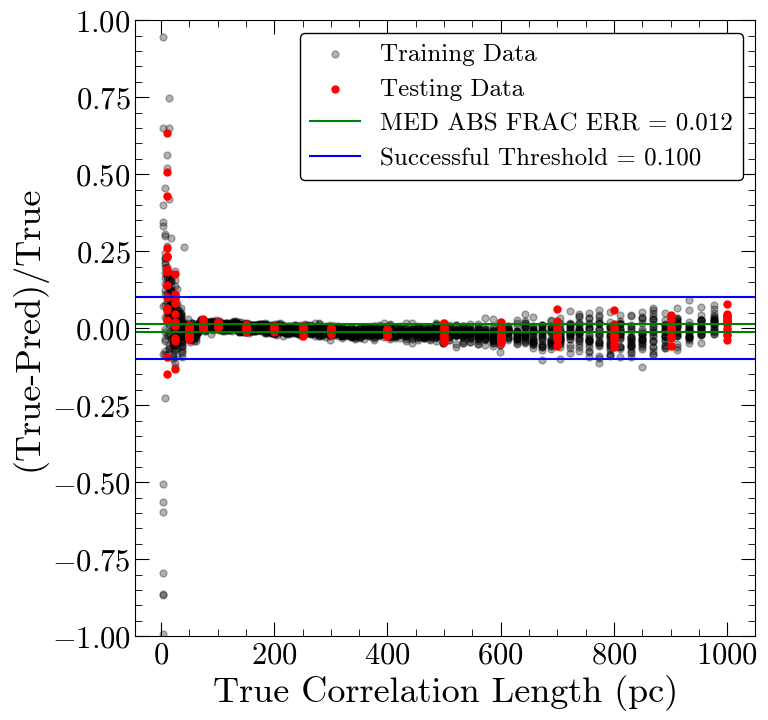

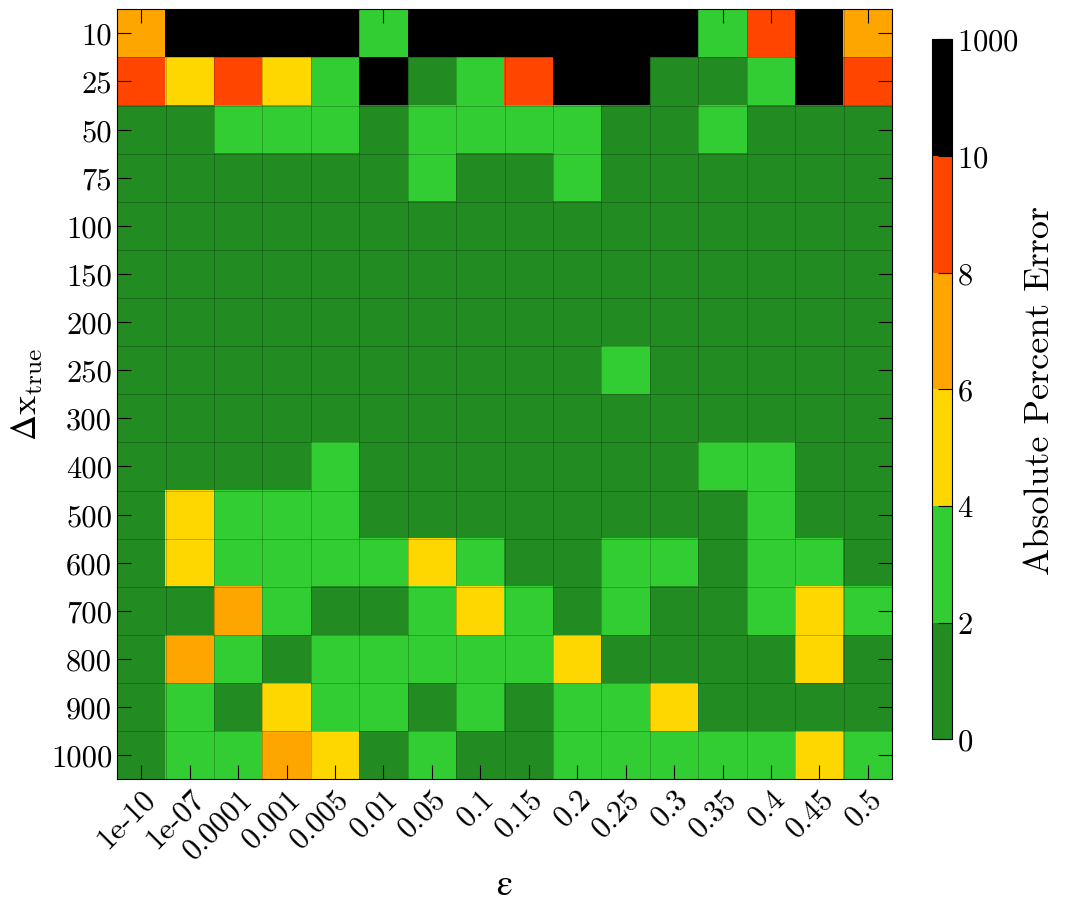

Number of squares with abs percent err>10%,  15


In [63]:
#model with more layers, run for more epochs
model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(x_train.shape[1], 1)), 
    MaxPooling1D(2), 
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2), 
    Conv1D(128, 3, activation='relu'), 
    MaxPooling1D(2), 
    Flatten(), 
    Dense(128, activation='relu'),
    Dense(1) 
])

model.compile(optimizer='adam', loss='mse')

model.fit(x_train, y_train, epochs=200, batch_size=32)

output=test_model(model)

#save the most important stats
all_model_stats = pd.concat([all_model_stats, output])

Epoch 1/100
92/92 [==============================] - 0s 3ms/step - loss: 81768.6172
Epoch 2/100
92/92 [==============================] - 0s 3ms/step - loss: 5272.9331
Epoch 3/100
92/92 [==============================] - 0s 4ms/step - loss: 1254.7286
Epoch 4/100
92/92 [==============================] - 0s 4ms/step - loss: 825.5260
Epoch 5/100
92/92 [==============================] - 0s 3ms/step - loss: 552.3076
Epoch 6/100
92/92 [==============================] - 0s 3ms/step - loss: 421.4231
Epoch 7/100
92/92 [==============================] - 0s 3ms/step - loss: 381.5168
Epoch 8/100
92/92 [==============================] - 0s 3ms/step - loss: 341.8240
Epoch 9/100
92/92 [==============================] - 0s 3ms/step - loss: 319.0456
Epoch 10/100
92/92 [==============================] - 0s 3ms/step - loss: 300.9357
Epoch 11/100
92/92 [==============================] - 0s 3ms/step - loss: 299.4662
Epoch 12/100
92/92 [==============================] - 0s 3ms/step - loss: 304.1952
Epoch 13/

Empty DataFrame
Columns: [y_true, epsilon, y_pred, abs_frac_err]
Index: []

Training Stats
RMSE: 11.896 pc
MAE: 1.778 pc
BIAS: 0.271 pc
MED FRAC ERR: 0.010 

Training Stats, Successful Fits
Frac Success Fit: 0.967 
RMSE: 11.218 pc
MAE: 1.716 pc
BIAS: 0.214 pc
MED FRAC ERR: 0.010 

Testing Stats
RMSE: 14.949 pc
MAE: 1.873 pc
BIAS: 0.171 pc
MED FRAC ERR: 0.011 

Testing Stats, Successful Fits
Frac Success Fit: 0.957 
RMSE: 15.277 pc
MAE: 1.972 pc
BIAS: 0.054 pc
MED FRAC ERR: 0.010 


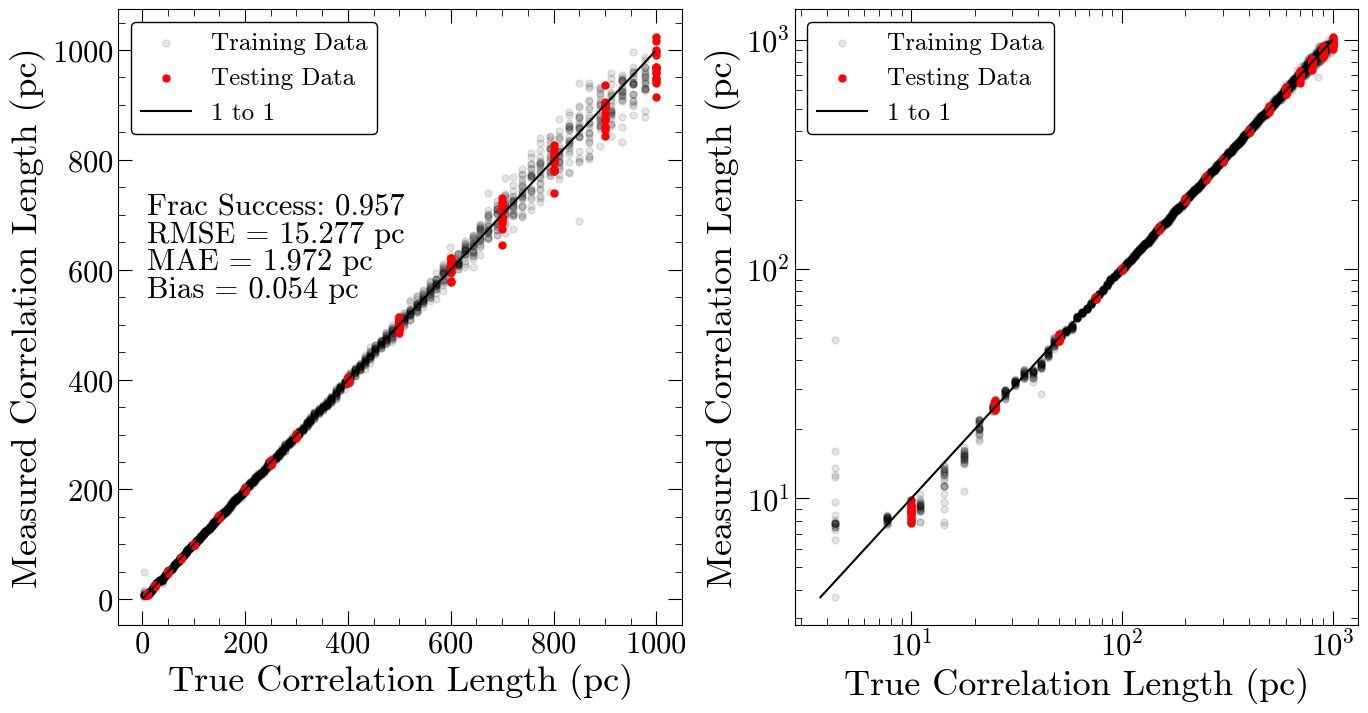

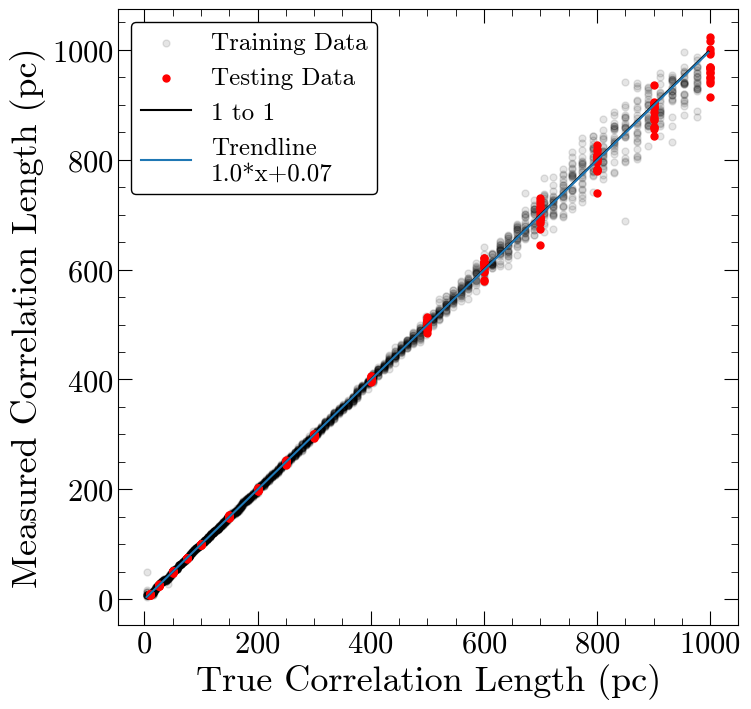

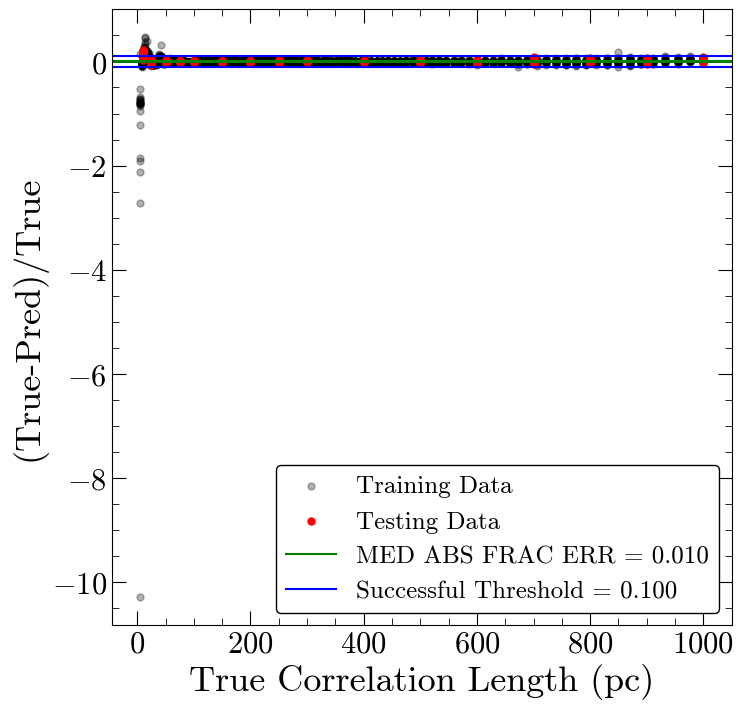

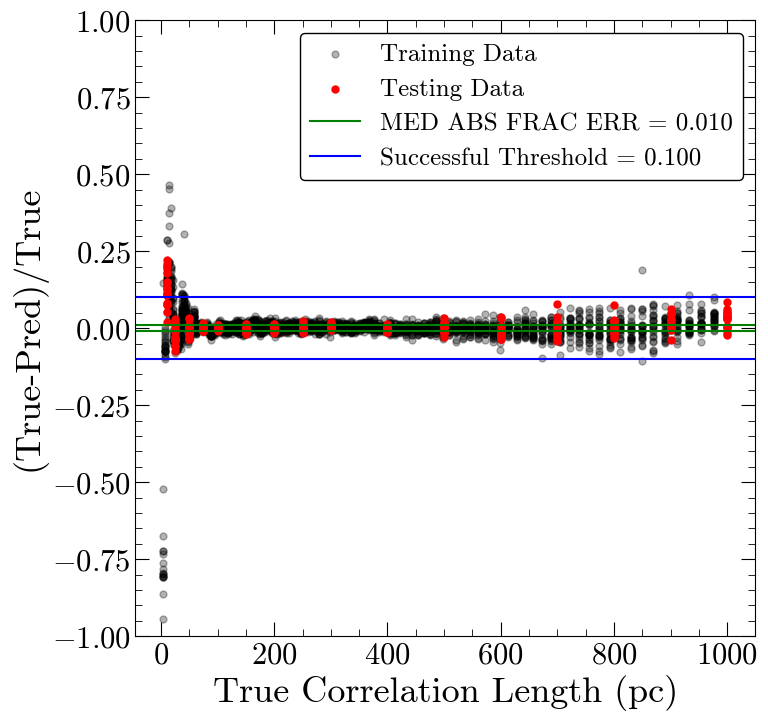

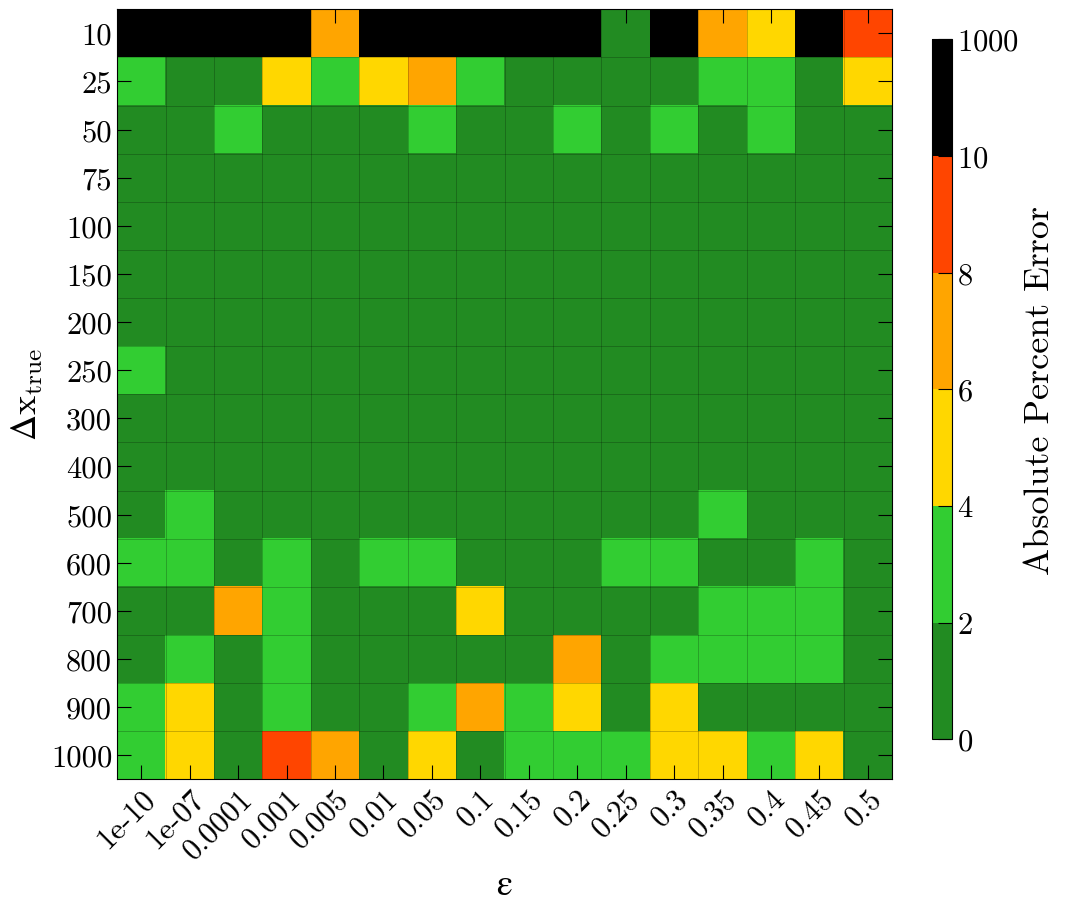

Number of squares with abs percent err>10%,  11


In [64]:
#model with more layers, increase max pooling in first layer
model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(x_train.shape[1], 1)), 
    MaxPooling1D(3), 
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2), 
    Conv1D(128, 3, activation='relu'), 
    MaxPooling1D(2), 
    Flatten(), 
    Dense(128, activation='relu'),
    Dense(1) 
])

model.compile(optimizer='adam', loss='mse')

model.fit(x_train, y_train, epochs=100, batch_size=32)

output=test_model(model)

#save the most important stats
all_model_stats = pd.concat([all_model_stats, output])

Epoch 1/100
92/92 [==============================] - 0s 2ms/step - loss: 79569.6484
Epoch 2/100
92/92 [==============================] - 0s 3ms/step - loss: 3150.0315
Epoch 3/100
92/92 [==============================] - 0s 3ms/step - loss: 847.4052
Epoch 4/100
92/92 [==============================] - 0s 3ms/step - loss: 602.2239
Epoch 5/100
92/92 [==============================] - 0s 3ms/step - loss: 499.5348
Epoch 6/100
92/92 [==============================] - 0s 4ms/step - loss: 385.1070
Epoch 7/100
92/92 [==============================] - 0s 4ms/step - loss: 330.8569
Epoch 8/100
92/92 [==============================] - 0s 4ms/step - loss: 323.5748
Epoch 9/100
92/92 [==============================] - 0s 4ms/step - loss: 332.1608
Epoch 10/100
92/92 [==============================] - 0s 4ms/step - loss: 301.8731
Epoch 11/100
92/92 [==============================] - 0s 4ms/step - loss: 294.9429
Epoch 12/100
92/92 [==============================] - 0s 4ms/step - loss: 292.0066
Epoch 13/1

Empty DataFrame
Columns: [y_true, epsilon, y_pred, abs_frac_err]
Index: []

Training Stats
RMSE: 11.614 pc
MAE: 2.351 pc
BIAS: 1.538 pc
MED FRAC ERR: 0.014 

Training Stats, Successful Fits
Frac Success Fit: 0.975 
RMSE: 11.331 pc
MAE: 2.351 pc
BIAS: 1.565 pc
MED FRAC ERR: 0.014 

Testing Stats
RMSE: 15.416 pc
MAE: 2.690 pc
BIAS: 1.274 pc
MED FRAC ERR: 0.016 

Testing Stats, Successful Fits
Frac Success Fit: 0.984 
RMSE: 15.534 pc
MAE: 2.690 pc
BIAS: 1.310 pc
MED FRAC ERR: 0.016 


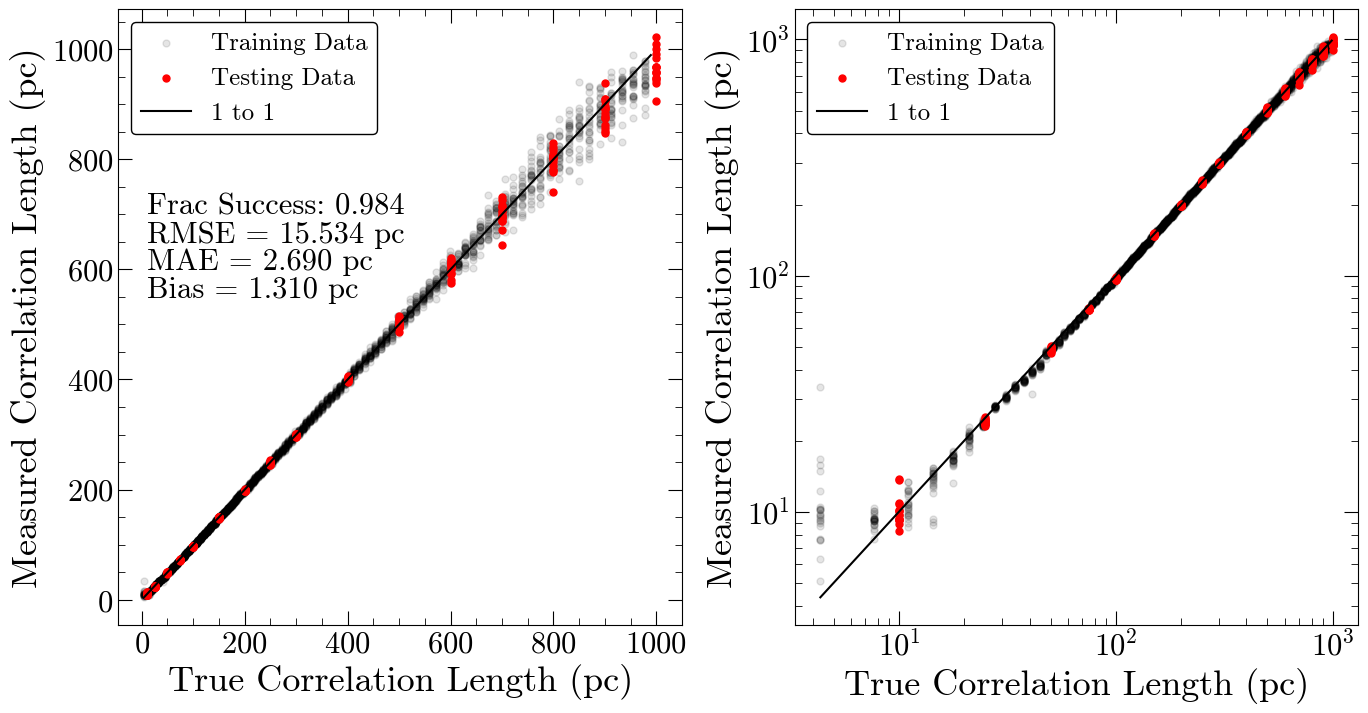

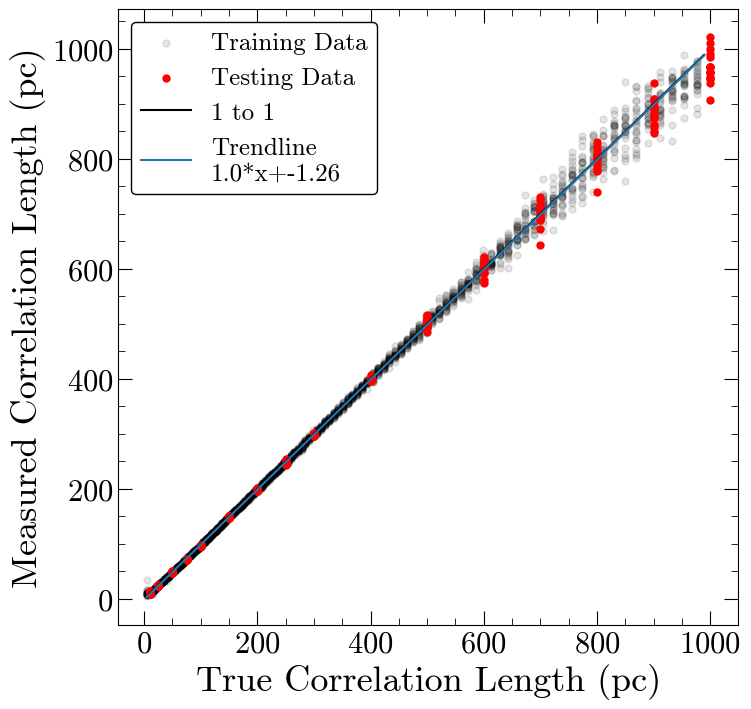

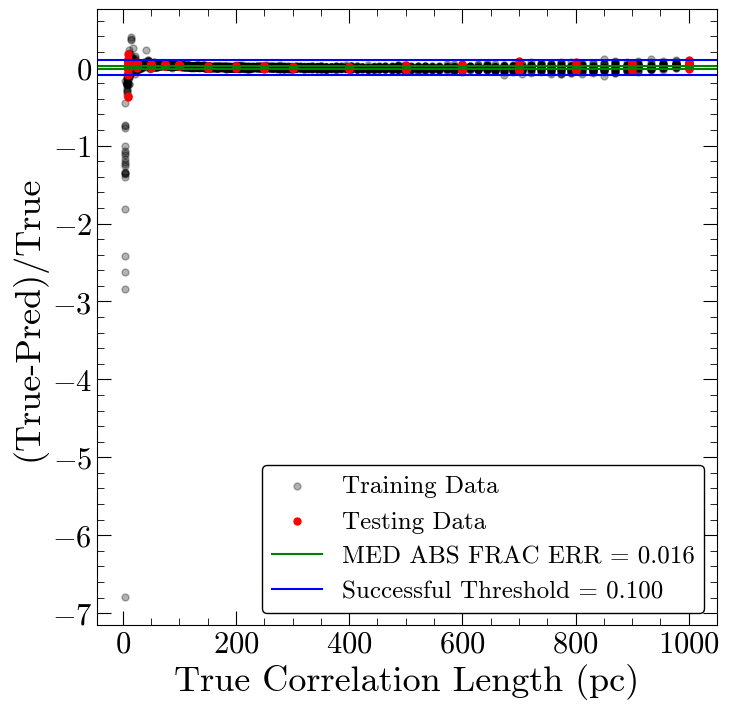

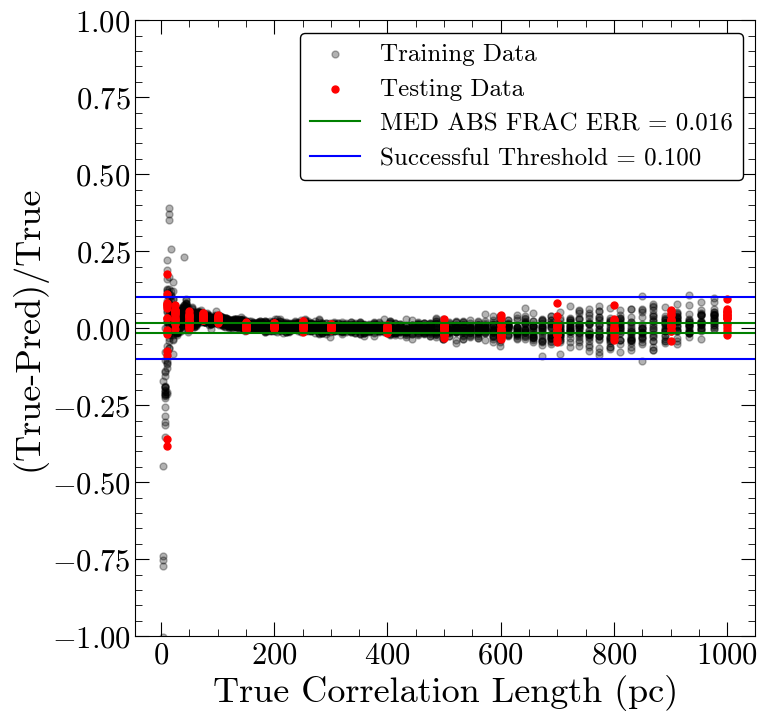

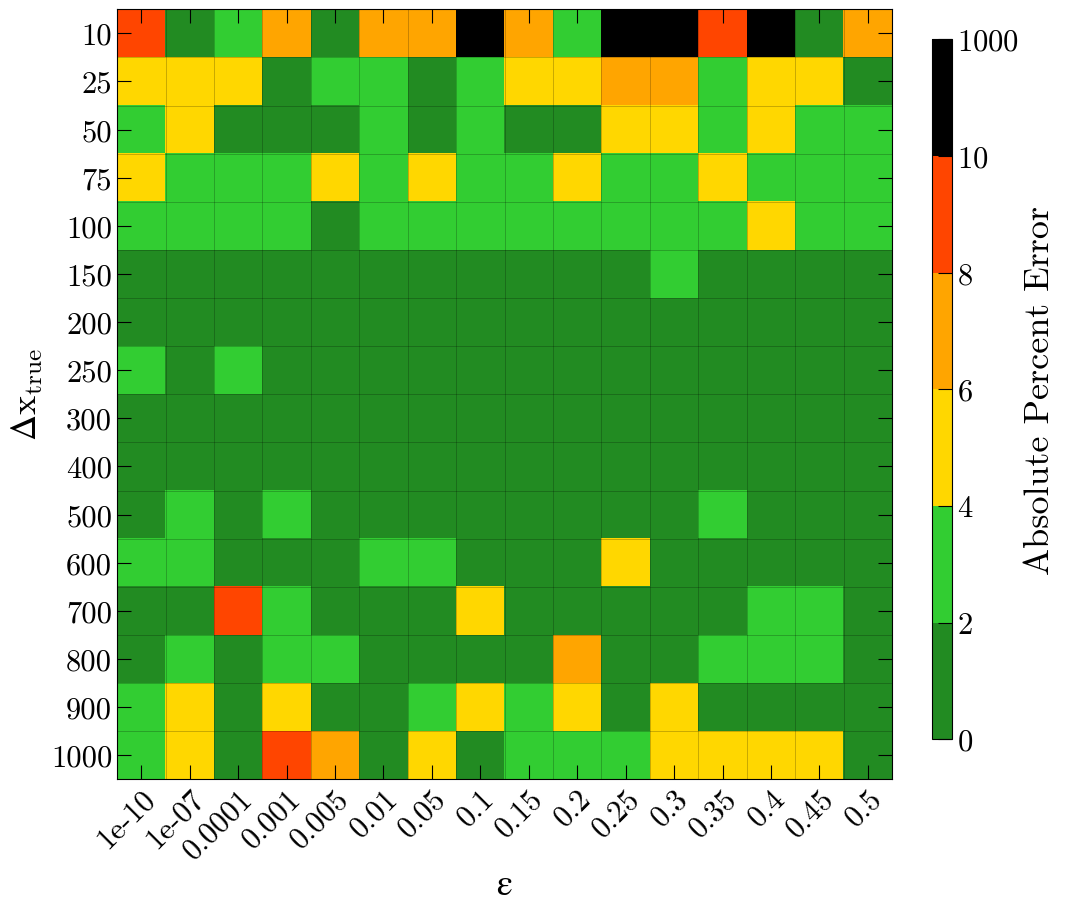

Number of squares with abs percent err>10%,  4


In [65]:
#model with more layers, increase max pooling and kernel size in first layer
model = Sequential([
    Conv1D(32, 5, activation='relu', input_shape=(x_train.shape[1], 1)), 
    MaxPooling1D(3), 
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2), 
    Conv1D(128, 3, activation='relu'), 
    MaxPooling1D(2), 
    Flatten(), 
    Dense(128, activation='relu'),
    Dense(1) 
])

model.compile(optimizer='adam', loss='mse')

model.fit(x_train, y_train, epochs=100, batch_size=32)

output=test_model(model)

#save the most important stats
all_model_stats = pd.concat([all_model_stats, output])

Epoch 1/200
92/92 [==============================] - 0s 2ms/step - loss: 77309.2500
Epoch 2/200
92/92 [==============================] - 0s 2ms/step - loss: 2556.8921
Epoch 3/200
92/92 [==============================] - 0s 3ms/step - loss: 683.9034
Epoch 4/200
92/92 [==============================] - 0s 3ms/step - loss: 481.8349
Epoch 5/200
92/92 [==============================] - 0s 3ms/step - loss: 358.6850
Epoch 6/200
92/92 [==============================] - 0s 3ms/step - loss: 345.4518
Epoch 7/200
92/92 [==============================] - 0s 3ms/step - loss: 315.9338
Epoch 8/200
92/92 [==============================] - 0s 3ms/step - loss: 328.1546
Epoch 9/200
92/92 [==============================] - 0s 3ms/step - loss: 306.8672
Epoch 10/200
92/92 [==============================] - 0s 3ms/step - loss: 304.9918
Epoch 11/200
92/92 [==============================] - 0s 2ms/step - loss: 299.5842
Epoch 12/200
92/92 [==============================] - 0s 2ms/step - loss: 280.8913
Epoch 13/2

92/92 [==============================] - 0s 4ms/step - loss: 192.6014
Epoch 197/200
92/92 [==============================] - 0s 3ms/step - loss: 159.6069
Epoch 198/200
92/92 [==============================] - 0s 2ms/step - loss: 180.1825
Epoch 199/200
92/92 [==============================] - 0s 2ms/step - loss: 166.5203
Epoch 200/200
92/92 [==============================] - 0s 2ms/step - loss: 162.8397

Showing the 0 curves that returned NaNs


Empty DataFrame
Columns: [y_true, epsilon, y_pred, abs_frac_err]
Index: []

Training Stats
RMSE: 11.451 pc
MAE: 1.575 pc
BIAS: 0.261 pc
MED FRAC ERR: 0.009 

Training Stats, Successful Fits
Frac Success Fit: 0.970 
RMSE: 11.324 pc
MAE: 1.533 pc
BIAS: 0.212 pc
MED FRAC ERR: 0.009 

Testing Stats
RMSE: 16.149 pc
MAE: 1.767 pc
BIAS: 0.745 pc
MED FRAC ERR: 0.012 

Testing Stats, Successful Fits
Frac Success Fit: 0.965 
RMSE: 16.438 pc
MAE: 1.833 pc
BIAS: 0.703 pc
MED FRAC ERR: 0.011 


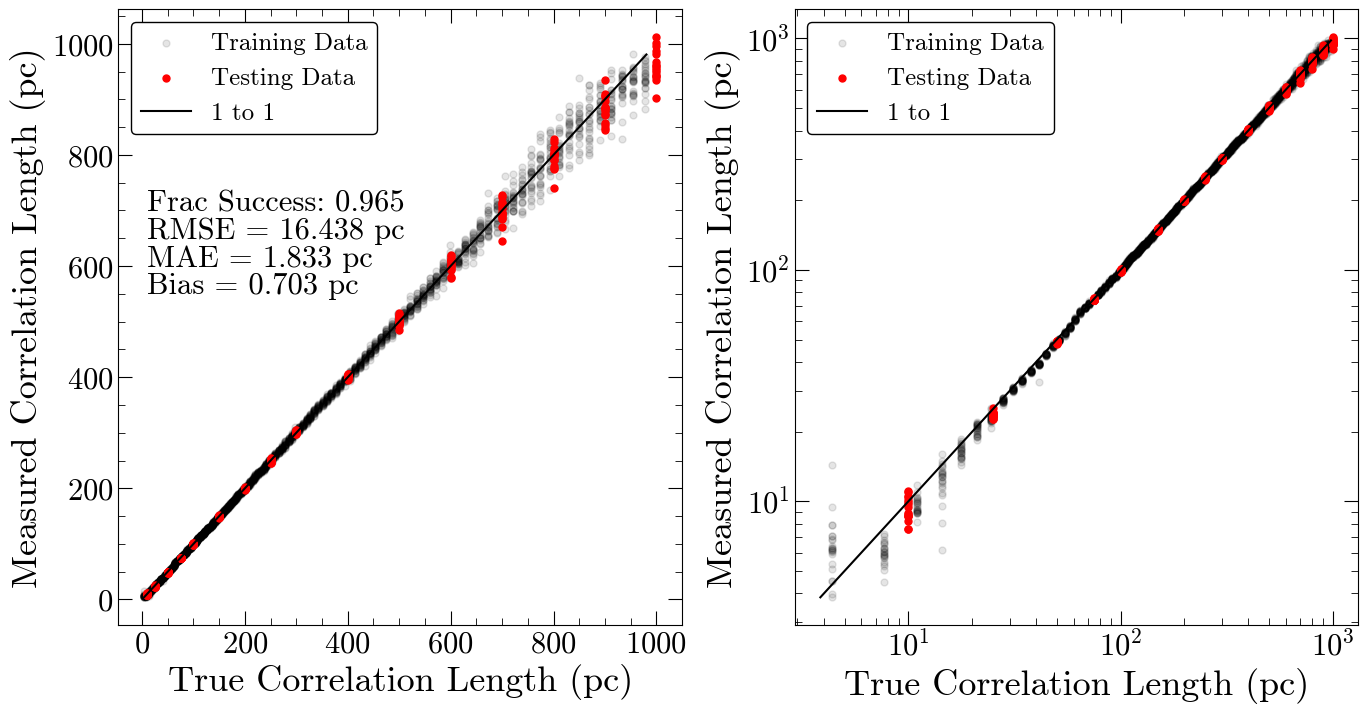

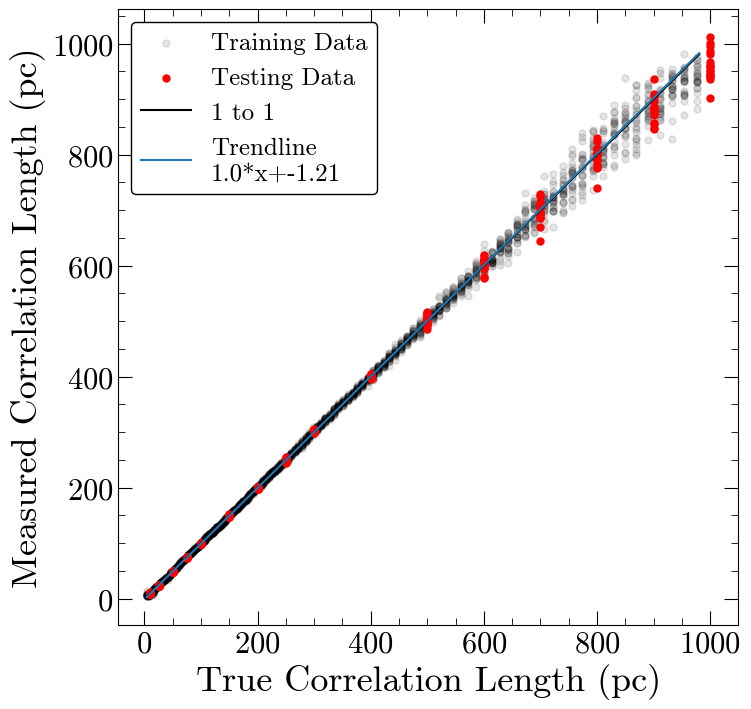

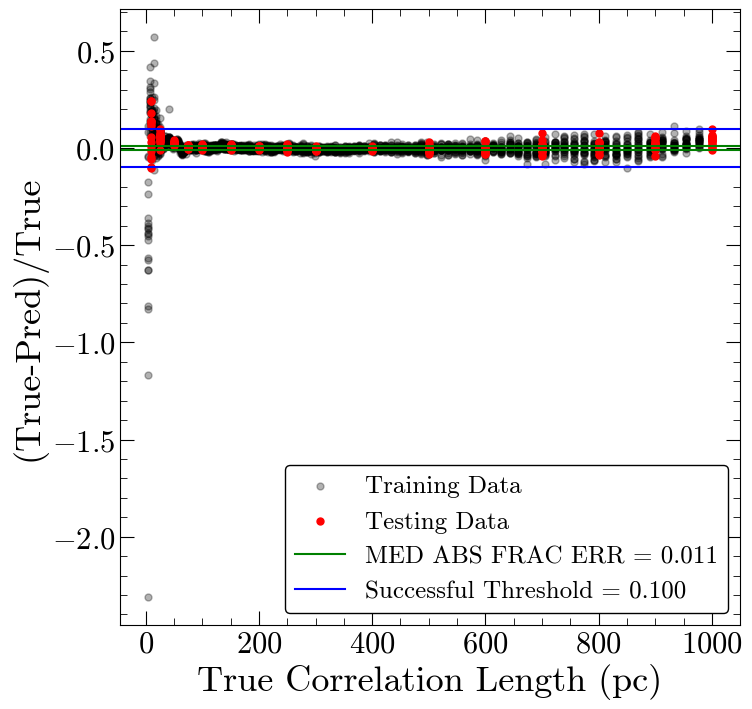

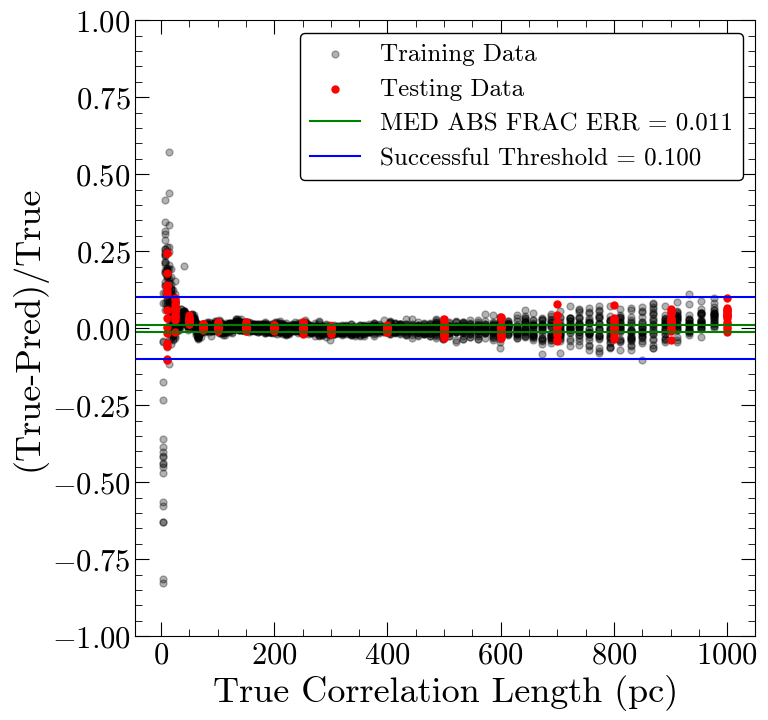

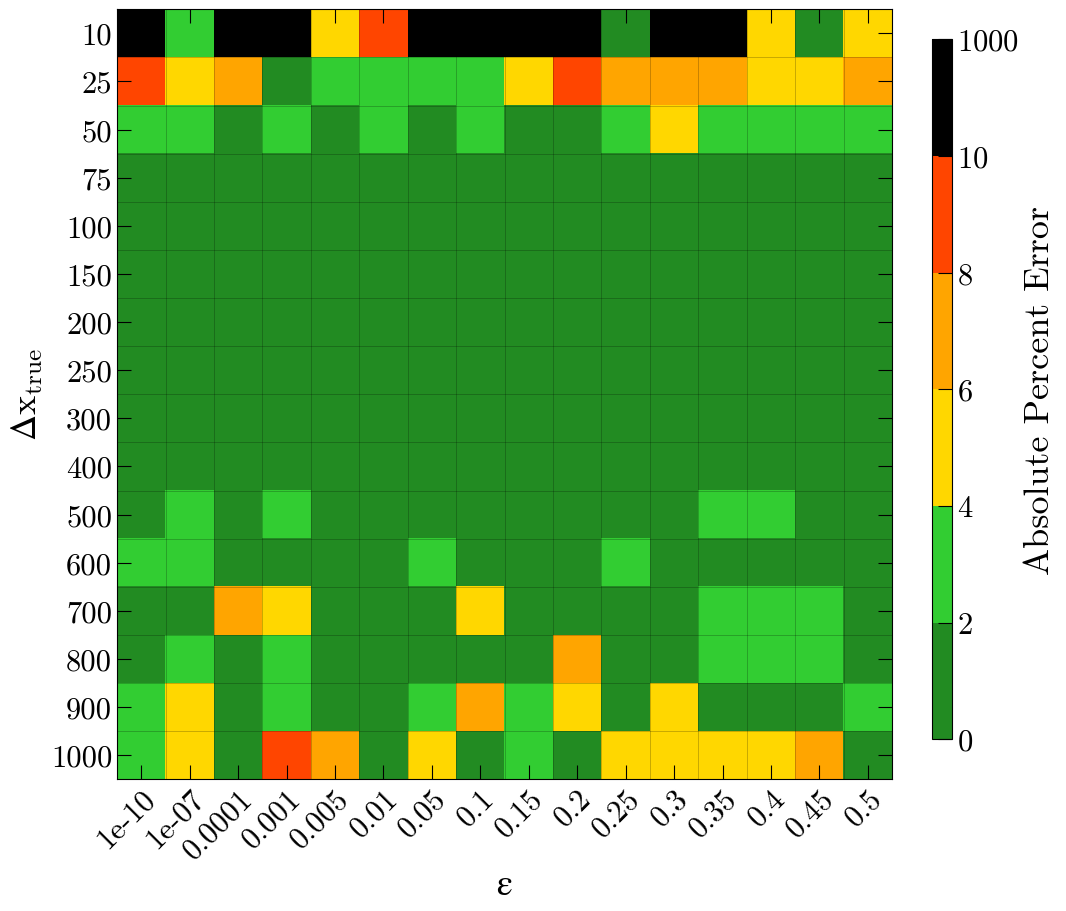

Number of squares with abs percent err>10%,  9


In [66]:
#model with more layers, run for more epochs, increase max pooling and kernel size in first layer
model = Sequential([
    Conv1D(32, 5, activation='relu', input_shape=(x_train.shape[1], 1)), 
    MaxPooling1D(3), 
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2), 
    Conv1D(128, 3, activation='relu'), 
    MaxPooling1D(2), 
    Flatten(), 
    Dense(128, activation='relu'),
    Dense(1) 
])

model.compile(optimizer='adam', loss='mse')

model.fit(x_train, y_train, epochs=200, batch_size=32)

output=test_model(model)

#save the most important stats
all_model_stats = pd.concat([all_model_stats, output])

Epoch 1/400
92/92 [==============================] - 0s 3ms/step - loss: 77727.2734
Epoch 2/400
92/92 [==============================] - 0s 4ms/step - loss: 2800.3838
Epoch 3/400
92/92 [==============================] - 0s 3ms/step - loss: 1324.6719
Epoch 4/400
92/92 [==============================] - 0s 4ms/step - loss: 925.1895
Epoch 5/400
92/92 [==============================] - 0s 5ms/step - loss: 709.8413
Epoch 6/400
92/92 [==============================] - 0s 4ms/step - loss: 606.6402
Epoch 7/400
92/92 [==============================] - 0s 4ms/step - loss: 491.0786
Epoch 8/400
92/92 [==============================] - 0s 4ms/step - loss: 422.7109
Epoch 9/400
92/92 [==============================] - 0s 3ms/step - loss: 383.3555
Epoch 10/400
92/92 [==============================] - 0s 3ms/step - loss: 370.7785
Epoch 11/400
92/92 [==============================] - 0s 4ms/step - loss: 348.4688
Epoch 12/400
92/92 [==============================] - 0s 3ms/step - loss: 312.8040
Epoch 13/

92/92 [==============================] - 0s 3ms/step - loss: 162.9581
Epoch 197/400
92/92 [==============================] - 0s 3ms/step - loss: 206.6751
Epoch 198/400
92/92 [==============================] - 0s 3ms/step - loss: 181.7487
Epoch 199/400
92/92 [==============================] - 0s 3ms/step - loss: 190.3567
Epoch 200/400
92/92 [==============================] - 0s 3ms/step - loss: 163.0046
Epoch 201/400
92/92 [==============================] - 0s 3ms/step - loss: 162.4259
Epoch 202/400
92/92 [==============================] - 0s 3ms/step - loss: 148.1439
Epoch 203/400
92/92 [==============================] - 0s 3ms/step - loss: 170.7142
Epoch 204/400
92/92 [==============================] - 0s 3ms/step - loss: 187.6085
Epoch 205/400
92/92 [==============================] - 0s 3ms/step - loss: 149.8551
Epoch 206/400
92/92 [==============================] - 0s 3ms/step - loss: 162.2916
Epoch 207/400
92/92 [==============================] - 0s 3ms/step - loss: 170.2302
Epoch 

92/92 [==============================] - 0s 3ms/step - loss: 181.5979
Epoch 391/400
92/92 [==============================] - 0s 3ms/step - loss: 149.0205
Epoch 392/400
92/92 [==============================] - 0s 3ms/step - loss: 180.6141
Epoch 393/400
92/92 [==============================] - 0s 3ms/step - loss: 143.7266
Epoch 394/400
92/92 [==============================] - 0s 3ms/step - loss: 176.7227
Epoch 395/400
92/92 [==============================] - 0s 4ms/step - loss: 225.9028
Epoch 396/400
92/92 [==============================] - 0s 3ms/step - loss: 160.7595
Epoch 397/400
92/92 [==============================] - 0s 3ms/step - loss: 145.1073
Epoch 398/400
92/92 [==============================] - 0s 3ms/step - loss: 166.8207
Epoch 399/400
92/92 [==============================] - 0s 4ms/step - loss: 148.9519
Epoch 400/400
92/92 [==============================] - 0s 4ms/step - loss: 135.0006

Showing the 0 curves that returned NaNs


Empty DataFrame
Columns: [y_true, epsilon, y_pred, abs_frac_err]
Index: []

Training Stats
RMSE: 11.069 pc
MAE: 1.284 pc
BIAS: 0.093 pc
MED FRAC ERR: 0.008 

Training Stats, Successful Fits
Frac Success Fit: 0.986 
RMSE: 10.984 pc
MAE: 1.269 pc
BIAS: 0.120 pc
MED FRAC ERR: 0.008 

Testing Stats
RMSE: 15.117 pc
MAE: 1.498 pc
BIAS: -0.043 pc
MED FRAC ERR: 0.009 

Testing Stats, Successful Fits
Frac Success Fit: 0.957 
RMSE: 15.447 pc
MAE: 1.469 pc
BIAS: 0.065 pc
MED FRAC ERR: 0.009 


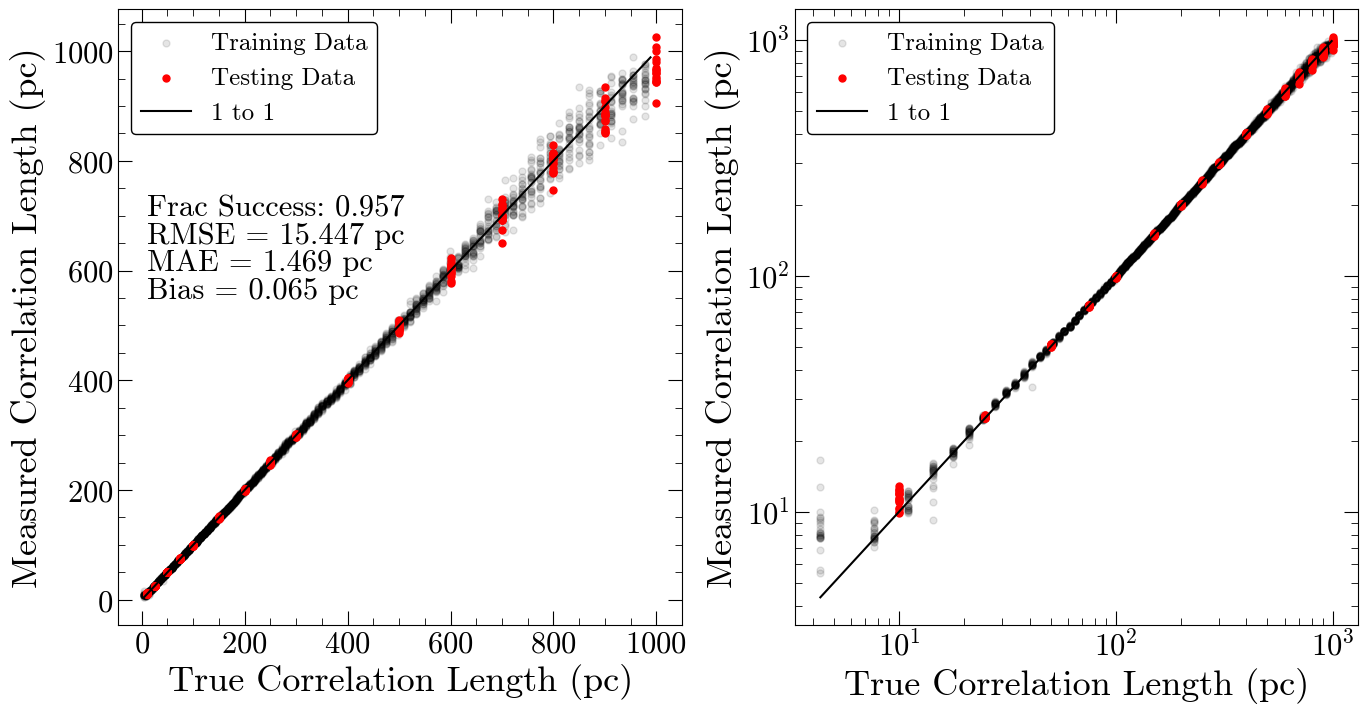

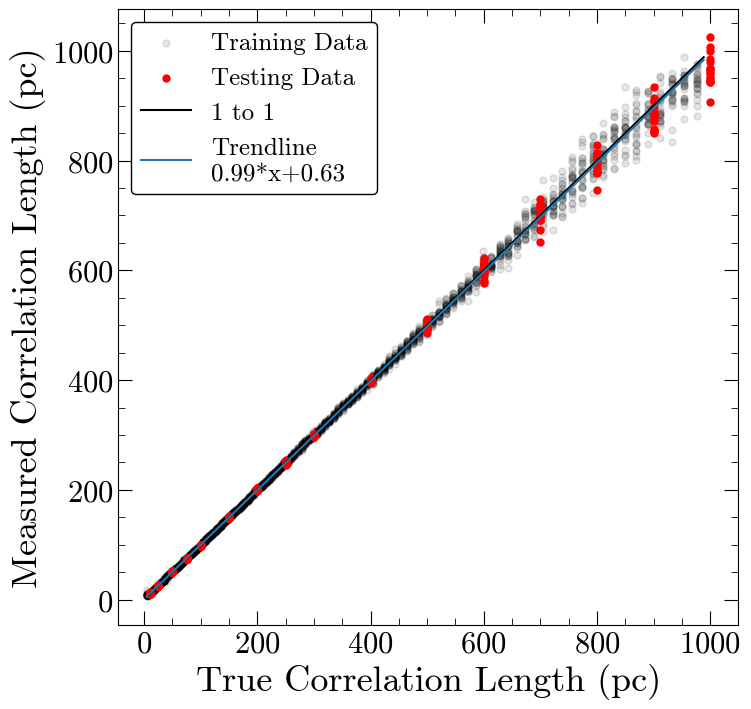

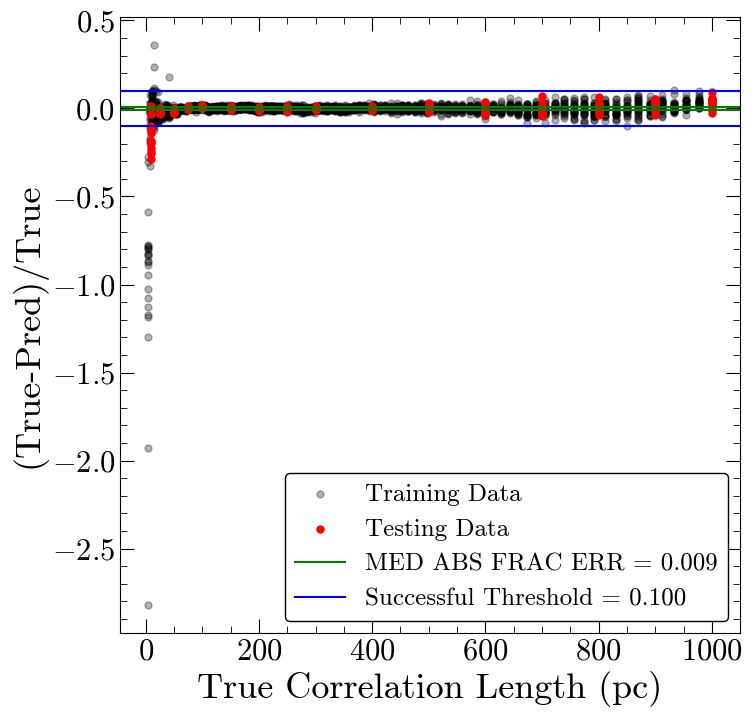

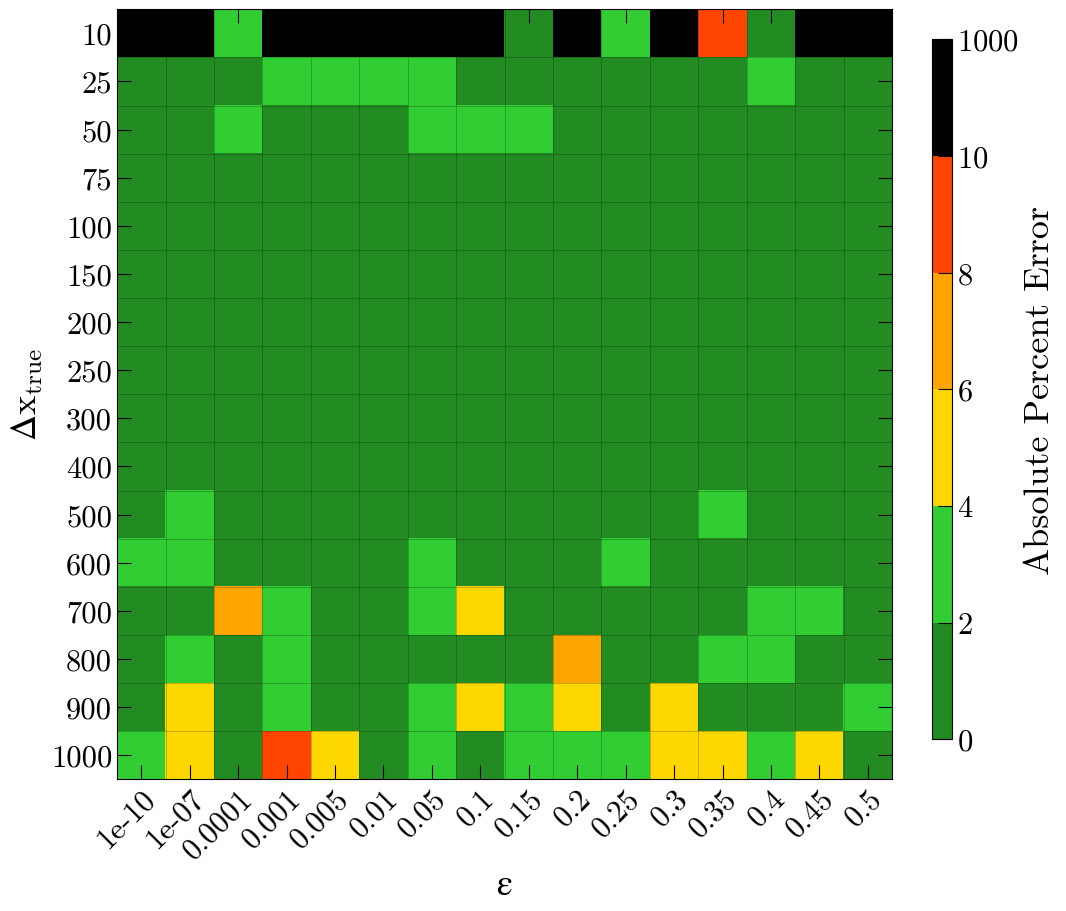

Number of squares with abs percent err>10%,  11


In [67]:
#model with more layers, run for even more epochs
model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(x_train.shape[1], 1)), 
    MaxPooling1D(2), 
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2), 
    Conv1D(128, 3, activation='relu'), 
    MaxPooling1D(2), 
    Flatten(), 
    Dense(128, activation='relu'),
    Dense(1) 
])

model.compile(optimizer='adam', loss='mse')

model.fit(x_train, y_train, epochs=400, batch_size=32)

output=test_model(model)

#save the most important stats
all_model_stats = pd.concat([all_model_stats, output])

Epoch 1/400
92/92 [==============================] - 0s 3ms/step - loss: 66542.0312
Epoch 2/400
92/92 [==============================] - 0s 4ms/step - loss: 1546.0928
Epoch 3/400
92/92 [==============================] - 0s 5ms/step - loss: 733.6927
Epoch 4/400
92/92 [==============================] - 0s 4ms/step - loss: 495.3907
Epoch 5/400
92/92 [==============================] - 0s 4ms/step - loss: 369.7237
Epoch 6/400
92/92 [==============================] - 0s 4ms/step - loss: 318.1390
Epoch 7/400
92/92 [==============================] - 0s 4ms/step - loss: 311.0609
Epoch 8/400
92/92 [==============================] - 0s 5ms/step - loss: 305.8465
Epoch 9/400
92/92 [==============================] - 0s 4ms/step - loss: 294.0801
Epoch 10/400
92/92 [==============================] - 0s 4ms/step - loss: 321.3181
Epoch 11/400
92/92 [==============================] - 0s 4ms/step - loss: 326.3933
Epoch 12/400
92/92 [==============================] - 0s 4ms/step - loss: 297.5680
Epoch 13/4

92/92 [==============================] - 0s 4ms/step - loss: 195.3671
Epoch 197/400
92/92 [==============================] - 0s 4ms/step - loss: 174.0430
Epoch 198/400
92/92 [==============================] - 0s 4ms/step - loss: 190.9997
Epoch 199/400
92/92 [==============================] - 0s 4ms/step - loss: 198.1829
Epoch 200/400
92/92 [==============================] - 0s 4ms/step - loss: 227.5209
Epoch 201/400
92/92 [==============================] - 0s 4ms/step - loss: 199.2490
Epoch 202/400
92/92 [==============================] - 0s 3ms/step - loss: 184.6768
Epoch 203/400
92/92 [==============================] - 0s 3ms/step - loss: 185.8510
Epoch 204/400
92/92 [==============================] - 0s 4ms/step - loss: 147.6227
Epoch 205/400
92/92 [==============================] - 0s 5ms/step - loss: 158.0616
Epoch 206/400
92/92 [==============================] - 0s 4ms/step - loss: 195.7128
Epoch 207/400
92/92 [==============================] - 0s 4ms/step - loss: 163.3546
Epoch 

92/92 [==============================] - 0s 4ms/step - loss: 174.3076
Epoch 391/400
92/92 [==============================] - 0s 4ms/step - loss: 170.0223
Epoch 392/400
92/92 [==============================] - 0s 4ms/step - loss: 164.7217
Epoch 393/400
92/92 [==============================] - 0s 4ms/step - loss: 182.7274
Epoch 394/400
92/92 [==============================] - 0s 4ms/step - loss: 174.4630
Epoch 395/400
92/92 [==============================] - 0s 4ms/step - loss: 151.1542
Epoch 396/400
92/92 [==============================] - 0s 4ms/step - loss: 158.2498
Epoch 397/400
92/92 [==============================] - 0s 4ms/step - loss: 187.5652
Epoch 398/400
92/92 [==============================] - 0s 4ms/step - loss: 152.3562
Epoch 399/400
92/92 [==============================] - 0s 4ms/step - loss: 157.6761
Epoch 400/400
92/92 [==============================] - 0s 4ms/step - loss: 175.7798

Showing the 0 curves that returned NaNs


Empty DataFrame
Columns: [y_true, epsilon, y_pred, abs_frac_err]
Index: []

Training Stats
RMSE: 13.570 pc
MAE: 2.336 pc
BIAS: 1.938 pc
MED FRAC ERR: 0.013 

Training Stats, Successful Fits
Frac Success Fit: 0.979 
RMSE: 13.389 pc
MAE: 2.384 pc
BIAS: 1.984 pc
MED FRAC ERR: 0.013 

Testing Stats
RMSE: 20.374 pc
MAE: 2.493 pc
BIAS: 2.182 pc
MED FRAC ERR: 0.015 

Testing Stats, Successful Fits
Frac Success Fit: 0.969 
RMSE: 19.439 pc
MAE: 2.586 pc
BIAS: 2.214 pc
MED FRAC ERR: 0.015 


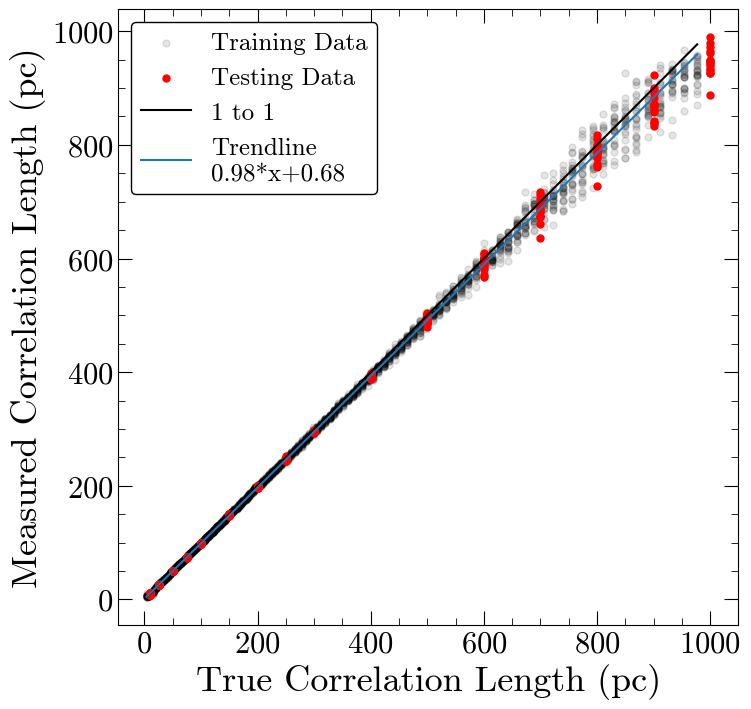

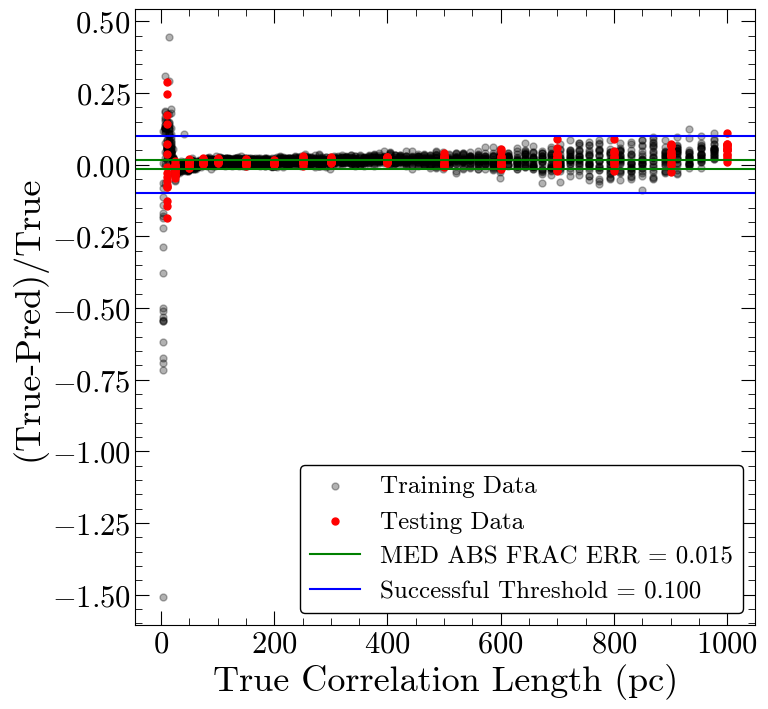

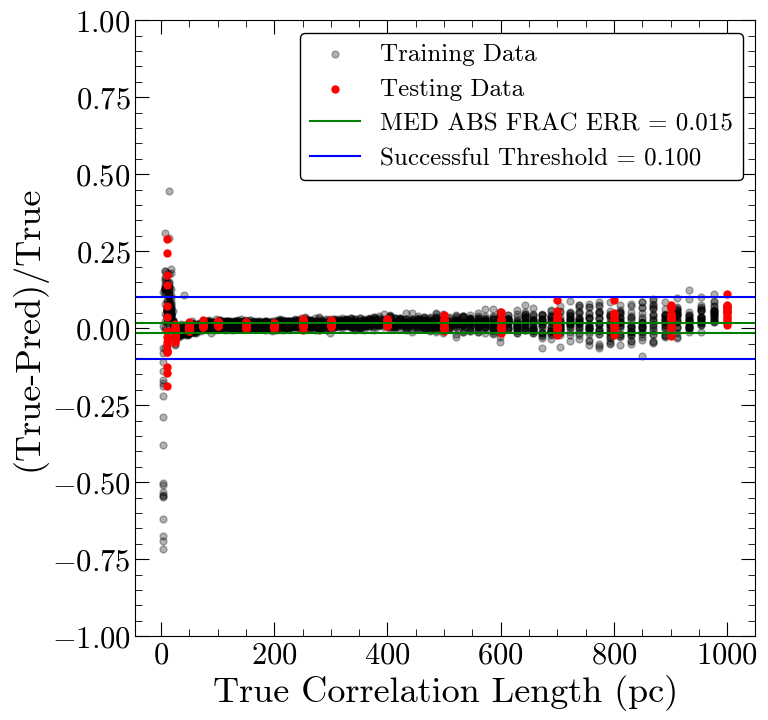

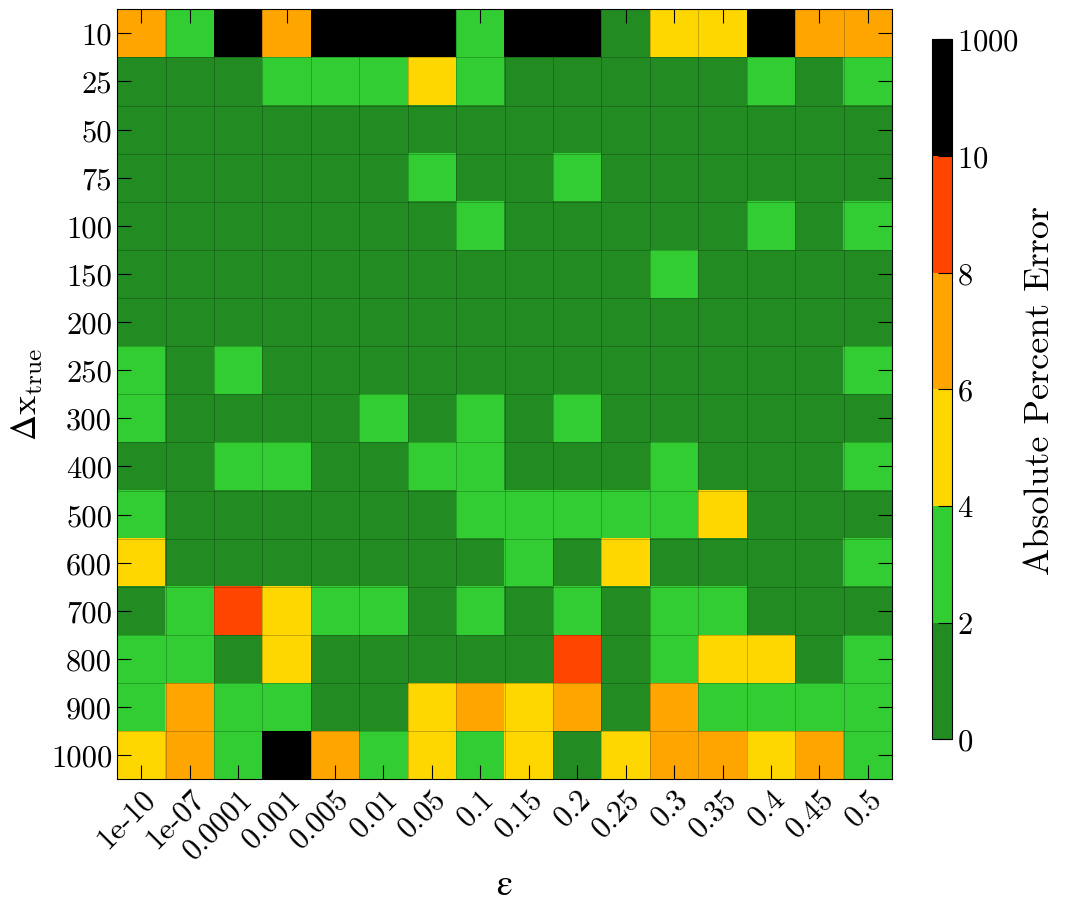

Number of squares with abs percent err>10%,  8


In [68]:
#model with even more layers, run for even more epochs
model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(x_train.shape[1], 1)), 
    MaxPooling1D(2), 
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2), 
    Conv1D(128, 3, activation='relu'), 
    MaxPooling1D(2), 
    Flatten(), 
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1) 
])

model.compile(optimizer='adam', loss='mse')

model.fit(x_train, y_train, epochs=400, batch_size=32)

output=test_model(model)

#save the most important stats
all_model_stats = pd.concat([all_model_stats, output])

Epoch 1/400
46/46 [==============================] - 0s 4ms/step - loss: 106786.9688
Epoch 2/400
46/46 [==============================] - 0s 4ms/step - loss: 11403.2051
Epoch 3/400
46/46 [==============================] - 0s 4ms/step - loss: 1564.7588
Epoch 4/400
46/46 [==============================] - 0s 5ms/step - loss: 921.8201
Epoch 5/400
46/46 [==============================] - 0s 5ms/step - loss: 672.5267
Epoch 6/400
46/46 [==============================] - 0s 4ms/step - loss: 568.3801
Epoch 7/400
46/46 [==============================] - 0s 4ms/step - loss: 445.8557
Epoch 8/400
46/46 [==============================] - 0s 4ms/step - loss: 405.9297
Epoch 9/400
46/46 [==============================] - 0s 4ms/step - loss: 354.3365
Epoch 10/400
46/46 [==============================] - 0s 5ms/step - loss: 328.2992
Epoch 11/400
46/46 [==============================] - 0s 5ms/step - loss: 292.4116
Epoch 12/400
46/46 [==============================] - 0s 5ms/step - loss: 275.6768
Epoch 1

46/46 [==============================] - 0s 5ms/step - loss: 166.6824
Epoch 197/400
46/46 [==============================] - 0s 5ms/step - loss: 178.6615
Epoch 198/400
46/46 [==============================] - 0s 5ms/step - loss: 150.8657
Epoch 199/400
46/46 [==============================] - 0s 5ms/step - loss: 149.1726
Epoch 200/400
46/46 [==============================] - 0s 5ms/step - loss: 149.3413
Epoch 201/400
46/46 [==============================] - 0s 5ms/step - loss: 162.1878
Epoch 202/400
46/46 [==============================] - 0s 5ms/step - loss: 176.1187
Epoch 203/400
46/46 [==============================] - 0s 5ms/step - loss: 169.8178
Epoch 204/400
46/46 [==============================] - 0s 5ms/step - loss: 183.7510
Epoch 205/400
46/46 [==============================] - 0s 5ms/step - loss: 140.3791
Epoch 206/400
46/46 [==============================] - 0s 4ms/step - loss: 194.8933
Epoch 207/400
46/46 [==============================] - 0s 5ms/step - loss: 162.8809
Epoch 

46/46 [==============================] - 0s 5ms/step - loss: 149.7298
Epoch 391/400
46/46 [==============================] - 0s 5ms/step - loss: 145.0003
Epoch 392/400
46/46 [==============================] - 0s 4ms/step - loss: 182.2155
Epoch 393/400
46/46 [==============================] - 0s 4ms/step - loss: 140.6119
Epoch 394/400
46/46 [==============================] - 0s 4ms/step - loss: 127.0769
Epoch 395/400
46/46 [==============================] - 0s 4ms/step - loss: 122.4682
Epoch 396/400
46/46 [==============================] - 0s 4ms/step - loss: 130.1003
Epoch 397/400
46/46 [==============================] - 0s 4ms/step - loss: 130.7139
Epoch 398/400
46/46 [==============================] - 0s 4ms/step - loss: 161.1486
Epoch 399/400
46/46 [==============================] - 0s 5ms/step - loss: 126.3423
Epoch 400/400
46/46 [==============================] - 0s 5ms/step - loss: 160.9015

Showing the 0 curves that returned NaNs


Empty DataFrame
Columns: [y_true, epsilon, y_pred, abs_frac_err]
Index: []

Training Stats
RMSE: 11.722 pc
MAE: 1.274 pc
BIAS: 0.384 pc
MED FRAC ERR: 0.008 

Training Stats, Successful Fits
Frac Success Fit: 0.985 
RMSE: 11.365 pc
MAE: 1.261 pc
BIAS: 0.389 pc
MED FRAC ERR: 0.008 

Testing Stats
RMSE: 17.235 pc
MAE: 1.460 pc
BIAS: 0.470 pc
MED FRAC ERR: 0.009 

Testing Stats, Successful Fits
Frac Success Fit: 0.984 
RMSE: 17.366 pc
MAE: 1.432 pc
BIAS: 0.470 pc
MED FRAC ERR: 0.009 


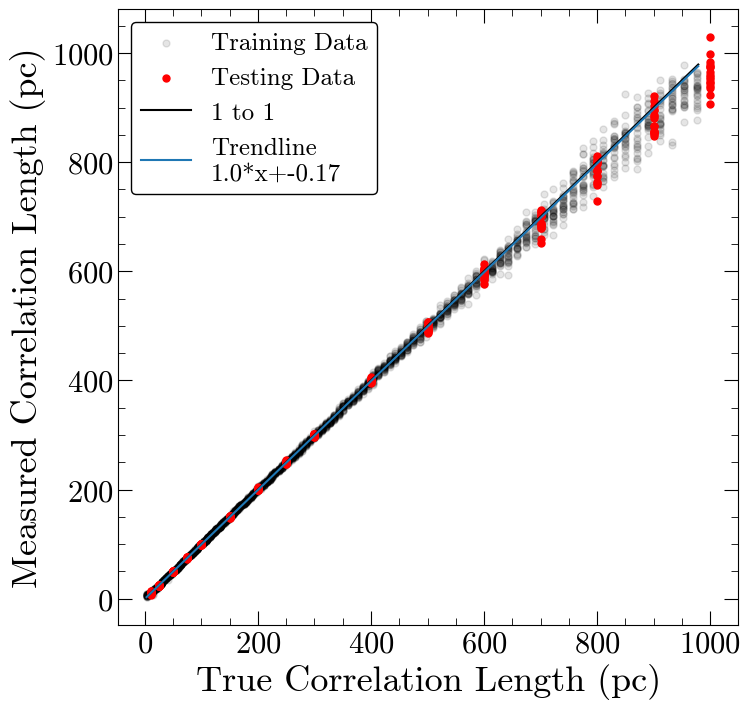

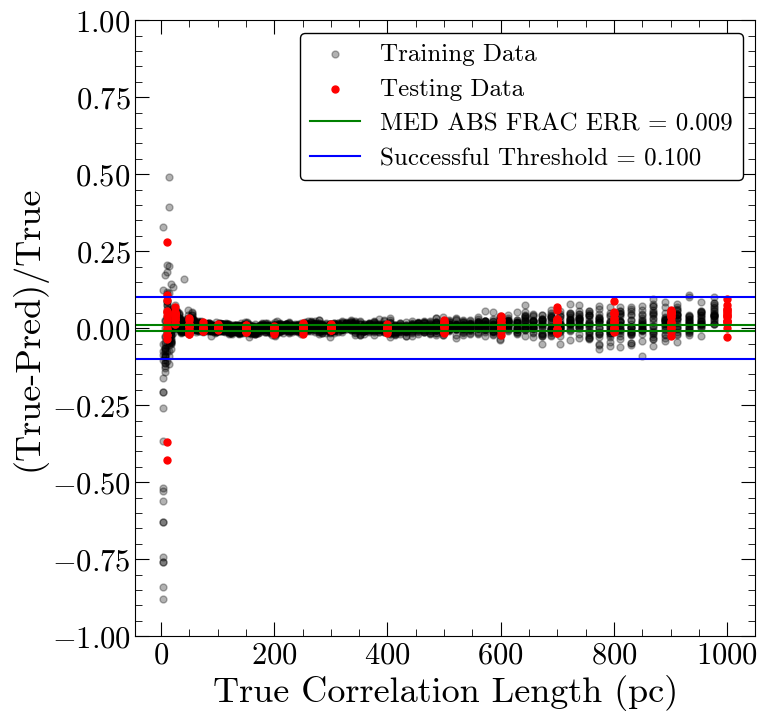

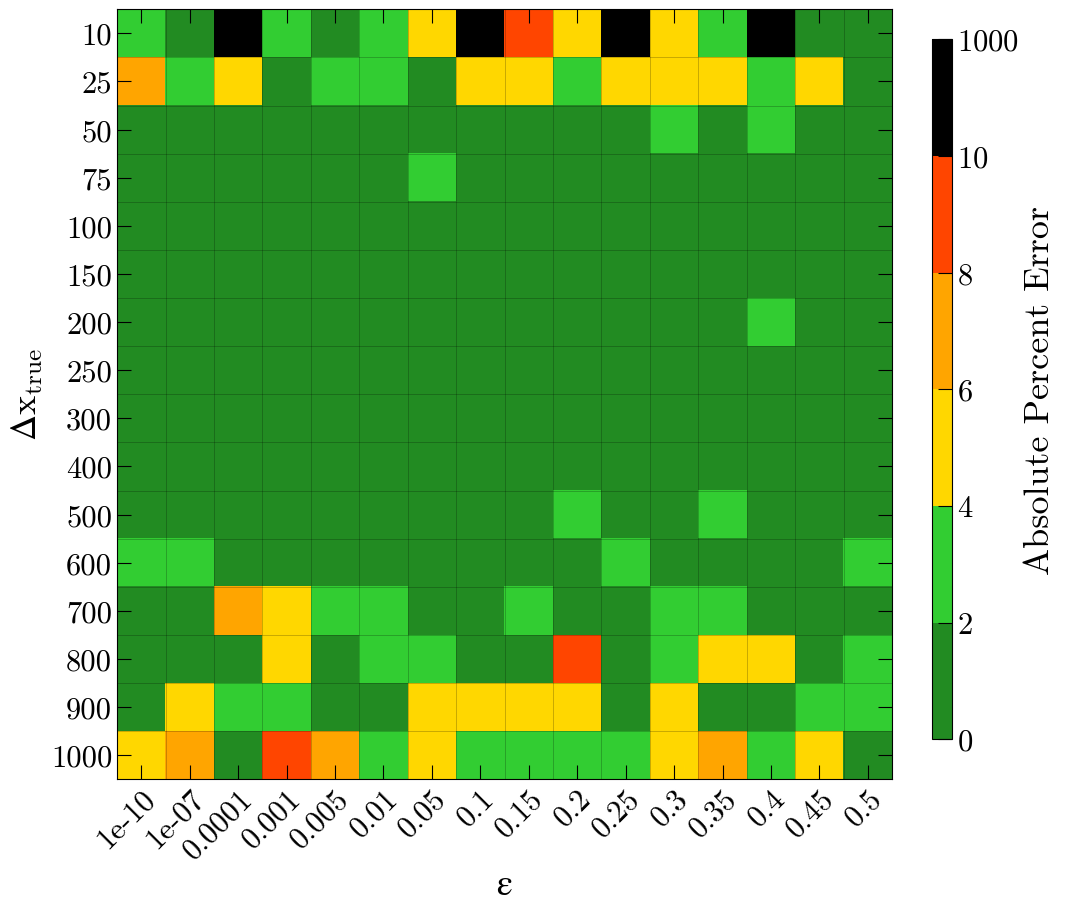

Number of squares with abs percent err>10%,  4


In [69]:
#model with even more layers, run for even more epochs, increase batch size
model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(x_train.shape[1], 1)), 
    MaxPooling1D(2), 
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2), 
    Conv1D(128, 3, activation='relu'), 
    MaxPooling1D(2), 
    Flatten(), 
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1) 
])

model.compile(optimizer='adam', loss='mse')

model.fit(x_train, y_train, epochs=400, batch_size=64)

output=test_model(model)

#save the most important stats
all_model_stats = pd.concat([all_model_stats, output])

Epoch 1/400
10/10 [==============================] - 0s 9ms/step - loss: 164270.8594
Epoch 2/400
10/10 [==============================] - 0s 10ms/step - loss: 161676.7031
Epoch 3/400
10/10 [==============================] - 0s 10ms/step - loss: 137202.5312
Epoch 4/400
10/10 [==============================] - 0s 9ms/step - loss: 64739.3125
Epoch 5/400
10/10 [==============================] - 0s 10ms/step - loss: 42358.0547
Epoch 6/400
10/10 [==============================] - 0s 9ms/step - loss: 31175.4805
Epoch 7/400
10/10 [==============================] - 0s 9ms/step - loss: 18812.4375
Epoch 8/400
10/10 [==============================] - 0s 9ms/step - loss: 8499.5020
Epoch 9/400
10/10 [==============================] - 0s 9ms/step - loss: 2959.7437
Epoch 10/400
10/10 [==============================] - 0s 9ms/step - loss: 2335.9321
Epoch 11/400
10/10 [==============================] - 0s 9ms/step - loss: 2001.1290
Epoch 12/400
10/10 [==============================] - 0s 10ms/step - los

10/10 [==============================] - 0s 10ms/step - loss: 192.9733
Epoch 195/400
10/10 [==============================] - 0s 10ms/step - loss: 184.7550
Epoch 196/400
10/10 [==============================] - 0s 10ms/step - loss: 190.9029
Epoch 197/400
10/10 [==============================] - 0s 10ms/step - loss: 184.8191
Epoch 198/400
10/10 [==============================] - 0s 10ms/step - loss: 186.3260
Epoch 199/400
10/10 [==============================] - 0s 10ms/step - loss: 191.2276
Epoch 200/400
10/10 [==============================] - 0s 10ms/step - loss: 180.2698
Epoch 201/400
10/10 [==============================] - 0s 10ms/step - loss: 183.9577
Epoch 202/400
10/10 [==============================] - 0s 10ms/step - loss: 186.6168
Epoch 203/400
10/10 [==============================] - 0s 10ms/step - loss: 184.4672
Epoch 204/400
10/10 [==============================] - 0s 10ms/step - loss: 191.4151
Epoch 205/400
10/10 [==============================] - 0s 10ms/step - loss: 179

10/10 [==============================] - 0s 11ms/step - loss: 158.8377
Epoch 387/400
10/10 [==============================] - 0s 10ms/step - loss: 151.3411
Epoch 388/400
10/10 [==============================] - 0s 10ms/step - loss: 163.0488
Epoch 389/400
10/10 [==============================] - 0s 10ms/step - loss: 170.6760
Epoch 390/400
10/10 [==============================] - 0s 9ms/step - loss: 153.5641
Epoch 391/400
10/10 [==============================] - 0s 10ms/step - loss: 145.3320
Epoch 392/400
10/10 [==============================] - 0s 10ms/step - loss: 157.2226
Epoch 393/400
10/10 [==============================] - 0s 10ms/step - loss: 140.0623
Epoch 394/400
10/10 [==============================] - 0s 10ms/step - loss: 164.8156
Epoch 395/400
10/10 [==============================] - 0s 10ms/step - loss: 157.5571
Epoch 396/400
10/10 [==============================] - 0s 10ms/step - loss: 166.5179
Epoch 397/400
10/10 [==============================] - 0s 11ms/step - loss: 201.

Empty DataFrame
Columns: [y_true, epsilon, y_pred, abs_frac_err]
Index: []

Training Stats
RMSE: 12.302 pc
MAE: 3.987 pc
BIAS: 3.429 pc
MED FRAC ERR: 0.025 

Training Stats, Successful Fits
Frac Success Fit: 0.953 
RMSE: 12.020 pc
MAE: 4.116 pc
BIAS: 3.493 pc
MED FRAC ERR: 0.024 

Testing Stats
RMSE: 16.310 pc
MAE: 4.665 pc
BIAS: 3.391 pc
MED FRAC ERR: 0.026 

Testing Stats, Successful Fits
Frac Success Fit: 0.922 
RMSE: 16.965 pc
MAE: 4.945 pc
BIAS: 3.929 pc
MED FRAC ERR: 0.024 


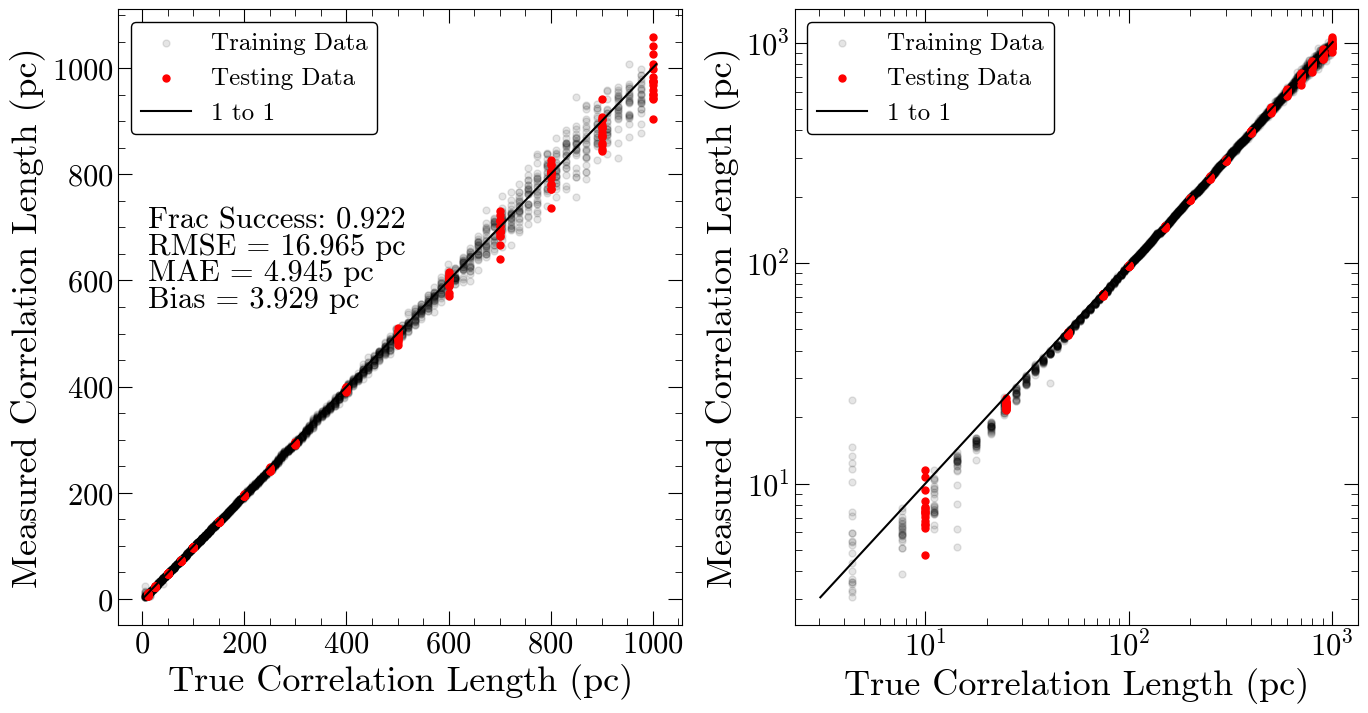

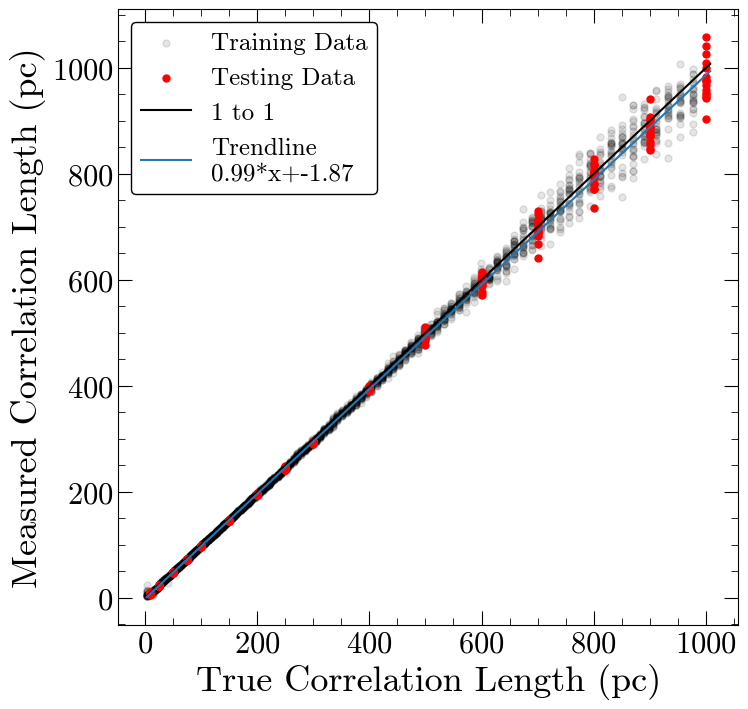

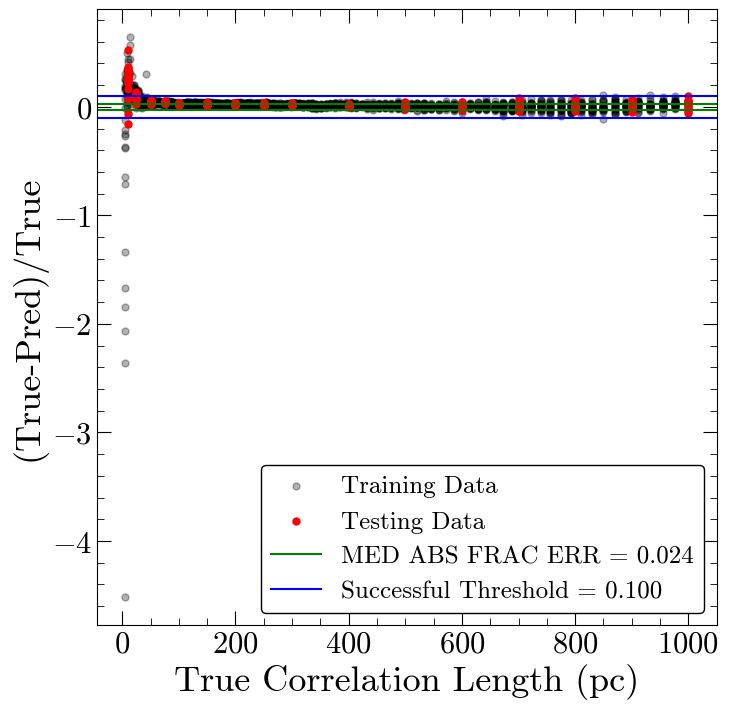

Number of squares with abs percent err>10%,  20


In [70]:
#model with even more layers, run for even more epochs, increase batch size even more
model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(x_train.shape[1], 1)), 
    MaxPooling1D(2), 
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2), 
    Conv1D(128, 3, activation='relu'), 
    MaxPooling1D(2), 
    Flatten(), 
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1) 
])

model.compile(optimizer='adam', loss='mse')

model.fit(x_train, y_train, epochs=400, batch_size=300)

output=test_model(model)

#save the most important stats
all_model_stats = pd.concat([all_model_stats, output])

# Save best model

In [88]:
#reset the indices
indices=np.arange(0,len(all_model_stats))
all_model_stats.set_index(indices,inplace=True)
#round all values
all_model_stats=all_model_stats.round(2)

print('Min MAE Training')
print(all_model_stats['mae_training'].idxmin(),', min val=',min(all_model_stats['mae_training']))
print('')

print('Max Frac Success Training')
print(all_model_stats['frac_success_training'].idxmax(),', max val=',max(all_model_stats['frac_success_training']))
print('')

print('Min MAE Testing')
print(all_model_stats['mae_testing'].idxmin(),', min val=',min(all_model_stats['mae_testing']))
print('')

print('Max Frac Success Testing')
print(all_model_stats['frac_success_testing'].idxmax(),', max val=',max(all_model_stats['frac_success_testing']))
print('')

display(all_model_stats)

#best model options are 7 or 9


Min MAE Training
9 , min val= 1.27

Max Frac Success Training
7 , max val= 0.99

Min MAE Testing
9 , min val= 1.46

Max Frac Success Testing
5 , max val= 0.98



mae_training  frac_success_training  mae_testing  frac_success_testing
0           2.76                   0.97         2.74                  0.94
1           3.28                   0.95         3.88                  0.90
2           2.86                   0.98         2.72                  0.96
3           1.71                   0.97         2.43                  0.94
4           1.78                   0.97         1.87                  0.96
5           2.35                   0.97         2.69                  0.98
6           1.57                   0.97         1.77                  0.96
7           1.28                   0.99         1.50                  0.96
8           2.34                   0.98         2.49                  0.97
9           1.27                   0.99         1.46                  0.98
10          3.99                   0.95         4.66                  0.92

In [103]:
#choose model 8 which is the best option across all runs

failed_fit_region_count=500

while failed_fit_region_count>9:
    #model with even more layers, run for even more epochs
    final_model = Sequential([
        Conv1D(32, 3, activation='relu', input_shape=(x_train.shape[1], 1)), 
        MaxPooling1D(2), 
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(2), 
        Conv1D(128, 3, activation='relu'), 
        MaxPooling1D(2), 
        Flatten(), 
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1) 
    ])

    final_model.compile(optimizer='adam', loss='mse')

    final_model.fit(x_train, y_train, epochs=400, batch_size=32)

    failed_fit_region_count,mae_testing_success,training_data,testing_data,nan_corr_lengths=test_model(final_model,stats=False,plot=False)
    
    print('')
    print(failed_fit_region_count)
    print('')

Epoch 1/400
92/92 [==============================] - 0s 3ms/step - loss: 64355.2539
Epoch 2/400
92/92 [==============================] - 0s 3ms/step - loss: 1744.1782
Epoch 3/400
92/92 [==============================] - 0s 3ms/step - loss: 922.2587
Epoch 4/400
92/92 [==============================] - 0s 4ms/step - loss: 612.9988
Epoch 5/400
92/92 [==============================] - 0s 4ms/step - loss: 464.8238
Epoch 6/400
92/92 [==============================] - 0s 4ms/step - loss: 390.5334
Epoch 7/400
92/92 [==============================] - 0s 4ms/step - loss: 370.1580
Epoch 8/400
92/92 [==============================] - 0s 4ms/step - loss: 341.3643
Epoch 9/400
92/92 [==============================] - 0s 4ms/step - loss: 303.7038
Epoch 10/400
92/92 [==============================] - 0s 4ms/step - loss: 334.1811
Epoch 11/400
92/92 [==============================] - 0s 5ms/step - loss: 309.2566
Epoch 12/400
92/92 [==============================] - 0s 5ms/step - loss: 303.6932
Epoch 13/4

92/92 [==============================] - 1s 6ms/step - loss: 147.9754
Epoch 197/400
92/92 [==============================] - 1s 6ms/step - loss: 180.6012
Epoch 198/400
92/92 [==============================] - 1s 6ms/step - loss: 177.1467
Epoch 199/400
92/92 [==============================] - 0s 5ms/step - loss: 188.1670
Epoch 200/400
92/92 [==============================] - 1s 6ms/step - loss: 166.8826
Epoch 201/400
92/92 [==============================] - 1s 8ms/step - loss: 202.5738
Epoch 202/400
92/92 [==============================] - 1s 8ms/step - loss: 157.7917
Epoch 203/400
92/92 [==============================] - 1s 6ms/step - loss: 163.4605
Epoch 204/400
92/92 [==============================] - 1s 7ms/step - loss: 200.2153
Epoch 205/400
92/92 [==============================] - 1s 8ms/step - loss: 196.8347
Epoch 206/400
92/92 [==============================] - 1s 7ms/step - loss: 209.3286
Epoch 207/400
92/92 [==============================] - 1s 7ms/step - loss: 200.8147
Epoch 

92/92 [==============================] - 1s 14ms/step - loss: 173.1929
Epoch 390/400
92/92 [==============================] - 1s 15ms/step - loss: 155.1548
Epoch 391/400
92/92 [==============================] - 1s 15ms/step - loss: 177.7738
Epoch 392/400
92/92 [==============================] - 1s 15ms/step - loss: 156.1291
Epoch 393/400
92/92 [==============================] - 1s 14ms/step - loss: 237.9303
Epoch 394/400
92/92 [==============================] - 2s 17ms/step - loss: 174.9056
Epoch 395/400
92/92 [==============================] - 1s 15ms/step - loss: 176.1065
Epoch 396/400
92/92 [==============================] - 1s 15ms/step - loss: 152.9566
Epoch 397/400
92/92 [==============================] - 1s 15ms/step - loss: 170.4888
Epoch 398/400
92/92 [==============================] - 1s 14ms/step - loss: 148.7652
Epoch 399/400
92/92 [==============================] - 1s 16ms/step - loss: 175.9670
Epoch 400/400
92/92 [==============================] - 1s 14ms/step - loss: 150

92/92 [==============================] - 1s 14ms/step - loss: 173.1854
Epoch 183/400
92/92 [==============================] - 1s 14ms/step - loss: 163.1693
Epoch 184/400
92/92 [==============================] - 1s 15ms/step - loss: 173.5351
Epoch 185/400
92/92 [==============================] - 1s 15ms/step - loss: 170.0266
Epoch 186/400
92/92 [==============================] - 1s 14ms/step - loss: 199.5513
Epoch 187/400
92/92 [==============================] - 2s 18ms/step - loss: 154.2440
Epoch 188/400
92/92 [==============================] - 2s 22ms/step - loss: 164.7474
Epoch 189/400
92/92 [==============================] - 1s 16ms/step - loss: 211.7999
Epoch 190/400
92/92 [==============================] - 1s 16ms/step - loss: 165.5293
Epoch 191/400
92/92 [==============================] - 2s 20ms/step - loss: 150.8612
Epoch 192/400
92/92 [==============================] - 2s 19ms/step - loss: 175.2065
Epoch 193/400
92/92 [==============================] - 2s 19ms/step - loss: 203

92/92 [==============================] - 1s 10ms/step - loss: 189.1628
Epoch 375/400
92/92 [==============================] - 1s 11ms/step - loss: 170.0742
Epoch 376/400
92/92 [==============================] - 1s 11ms/step - loss: 166.6906
Epoch 377/400
92/92 [==============================] - 1s 10ms/step - loss: 165.6300
Epoch 378/400
92/92 [==============================] - 1s 11ms/step - loss: 196.4322
Epoch 379/400
92/92 [==============================] - 1s 11ms/step - loss: 168.6153
Epoch 380/400
92/92 [==============================] - 1s 12ms/step - loss: 155.9947
Epoch 381/400
92/92 [==============================] - 1s 10ms/step - loss: 170.2062
Epoch 382/400
92/92 [==============================] - 1s 11ms/step - loss: 167.0064
Epoch 383/400
92/92 [==============================] - 1s 11ms/step - loss: 167.9830
Epoch 384/400
92/92 [==============================] - 1s 11ms/step - loss: 157.1329
Epoch 385/400
92/92 [==============================] - 1s 11ms/step - loss: 201

92/92 [==============================] - 1s 7ms/step - loss: 165.8705
Epoch 169/400
92/92 [==============================] - 1s 6ms/step - loss: 156.4661
Epoch 170/400
92/92 [==============================] - 1s 6ms/step - loss: 193.0618
Epoch 171/400
92/92 [==============================] - 1s 6ms/step - loss: 165.0359
Epoch 172/400
92/92 [==============================] - 1s 6ms/step - loss: 159.6103
Epoch 173/400
92/92 [==============================] - 1s 6ms/step - loss: 144.9827
Epoch 174/400
92/92 [==============================] - 1s 6ms/step - loss: 169.6343
Epoch 175/400
92/92 [==============================] - 1s 6ms/step - loss: 159.3244
Epoch 176/400
92/92 [==============================] - 1s 6ms/step - loss: 214.8279
Epoch 177/400
92/92 [==============================] - 1s 6ms/step - loss: 164.1448
Epoch 178/400
92/92 [==============================] - 1s 6ms/step - loss: 193.1249
Epoch 179/400
92/92 [==============================] - 1s 5ms/step - loss: 183.5341
Epoch 

92/92 [==============================] - 1s 6ms/step - loss: 150.8605
Epoch 363/400
92/92 [==============================] - 1s 7ms/step - loss: 215.2492
Epoch 364/400
92/92 [==============================] - 1s 10ms/step - loss: 166.1374
Epoch 365/400
92/92 [==============================] - 1s 6ms/step - loss: 144.5685
Epoch 366/400
92/92 [==============================] - 1s 6ms/step - loss: 165.6888
Epoch 367/400
92/92 [==============================] - 1s 7ms/step - loss: 148.0020
Epoch 368/400
92/92 [==============================] - 1s 7ms/step - loss: 175.3490
Epoch 369/400
92/92 [==============================] - 1s 7ms/step - loss: 142.0823
Epoch 370/400
92/92 [==============================] - 1s 7ms/step - loss: 167.0313
Epoch 371/400
92/92 [==============================] - 1s 9ms/step - loss: 146.4431
Epoch 372/400
92/92 [==============================] - 1s 7ms/step - loss: 130.7804
Epoch 373/400
92/92 [==============================] - 1s 7ms/step - loss: 155.2583
Epoch

92/92 [==============================] - 1s 10ms/step - loss: 190.6119
Epoch 159/400
92/92 [==============================] - 1s 8ms/step - loss: 178.2009
Epoch 160/400
92/92 [==============================] - 1s 8ms/step - loss: 160.5670
Epoch 161/400
92/92 [==============================] - 1s 9ms/step - loss: 175.2571
Epoch 162/400
92/92 [==============================] - 1s 9ms/step - loss: 168.9513
Epoch 163/400
92/92 [==============================] - 1s 9ms/step - loss: 204.9919
Epoch 164/400
92/92 [==============================] - 1s 10ms/step - loss: 162.2412
Epoch 165/400
92/92 [==============================] - 1s 8ms/step - loss: 223.2857
Epoch 166/400
92/92 [==============================] - 1s 9ms/step - loss: 198.6922
Epoch 167/400
92/92 [==============================] - 1s 11ms/step - loss: 325.7506
Epoch 168/400
92/92 [==============================] - 1s 9ms/step - loss: 173.7919
Epoch 169/400
92/92 [==============================] - 1s 8ms/step - loss: 164.4845
Epo

92/92 [==============================] - 1s 7ms/step - loss: 198.4159
Epoch 353/400
92/92 [==============================] - 1s 7ms/step - loss: 217.2427
Epoch 354/400
92/92 [==============================] - 1s 7ms/step - loss: 184.0256
Epoch 355/400
92/92 [==============================] - 1s 6ms/step - loss: 149.3372
Epoch 356/400
92/92 [==============================] - 1s 7ms/step - loss: 164.8741
Epoch 357/400
92/92 [==============================] - 1s 6ms/step - loss: 166.4048
Epoch 358/400
92/92 [==============================] - 1s 6ms/step - loss: 168.2221
Epoch 359/400
92/92 [==============================] - 1s 6ms/step - loss: 156.2034
Epoch 360/400
92/92 [==============================] - 1s 6ms/step - loss: 162.2824
Epoch 361/400
92/92 [==============================] - 1s 6ms/step - loss: 165.6930
Epoch 362/400
92/92 [==============================] - 1s 6ms/step - loss: 159.7192
Epoch 363/400
92/92 [==============================] - 1s 6ms/step - loss: 190.1078
Epoch 

In [104]:
#save the model
nb='00'
final_model.save('csv/nb05_sample_size_10207/'+nb+'_final_model')

INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/00_final_model/assets


INFO:tensorflow:Assets written to: csv/nb05_sample_size_10207/00_final_model/assets


In [107]:
def final_plot(nb,title,statx=10,staty=700,statdy=50,lim='default', siegel=True,success_fit_threshold=0.1):
    
    loaded_model = load_model('csv/nb05_sample_size_10207/'+nb+'_final_model')
    failed_fit_region_count,mae_testing_success,training_data,testing_data,nan_corr_lengths=test_model(loaded_model,stats=False,plot=False)
    
    # use the model to predict the training data
    y_pred_train = loaded_model.predict(x_train, verbose=0)
    training_data['y_pred']=y_pred_train
    
    # use the model to predict the training data
    y_pred_test = loaded_model.predict(x_test, verbose=0)
    testing_data['y_pred']=y_pred_test
    
    #drop the failed fits
    testing_data=testing_data.dropna()
    #reset the indices
    indices=np.arange(0,len(testing_data))
    testing_data.set_index(indices,inplace=True)
    
    y_true_training=training_data['y_true']
    y_pred_training=training_data['y_pred']
    y_true_testing=testing_data['y_true']
    y_pred_testing=testing_data['y_pred']
    
    unit='pc'
    
    #calculate stats
    rmse_training,mae_training,bias_training,med_frac_training,error_training,frac_err_training,frac_success=comparison_stats(training_data,False)
    rmse_training_success,mae_training_success,bias_training_success,med_frac_training_success,error_training_success,frac_err_training_success,frac_success_training=comparison_stats(training_data,False,True,success_fit_threshold)
    rmse_testing,mae_testing,bias_testing,med_frac_testing,error_testing,frac_err_testing,frac_success=comparison_stats(testing_data,False)
    rmse_testing_success,mae_testing_success,bias_testing_success,med_frac_testing_success,error_testing_success,frac_err_testing_success,frac_success_testing=comparison_stats(testing_data,False,True,success_fit_threshold)
    
    #plot the agreement with stats
    fig, ((ax1),(ax2)) =plt.subplots(2,1,figsize=(8,16),sharex=True)
    ax1.scatter(y_true_training,y_pred_training,c='k',alpha=0.1,label='Training Data')
    ax1.scatter(y_true_testing,y_pred_testing,c='r',label='Testing Data')
    #ax1.errorbar(y_true_testing,y_pred_testing,yerr=e_y_pred_testing,fmt='o',color='red',ecolor = 'red',label='Testing Data')
    ax1.text(statx, staty, 'Frac Success: {:2.3f} '.format(frac_success_testing))
    ax1.text(statx, staty-1*statdy, 'RMSE = {:.3f} '.format(rmse_testing_success)+unit)
    ax1.text(statx, staty-2*statdy, 'MAE = {:.3f} '.format(mae_testing_success)+unit)
    ax1.text(statx, staty-3*statdy, 'Bias = {:.3f} '.format(bias_testing_success)+unit)
    ax1.set_ylabel(r'Predicted Correlation Length (pc)')
    maxval=max(max(y_true_training),max(y_pred_training))
    minval=min(min(y_true_training),min(y_pred_training))
    #plot 1 to 1 trendline
    ax1.plot([minval,maxval], [minval,maxval], color = 'black',label="1 to 1")
    ax1.legend()
    if lim!='default':
        ax1.set_xlim((lim[0],lim[1]))
        ax1.set_ylim((lim[0],lim[1]))
    
    # plot the fractional error between the datasets zoomed in
    ax2.scatter(y_true_training, frac_err_training,c='k',alpha=0.3,label='Training Data')
    ax2.scatter(y_true_testing, frac_err_testing,c='r',label='Testing Data')
    ax2.axhline(0,color='black')
    ax2.axhline(med_frac_testing,color='green',label='Median Absolute\nFractional Error = {:.3f}'.format(med_frac_testing_success))
    ax2.axhline(-med_frac_testing,color='green')
    ax2.axhline(success_fit_threshold,color='blue',label='Successful Threshold = {:.1f}'.format(success_fit_threshold))
    ax2.axhline(-success_fit_threshold,color='blue')
    ax2.set_xlabel(r'True Correlation Length (pc)')
    ax2.set_ylabel(r'($\lambda_{True}-\lambda_{Pred})/\lambda_{True}$')
    ax2.set_ylim((-1,1))
    ax2.legend()
    
    ax1.set_title(title)
    
    plt.subplots_adjust(wspace = 0,hspace=0)
    plt.show()
    
    #make and save the heatmap, which is the figure that will be included in the paper
    failed_fit_region_count=heatmap_testing_data(testing_data,title,savefig=True,figname=nb+'_cnn_heatmap')
    

In [108]:
final_plot('00','CNN Model Performance\nNo Noise Sources',statdy=60)

Number of squares with abs percent err>10%,  6
